In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

project_root = os.getenv('PROJECT_ROOT')
print(project_root)
path = os.path.join(project_root)
os.chdir(os.path.join(path, "notebooks/evaluation"))
print(os.getcwd())

/Users/ivang/PycharmProjects/pythonProject/
/Users/ivang/PycharmProjects/pythonProject/notebooks/evaluation


In [3]:
import sys

sys.path.append(str(project_root))

In [4]:
from pathlib import Path

import bertopic as bt
import numpy as np
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from bertopic.representation import PartOfSpeech

from src.evaluation import Trainer, DataLoader

cwd = Path.cwd()
print(cwd)

/Users/ivang/PycharmProjects/pythonProject/notebooks/evaluation


[nltk_data] Downloading package punkt to /Users/ivang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ivang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Prepare data for OCTIS

In [5]:
%%time
# dataloader = DataLoader(dataset="trump").prepare_docs(save="trump.txt").preprocess_octis(output_folder="trump")
dataloader = DataLoader(dataset="openml").prepare_docs(save=os.path.join(cwd, "openml.txt"))
dropped_indices = dataloader.dropped_indices
dataloader.preprocess_octis(output_folder=os.path.join(cwd, "openml"))

Dropped indices: []


100%|██████████| 5283/5283 [00:00<00:00, 81749.72it/s]


created vocab
35084
words filtering done
CPU times: user 816 ms, sys: 47.6 ms, total: 864 ms
Wall time: 919 ms


In [6]:
dropped_indices

[]

In [7]:
import pandas as pd

# df = pd.read_csv("openml/corpus.tsv", sep="\t")
corpus = pd.read_csv(os.path.join(cwd, "openml/corpus.tsv"), sep="\t", header=None, keep_default_na=False)
# print df where NoneType
# print(df[df.isnull().any(axis=1)])
corpus

,0,1
0,Anneal Study Study Study Study Study Study Stu...,train
1,End-Game King Rook versus King Pawn on This da...,train
2,This dataset pertains to the final settlements...,train
3,Arrhythmia Machine Sport Cardiac Arrhythmia Da...,train
4,Letter Image Recognition Data The objective of...,train
...,...,...
5278,Credit Score Classification Person Credit Rela...,train
5279,The One Thirty Two dataset has been tagged wit...,train
5280,Login Data for Cybersecurity Events Login Data...,train
5281,Dataset User Ravi Dummy Data The event time wh...,train


In [8]:
dataset_name, custom = "openml", True
data_loader = DataLoader(dataset_name)
_, timestamps, _ = data_loader.load_docs()
dataset = data_loader.load_octis(custom)
data = [" ".join(words) for words in dataset.get_corpus()]

Dropped indices: []


# Bayesian optimization of BERTopic parameters

In [32]:
# embedding_model = SentenceTransformer("all-mpnet-base-v2")
embedding_model = SentenceTransformer("Salesforce/SFR-Embedding-Mistral")
# embeddings = embedding_model.encode(data, show_progress_bar=True)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [33]:
# save embeddings to mpnet_embeddings.npy
# np.save('mpnet_embeddings.npy', embeddings)
# load 
# embeddings = np.load('mpnet_embeddings.npy')

embeddings = np.load('../embeddings_prompts.npy')
# if embeddings have been previously saved without dropping indices, drop them
embeddings = np.delete(embeddings, dropped_indices, axis=0)

In [11]:
embeddings

array([[-6.0323005 ,  0.463492  ,  4.01652   , ..., 10.593845  ,
         1.414038  ,  1.8073224 ],
       [-0.64597124,  0.46698   ,  8.939073  , ...,  3.1171947 ,
         3.9019103 , -0.639417  ],
       [ 0.09761869,  2.8749747 ,  5.3688436 , ...,  7.345148  ,
         0.6610787 , -4.397552  ],
       ...,
       [-1.707054  , -4.600713  ,  6.8321843 , ...,  9.726519  ,
         1.1781559 , -0.02275772],
       [-1.1284977 , -3.094617  ,  9.088634  , ..., 14.350311  ,
        -0.18670313,  3.0565932 ],
       [ 2.261922  ,  1.777251  ,  1.8934423 , ...,  7.1790915 ,
         1.6553829 ,  0.3531418 ]], dtype=float32)

In [12]:
import spacy
import re

# !python -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")
nlp.max_length = 1500000


def preprocess_text(text):
    # Replace underscores and dashes with spaces
    # text = text.replace('_', ' ').replace('-', ' ')
    # Insert a space before all caps (but not at the start of the string)
    # text = re.sub(r'(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])', ' ', text)
    # Remove many whitespaces
    text = re.sub(r'\s+', ' ', text)

    # remove numbers
    # text = re.sub(r'\d+', '', text)

    return text


def safe_chunker(text, chunk_size=1000000):
    # Safely chunk the text by trying not to cut off sentences mid-way
    start = 0
    while start < len(text):
        end = start + chunk_size
        if end < len(text):
            # Move the end to the end of a sentence, if possible
            while end < len(text) and text[end] not in '.!?':
                end += 1
            end += 1  # Include the punctuation mark

            # If the adjusted end is still larger than chunk_size, cut at chunk_size
            if end - start > chunk_size:
                end = start + chunk_size
                # Move the end back to the last space to avoid cutting words
                while end > start and text[end] not in ' .!?':
                    end -= 1

        yield text[start:end].strip()
        start = end


def spacy_lemmatizer(text):
    text = preprocess_text(text)
    processed_tokens = []

    for chunk in safe_chunker(text):
        doc = nlp(chunk)
        lemmas = [
            token.lemma_.lower() for token in doc
            if not token.is_punct and not token.is_stop
        ]
        processed_tokens.extend(lemmas)

    return processed_tokens

In [13]:
from src.octis.bertopic import BERTopic
from octis.optimization.optimizer import Optimizer
from skopt.space.space import Real, Categorical, Integer
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from src.evaluation.weighted_metric import WeightedMetric
from src.evaluation.silhouette_metric import SilhouetteMetric

topk = 10
objective_metric = WeightedMetric(texts=dataset.get_corpus(), topk=topk)

In [14]:
npmi = Coherence(texts=dataset.get_corpus(), topk=topk)

In [15]:
diversity = TopicDiversity(topk=topk)

In [16]:
silhouette = SilhouetteMetric()

In [17]:
representation_model = PartOfSpeech(model='en_core_web_lg')

search_space = {
    # "embedding_model": Categorical(["all-mpnet-base-v2"]),
    # "embedding_model": Categorical(["Salesforce/SFR-Embedding-Mistral"]),
    # "nr_topics": Integer(10, 1000),
    # "min_topic_size": Integer(2, 40),
    # "min_topic_size": Integer(2, 15),
    "min_topic_size": Integer(2, 3),
    "ctfidf_reduce_frequent_words": Categorical({'True', 'False'}),
    # "umap_n_neighbors": Integer(2, 50),
    # "umap_n_neighbors": Integer(2, 20),
    "umap_n_neighbors": Integer(2, 3),
    "umap_n_components": Integer(2, 10),
    # "umap_min_dist": Real(0.0, 0.99),
    # "umap_min_dist": Real(0.0, 0.2),
    "umap_min_dist": Real(0.0, 0.01),
    "umap_metric": Categorical(['cosine', 'euclidean']),
    # "hdbscan_min_cluster_size": Integer(2, 50),
    # "hdbscan_min_cluster_size": Integer(2, 15),
    "hdbscan_min_cluster_size": Integer(2, 3),
    "hdbscan_metric": Categorical(['euclidean']),
    "hdbscan_cluster_selection_method": Categorical(['eom']),
    "vectorizer_ngram_range": Categorical({'(1, 1)', '(1, 2)'}),
    "vectorizer_stop_words": Categorical(["english"]),
    # "vectorizer_tokenizer": Categorical({'True', 'False'}),
    "vectorizer_tokenizer": Categorical({'False'}),
    "outliers_strategy": Categorical(['none',
                                    #   'probabilities',
                                    #   'distributions',
                                    #   'c-tf-idf',
                                    #   'embeddings'
                                      ]),
}

# Set optimization parameters
optimization_runs = 125
model_runs = 3
optimizer = Optimizer()

# Run optimization
optimization_result = optimizer.optimize(
    model=BERTopic(embeddings=embeddings, embedding_model=embedding_model, representation_model=representation_model, vectorizer_tokenizer=spacy_lemmatizer,
                   topk=topk, verbose=False),
    dataset=dataset,
    metric=objective_metric,
    search_space=search_space,
    number_of_call=optimization_runs,
    model_runs=model_runs,
    save_models=False,
    extra_metrics=[npmi, diversity, silhouette],
    save_path='./results/optimizer'
)

In [18]:
optimization_result.save_to_csv("./results/optimizer/results_BERTopic_salesforce_reduced_range.csv")

In [19]:
# import json
# 
# res = json.load(open("./results/optimizer/result.json", 'r'))
# res

In [38]:
results = pd.read_csv("./results/optimizer/results_BERTopic_salesforce_full_range.csv")
results

,dataset,surrogate model,acquisition function,num_iteration,time,Median(model_runs),Mean(model_runs),Standard_Deviation(model_runs),ctfidf_reduce_frequent_words,hdbscan_cluster_selection_method,...,umap_metric,umap_min_dist,umap_n_components,umap_n_neighbors,vectorizer_ngram_range,vectorizer_stop_words,vectorizer_tokenizer,Coherence(not optimized),Topic diversity(not optimized),Silhouette Metric(not optimized)
0,dataset_name,RF,LCB,0,259.640080,-0.642514,-0.640869,0.104771,False,eom,...,cosine,0.140294,9,16,"(1, 2)",english,False,-0.050834,0.586250,0.670745
1,dataset_name,RF,LCB,1,176.878657,-0.518799,-0.514261,0.239067,True,eom,...,cosine,0.196999,6,7,"(1, 2)",english,False,-0.055468,0.760000,0.679212
2,dataset_name,RF,LCB,2,202.675208,-0.433285,-0.431222,0.307894,True,eom,...,euclidean,0.026606,4,13,"(1, 1)",english,False,-0.044097,0.885000,0.712473
3,dataset_name,RF,LCB,3,428.392589,-0.735070,-0.737658,0.065363,True,eom,...,euclidean,0.032336,7,7,"(1, 2)",english,False,0.020172,0.449630,0.699850
4,dataset_name,RF,LCB,4,130.049505,-0.393081,-0.394567,0.326619,True,eom,...,euclidean,0.135437,8,17,"(1, 1)",english,False,-0.029973,0.933824,0.650321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,dataset_name,RF,LCB,120,120.173448,-0.392042,-0.391794,0.319187,True,eom,...,euclidean,0.185061,6,19,"(1, 1)",english,False,-0.014606,0.928358,0.746400
121,dataset_name,RF,LCB,121,124.789195,-0.398747,-0.399593,0.331304,True,eom,...,euclidean,0.196337,4,7,"(1, 1)",english,False,-0.036901,0.933333,0.602232
122,dataset_name,RF,LCB,122,142.757896,-0.408740,-0.406975,0.329299,True,eom,...,cosine,0.193578,6,7,"(1, 1)",english,False,-0.040651,0.922619,0.661282
123,dataset_name,RF,LCB,123,124.820519,-0.405466,-0.401989,0.311528,True,eom,...,euclidean,0.161293,2,20,"(1, 1)",english,False,-0.017495,0.911475,0.669978


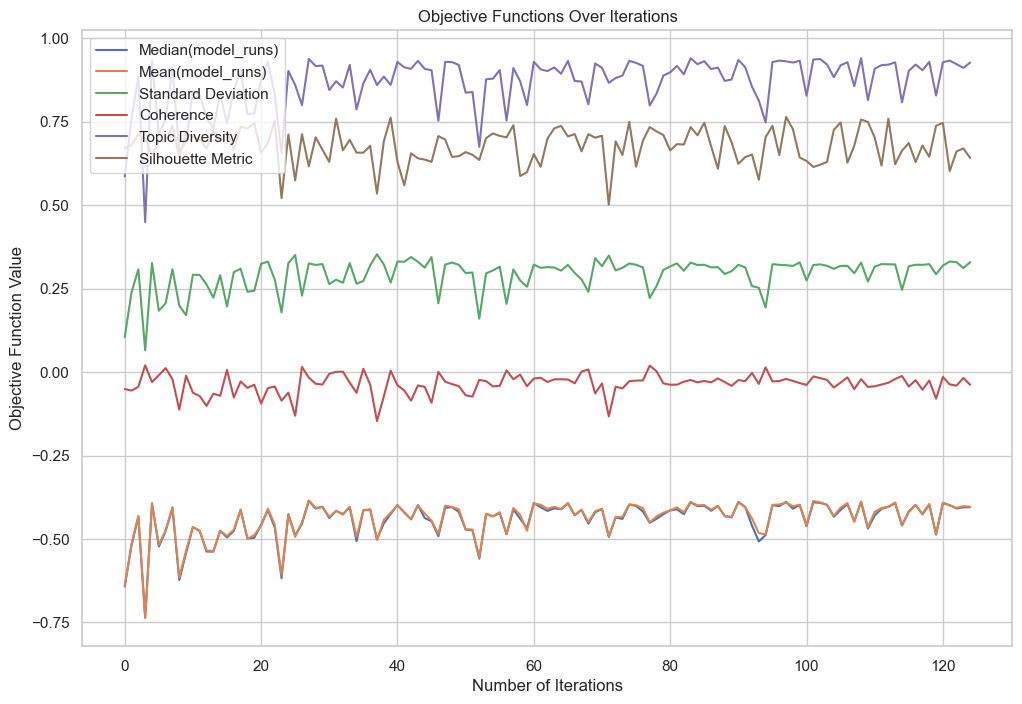

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))

# Plot each metric
sns.lineplot(data=results, x='num_iteration', y='Median(model_runs)', label='Median(model_runs)')
sns.lineplot(data=results, x='num_iteration', y='Mean(model_runs)', label='Mean(model_runs)')
sns.lineplot(data=results, x='num_iteration', y='Standard_Deviation(model_runs)', label='Standard Deviation')
sns.lineplot(data=results, x='num_iteration', y='Coherence(not optimized)', label='Coherence')
sns.lineplot(data=results, x='num_iteration', y='Topic diversity(not optimized)', label='Topic Diversity')
sns.lineplot(data=results, x='num_iteration', y='Silhouette Metric(not optimized)', label='Silhouette Metric')

# Label the axes and title
plt.xlabel('Number of Iterations')
plt.ylabel('Objective Function Value')
plt.title('Objective Functions Over Iterations')

# Display the legend
plt.legend(loc='upper left')

# Show the plot
plt.show()

## Initialize BERTopic model to test the best parameters

In [22]:
full_data = pd.read_csv("../data/prompt_descriptions.csv")
full_data = full_data.drop(dropped_indices)
full_data

,prompt_description
0,"Anneal \nTags: Manufacturing, Study One, Study..."
1,**Chess End-Game - King + Rook versus King + P...
2,**Labor Negotiations**\n\nThis dataset pertain...
3,"Arrhythmia \n\nTags: Machine Learning, Medicin..."
4,Title: Letter Image Recognition Data\n\nThe ob...
...,...
5278,Credit Score Classification \n\nTags: Person C...
5279,The One Thirty Two dataset has been tagged wit...
5280,Login Data for Cybersecurity Events \n\nTags: ...
5281,Dataset Name: User Ravi Tags: Dummy Data \n\nF...


In [23]:
def get_best_score(df, rank=1):
    """
    Get the best score from the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing scores.
    rank (int): The rank of the best score to retrieve (1 for best, 2 for second best, etc.).
    
    Returns:
    pd.Series: The row with the n-th best score based on 'Mean(model_runs)'.
    """
    # Sort the DataFrame by 'Mean(model_runs)' in ascending order
    df_sorted = df.sort_values(by='Mean(model_runs)', ascending=False).reset_index(drop=True)
    
    # Get the row with the n-th best score
    best_score_row = df_sorted.iloc[rank-1]
    
    return best_score_row

In [42]:
best_score = get_best_score(results)
print("Best score:", best_score)

Best score: dataset                             dataset_name
surrogate model                               RF
acquisition function                         LCB
num_iteration                                 27
time                                  118.878922
Median(model_runs)                      -0.38596
Mean(model_runs)                       -0.384626
Standard_Deviation(model_runs)          0.325426
ctfidf_reduce_frequent_words                True
hdbscan_cluster_selection_method             eom
hdbscan_metric                         euclidean
hdbscan_min_cluster_size                      15
min_topic_size                                 2
outliers_strategy                           none
umap_metric                            euclidean
umap_min_dist                           0.182375
umap_n_components                              4
umap_n_neighbors                              16
vectorizer_ngram_range                    (1, 1)
vectorizer_stop_words                    english
vectoriz

In [43]:
vectorizer_model = CountVectorizer(
    stop_words="english",
    ngram_range=(1, 1))

representation_model = PartOfSpeech(model='en_core_web_lg')

vectorizer_stop_words = best_score['vectorizer_stop_words']
ctfidf_reduce_frequent_words = best_score['ctfidf_reduce_frequent_words']
umap_n_neighbors = best_score['umap_n_neighbors']
umap_n_components = best_score['umap_n_components']
umap_min_dist = best_score['umap_min_dist']
umap_metric = best_score['umap_metric']
hdbscan_min_cluster_size = best_score['hdbscan_min_cluster_size']
hdbscan_metric = best_score['hdbscan_metric']
hdbscan_cluster_selection_method = best_score['hdbscan_cluster_selection_method']
min_topic_size = best_score['min_topic_size']

umap_model = UMAP(
    n_neighbors=umap_n_neighbors,
    n_components=umap_n_components,
    min_dist=umap_min_dist,
    metric=umap_metric
)

hdbscan_model = HDBSCAN(
    min_cluster_size=hdbscan_min_cluster_size,
    metric=hdbscan_metric,
    cluster_selection_method=hdbscan_cluster_selection_method,
    prediction_data=True
)

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=ctfidf_reduce_frequent_words)

model = bt.BERTopic(
    verbose=True,
    min_topic_size=min_topic_size,
    ctfidf_model=ctfidf_model,
    calculate_probabilities=True,
    umap_model=umap_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    representation_model=representation_model
)

topics, probs = model.fit_transform(data, embeddings)

In [26]:
topics = model.reduce_outliers(data, topics, probabilities=probs, embeddings=embeddings, strategy=best_score.get("outliers_strategy", "probabilities"))
model.update_topics(data, topics=topics)

UnboundLocalError: local variable 'new_topics' referenced before assignment

In [ ]:
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,34,0_anal_nominal_majority_cat,"[anal, nominal, majority, cat, binarized, rela...",[The Anal Cat Data Broadway dataset is a binar...
1,1,27,1_serotonin_hydroxytryptamine_ht_monoamine,"[serotonin, hydroxytryptamine, ht, monoamine, ...",[This dataset contains QSAR data showing activ...
2,2,30,2_subsampling_sampling_dionis_subsampled,"[subsampling, sampling, dionis, subsampled, un...",[Machine Learning and Statistics Subsampling o...
3,3,19,3_binarized_theta_chemistry_converted,"[binarized, theta, chemistry, converted, nomin...",[Visualizing Slope A Binarized Version for Che...
4,4,18,4_warcraft_yu_gi_sentences,"[warcraft, yu, gi, sentences, raid, avoid, fou...",[Re Study Study Study Word Count The company w...
...,...,...,...,...,...
886,886,3,886_cathepsin_adaptive_cysteine_toll,"[cathepsin, adaptive, cysteine, toll, immune, ...",[The QSAR-TID-17107 dataset contains QSAR data...
887,887,2,887_dual_specificity_regulated_dyrk,"[dual, specificity, regulated, dyrk, phosphory...",[QSAR-TID-100790 Dataset This dataset contains...
888,888,2,888_chemokine_sperm_thymocyte_cdw,"[chemokine, sperm, thymocyte, cdw, dn, cxcr, c...",[This dataset contains QSAR data showing activ...
889,889,2,889_pentavalent_vaccine_dose_immunization,"[pentavalent, vaccine, dose, immunization, mam...",[Mammography Dataset Myth Study This dataset p...


In [ ]:
all_words = [word for words in dataset.get_corpus() for word in words]
bertopic_topics = [
    [vals[0] if vals[0] in all_words else all_words[0] for vals in model.get_topic(i)[:topk]] for i in
    range(len(set(topics)) - 1)]

umap_embeddings = model.umap_model.transform(embeddings)
indices = [index for index, topic in enumerate(topics) if topic != -1]
document_embeddings = umap_embeddings[np.array(indices)].tolist()
cluster_labels = [topic for index, topic in enumerate(topics) if topic != -1]

output_tm = {"topics": bertopic_topics, "document_embeddings": document_embeddings, "cluster_labels": cluster_labels}

In [ ]:
print("Weighted metric: ", objective_metric.score(output_tm))
print("Coherence: ", npmi.score(output_tm))
print("Diversity: ", diversity.score(output_tm))
print("Silhouette: ", silhouette.score(output_tm))

Coherence score:  -0.08118399395818371 Normalized coherence score:  0.4594080030209081 Log coherence score:  -0.7778165680671512
Diversity score:  0.4360674157303371 Normalized diversity score:  0.4360674157303371 Log diversity score:  -0.8299584241220025
Weighted metric:  [-0.7778165680671512, -0.8299584241220025]
Coherence:  -0.08118399395818371
Diversity:  0.4360674157303371
Silhouette score:  0.45170088501811373
Silhouette:  0.45170088501811373


In [ ]:
pd.DataFrame({"Document": data, "Topic": topics})[pd.DataFrame({"Document": data, "Topic": topics})['Topic'] == 0]

,Document,Topic
87,Study Study Sixty Nine Number of Number of Dif...,0
89,BNG Vehicle Nominal Dataset Artificial The Com...,0
187,Vehicle BNG Study The vehicle has and Distance...,0
940,The KDD Cup Dataset offers the opportunity to ...,0
2443,Churn Computer Machine OpenML-CC18 This datase...,0
...,...,...
4866,The Churn dataset relates characteristics of t...,0
5155,A Tour and Travels Company wants to predict wh...,0
5172,The Telco Customer Churn tagged under Chemistr...,0
5181,Churn Uplift Orange Dataset This anonymized da...,0


In [62]:
# optimization_result = optimizer.resume_optimization('./results/optimizer/result.json', extra_evaluations=5)

KeyError: 'WeightedMetric'

## With pre-trained BERTopic model

In [108]:
# embeddings = np.load('../embeddings_prompts.npy')

In [109]:
# loaded_model = bt.BERTopic.load("../models/topic_model_text_generation", embedding_model=embedding_model)

In [110]:
# all_words = [word for words in dataset.get_corpus() for word in words]
# bertopic_topics = [
#     [vals[0] if vals[0] in all_words else all_words[0] for vals in loaded_model.get_topic(i)[:topk]] for i in
#     range(len(set(topics)) - 1)]
# 
# umap_embeddings = umap_model.transform(embeddings)
# indices = [index for index, topic in enumerate(topics) if topic != -1]
# document_embeddings = umap_embeddings[np.array(indices)].tolist()
# cluster_labels = [topic for index, topic in enumerate(topics) if topic != -1]
# 
# output_tm = {"topics": bertopic_topics, "document_embeddings": document_embeddings, "cluster_labels": cluster_labels}

In [122]:
# objective_metric = WeightedMetric(texts=dataset.get_corpus(), topk=topk)
# npmi = Coherence(texts=dataset.get_corpus(), topk=topk)
# diversity = TopicDiversity(topk=topk)
# silhouette = SilhouetteMetric()

In [123]:
# print("Weighted metric: ", objective_metric.score(output_tm))
# print("Coherence: ", npmi.score(output_tm))
# print("Diversity: ", diversity.score(output_tm))
# print("Silhouette: ", silhouette.score(output_tm))

/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Coherence score:  nan Normalized coherence score:  nan Log coherence score:  nan
Diversity score:  0.007407407407407408 Normalized diversity score:  0.007407407407407408 Log diversity score:  -4.905274764938429
Weighted metric:  [nan, -4.905274764938429]
Coherence:  nan
Diversity:  0.007407407407407408
Silhouette score:  0.6398403663920263
Silhouette:  0.6398403663920263


# Baselines and benchmarks

# Bayesian optimized BERTopic

In [45]:
vectorizer_stop_words = best_score['vectorizer_stop_words']
ctfidf_reduce_frequent_words = best_score['ctfidf_reduce_frequent_words']
umap_n_neighbors = best_score['umap_n_neighbors']
umap_n_components = best_score['umap_n_components']
umap_min_dist = best_score['umap_min_dist']
umap_metric = best_score['umap_metric']
hdbscan_min_cluster_size = best_score['hdbscan_min_cluster_size']
hdbscan_metric = best_score['hdbscan_metric']
hdbscan_cluster_selection_method = best_score['hdbscan_cluster_selection_method']
min_topic_size = int(best_score['min_topic_size'])

# Define models with extracted parameters
vectorizer_model = CountVectorizer(stop_words=vectorizer_stop_words, ngram_range=(1, 1))
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=ctfidf_reduce_frequent_words)
representation_model = PartOfSpeech(model='en_core_web_lg')

umap_model = UMAP(
    n_neighbors=umap_n_neighbors,
    n_components=umap_n_components,
    min_dist=umap_min_dist,
    metric=umap_metric
)

hdbscan_model = HDBSCAN(
    min_cluster_size=hdbscan_min_cluster_size,
    metric=hdbscan_metric,
    cluster_selection_method=hdbscan_cluster_selection_method,
    prediction_data=True
)

In [ ]:
for i in range(10):
    dataset_name, custom = "openml", True
    params = {
        "nr_topics": [10, 20, 30, 40, 50, 100, 200],
        "min_topic_size": min_topic_size,
        "embedding_model": embedding_model,
        "vectorizer_model": vectorizer_model,
        "representation_model": representation_model,
        "verbose": True,
        "umap_model": umap_model,
        "hdbscan_model": hdbscan_model,
        "ctfidf_model": ctfidf_model,
        "calculate_probabilities": True
    }

    trainer = Trainer(
        dataset=dataset_name,
        model_name="BERTopic",
        params=params,
        bt_embeddings=embeddings,
        custom_dataset=custom,
        reduce_outliers=True,
        verbose=True
    )
    results = trainer.train(save=f"./results/basic/openml/BERTopic_optimized_POS_full_range_{i+1}")

## BERTopic

In [34]:
vectorizer_model = CountVectorizer(
    stop_words="english",
    ngram_range=(1, 1))

representation_model = PartOfSpeech(model='en_core_web_lg')

In [ ]:
for i in range(10):
    dataset_name, custom = "openml", True
    params = {
        "nr_topics": [10, 20, 30, 40, 50, 100, 200],
        "min_topic_size": 15,
        # "diversity": None,
        "embedding_model": embedding_model,
        "vectorizer_model": vectorizer_model,
        "representation_model": representation_model,
        "verbose": True,
    }

    trainer = Trainer(dataset=dataset_name,
                      model_name="BERTopic",
                      params=params,
                      bt_embeddings=embeddings,
                      custom_dataset=custom,
                      reduce_outliers=True,
                      verbose=True)
    # results = trainer.train(save=f"./results/basic/openml/BERTopic_POS_mpnet_{i+1}")
    results = trainer.train(save=f"./results/basic/openml/BERTopic_POS_{i+1}")

## NMF

In [65]:
for i, random_state in enumerate([0, 21, 42, 50, 100, 150, 200, 250, 300, 350]):
    dataset_name, custom = "openml", True
    params = {"num_topics": [10, 20, 30, 40, 50, 100, 200], "random_state": random_state}
    trainer = Trainer(dataset=dataset_name,
                      model_name="NMF",
                      params=params,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=f"./results/basic/openml/NMF_{i+1}")

Results
npmi: -0.014603269689949508
diversity: 0.55
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'NMF', 'Params': {'num_topics': 10, 'random_state': 0}, 'Scores': {'npmi': -0.014603269689949508, 'diversity': 0.55}, 'Computation Time': 29.411203861236572}
Results
npmi: 0.09090846234518137
diversity: 0.495
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'NMF', 'Params': {'num_topics': 20, 'random_state': 0}, 'Scores': {'npmi': 0.09090846234518137, 'diversity': 0.495}, 'Computation Time': 22.741989850997925}
Results
npmi: 0.08105588141480587
diversity: 0.4666666666666667
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'NMF', 'Params': {'num_topics': 30, 'random_state': 0}, 'Scores': {'npmi': 0.08105588141480587, 'diversity': 0.4666666666666667}, 'Computation Time': 44.50745987892151}
Results
npmi: 0.10028089438950023
diversity: 0.37
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'NMF', 'Params': {'num_topics': 40, 'random_state': 0}, 'Scores': {'npmi': 0.10

## LDA

In [66]:
for i, random_state in enumerate([0, 21, 42, 50, 100, 150, 200, 250, 300, 350]):
    dataset_name, custom = "openml", True
    params = {"num_topics": [10, 20, 30, 40, 50, 100, 200], "random_state": random_state}

    trainer = Trainer(dataset=dataset_name,
                      model_name="LDA",
                      params=params,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=f"./results/basic/openml/LDA_{i+1}")

Results
npmi: -0.003532113175768476
diversity: 0.45
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'LDA', 'Params': {'num_topics': 10, 'random_state': 0}, 'Scores': {'npmi': -0.003532113175768476, 'diversity': 0.45}, 'Computation Time': 3.884232997894287}
Results
npmi: -0.00782365846358026
diversity: 0.435
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'LDA', 'Params': {'num_topics': 20, 'random_state': 0}, 'Scores': {'npmi': -0.00782365846358026, 'diversity': 0.435}, 'Computation Time': 4.187079906463623}
Results
npmi: -0.03985642982563572
diversity: 0.47
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'LDA', 'Params': {'num_topics': 30, 'random_state': 0}, 'Scores': {'npmi': -0.03985642982563572, 'diversity': 0.47}, 'Computation Time': 15.534148931503296}
Results
npmi: -0.0361276683320052
diversity: 0.45
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'LDA', 'Params': {'num_topics': 40, 'random_state': 0}, 'Scores': {'npmi': -0.0361276683320052, 'diversi

## CTM

Here, we use de CombinedTM of the Contextualized Topic Models: https://github.com/MilaNLProc/contextualized-topic-models

In [9]:
for i in range(10):
    print(i)
    dataset_name, custom = "openml", True
    params = {
        "n_components": [10, 20, 30, 40, 50, 100, 200],
        "contextual_size":768,
        "num_data_loader_workers": 0
    }

    trainer = Trainer(dataset=dataset_name,
                      model_name="CTM_CUSTOM",
                      params=params,
                      custom_dataset=custom,
                      verbose=True)
    results = trainer.train(save=f"./results/basic/openml/CTM_{i+1}")

0


/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/p

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 467.39899872570504	Time: 0:00:00.792952: : 100it [01:24,  1.18it/s]
100%|██████████| 83/83 [00:00<00:00, 182.11it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['binarized', 'nominal', 'lower', 'numeric', 'calculating', 'converted', 'classifying', 'instances', 'computing', 'others'], 1: ['columns', 'equals', 'number', 'classes', 'greater', 'value', 'column', 'categorical', 'sorted', 'counts'], 2: ['first', 'attributes', 'destination', 'window', 'sequence', 'next', 'size', 'measure', 'features', 'message'], 3: ['tm', 'double', 'calmodulin', 'atp', 'melanocortin', 'forward', 'systemes', 'tchem', 'neurokinin', 'estrogen'], 4: ['protein', 'regulation', 'receptor', 'cell', 'including', 'kinase', 'signaling', 'positive', 'involved', 'represent'], 5: ['one', 'zero', 'two', 'six', 'four', 'five', 'three', 'hundred', 'activity', 'eight'], 6: ['time', 'price', 'mean', 'within', 'ask', 'bid', 'changed', 'entire', 'highest', 'market'], 7: ['drug', 'represent', 'showing', 'molecular', 'compounds', 'bits', 'fingerprints', 'values', 'require', 'imputation'], 8: ['network', 'model', 'large', 'learning', 'available

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 455.1975696842845	Time: 0:00:00.950372: : 100it [01:37,  1.03it/s]
100%|██████████| 83/83 [00:00<00:00, 154.26it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['sequence', 'first', 'size', 'destination', 'attributes', 'window', 'source', 'record', 'content', 'calculated'], 1: ['price', 'time', 'mean', 'ask', 'within', 'class', 'bid', 'lowest', 'highest', 'historical'], 2: ['protein', 'kinase', 'including', 'drug', 'molecular', 'also', 'represent', 'belongs', 'serine', 'showing'], 3: ['drug', 'showing', 'represent', 'missing', 'molecular', 'fingerprints', 'require', 'obtained', 'bit', 'bits'], 4: ['file', 'versus', 'may', 'provided', 'suitable', 'variables', 'statistical', 'numerical', 'sets', 'containing'], 5: ['images', 'study', 'published', 'dataset', 'image', 'nineteen', 'please', 'taken', 'pixel', 'found'], 6: ['whether', 'total', 'per', 'date', 'percentage', 'day', 'age', 'individual', 'years', 'indicating'], 7: ['regulation', 'receptor', 'protein', 'including', 'signaling', 'positive', 'cell', 'response', 'involved', 'plasma'], 8: ['features', 'generated', 'datasets', 'artificial', 'independ

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 452.91725456423876	Time: 0:00:00.918211: : 100it [01:34,  1.05it/s]
100%|██████████| 83/83 [00:00<00:00, 170.55it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['zero', 'one', 'protein', 'two', 'activity', 'regulation', 'four', 'five', 'receptor', 'six'], 1: ['number', 'equals', 'columns', 'classes', 'column', 'rows', 'target', 'value', 'categorical', 'self'], 2: ['takes', 'maximum', 'function', 'specified', 'number', 'returns', 'selects', 'uses', 'exceeds', 'rows'], 3: ['ids', 'pci', 'reactome', 'mu', 'interpro', 'agc', 'mitogen', 'pref', 'systemes', 'mapk'], 4: ['original', 'sampling', 'process', 'resulting', 'subsampling', 'stratified', 'specific', 'dataset', 'selecting', 'involved'], 5: ['drug', 'molecular', 'bit', 'study', 'dataset', 'fingerprints', 'compounds', 'using', 'published', 'showing'], 6: ['first', 'size', 'destination', 'content', 'source', 'attributes', 'window', 'record', 'timestamp', 'options'], 7: ['price', 'time', 'mean', 'bid', 'within', 'ask', 'highest', 'recorded', 'lowest', 'direction'], 8: ['binarized', 'nominal', 'others', 'lower', 'numeric', 'version', 'classifying', 'co

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 453.23192094012006	Time: 0:00:00.897185: : 100it [01:32,  1.08it/s]
100%|██████████| 83/83 [00:00<00:00, 163.99it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['number', 'columns', 'classes', 'equals', 'column', 'rows', 'maximum', 'greater', 'target', 'categorical'], 1: ['original', 'process', 'dataset', 'resulting', 'sampling', 'involved', 'class', 'subsampling', 'selecting', 'specific'], 2: ['distance', 'attribute', 'species', 'tree', 'continuous', 'la', 'quantitative', 'soil', 'wilderness', 'type'], 3: ['receptor', 'zero', 'one', 'two', 'activity', 'four', 'molecule', 'five', 'hormone', 'antagonist'], 4: ['per', 'whether', 'user', 'system', 'indicating', 'memory', 'school', 'page', 'total', 'points'], 5: ['protein', 'zero', 'one', 'kinase', 'activity', 'two', 'four', 'six', 'phosphorylation', 'three'], 6: ['protein', 'kinase', 'cell', 'including', 'positive', 'regulation', 'tyrosine', 'transferase', 'represent', 'biological'], 7: ['one', 'hundred', 'thousand', 'point', 'two', 'three', 'five', 'four', 'six', 'twelve'], 8: ['receptor', 'bit', 'drug', 'molecular', 'represent', 'compounds', 'finger

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 455.2316243241473	Time: 0:00:00.886644: : 100it [01:32,  1.08it/s]
100%|██████████| 83/83 [00:00<00:00, 170.42it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['nominal', 'lower', 'others', 'binarized', 'numeric', 'version', 'classifying', 'computing', 'converted', 'feature'], 1: ['values', 'energy', 'collected', 'pixel', 'spatial', 'radar', 'ground', 'system', 'addition', 'absolute'], 2: ['data', 'contains', 'values', 'set', 'water', 'algae', 'connections', 'chemical', 'river', 'pulsar'], 3: ['price', 'time', 'mean', 'class', 'entire', 'direction', 'bid', 'within', 'spans', 'ask'], 4: ['pdbe', 'pharos', 'mapk', 'systemes', 'interpro', 'pfam', 'peroxisome', 'mu', 'inter', 'tchem'], 5: ['price', 'time', 'mean', 'bid', 'end', 'direction', 'ask', 'within', 'highest', 'historical'], 6: ['variables', 'customer', 'marketing', 'model', 'output', 'part', 'platform', 'make', 'build', 'customers'], 7: ['gene', 'communities', 'collection', 'tissue', 'microarray', 'expression', 'tumor', 'updated', 'conditions', 'availability'], 8: ['hundred', 'thousand', 'two', 'seventy', 'thirty', 'three', 'one', 'forty', 's

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 467.1910675793159	Time: 0:00:00.906866: : 100it [01:34,  1.06it/s]
100%|██████████| 83/83 [00:00<00:00, 143.74it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['insights', 'valuable', 'essential', 'aspects', 'comprises', 'understanding', 'individuals', 'providing', 'provide', 'distinct'], 1: ['protein', 'kinase', 'serine', 'specificity', 'threonine', 'cyclin', 'dual', 'including', 'transferase', 'activated'], 2: ['attributes', 'includes', 'content', 'diamond', 'words', 'include', 'record', 'destination', 'message', 'sequence'], 3: ['receptor', 'opioid', 'including', 'kappa', 'represent', 'ion', 'single', 'regulation', 'involved', 'hormone'], 4: ['data', 'contains', 'concentrations', 'chemical', 'river', 'water', 'algae', 'biological', 'fish', 'competition'], 5: ['maximum', 'specified', 'resulting', 'function', 'uniformly', 'sampling', 'stratified', 'takes', 'selects', 'classes'], 6: ['original', 'sampling', 'process', 'subsampling', 'ten', 'involved', 'dataset', 'resulting', 'subsampled', 'corresponding'], 7: ['age', 'logarithm', 'per', 'house', 'population', 'median', 'credit', 'natural', 'block'

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 498.7648162841797	Time: 0:00:00.968292: : 100it [01:34,  1.06it/s]
100%|██████████| 83/83 [00:00<00:00, 120.64it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['muscarinic', 'neurokinin', 'mu', 'cmgc', 'corticotropin', 'rat', 'glucagon', 'ids', 'rna', 'wikipedia'], 1: ['muscarinic', 'rat', 'dna', 'neurokinin', 'cmgc', 'rna', 'mu', 'cholecystokinin', 'corticotropin', 'glucagon'], 2: ['information', 'dataset', 'drug', 'provides', 'molecular', 'ontology', 'various', 'including', 'compounds', 'protein'], 3: ['receptor', 'signalling', 'hydroxytryptamine', 'molecular', 'serotonin', 'gpcr', 'fingerprints', 'tm', 'somatostatin', 'slash'], 4: ['protein', 'including', 'kinase', 'represent', 'regulation', 'showing', 'cell', 'biological', 'compounds', 'several'], 5: ['attributes', 'sequence', 'source', 'window', 'size', 'destination', 'timestamp', 'header', 'record', 'checksum'], 6: ['part', 'state', 'consider', 'states', 'health', 'mental', 'survey', 'whether', 'identify', 'education'], 7: ['mass', 'patient', 'diabetes', 'scaled', 'serum', 'disease', 'blood', 'ten', 'categorizes', 'year'], 8: ['value', 'seis

/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/p

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 467.27805198111184	Time: 0:00:00.863472: : 100it [01:29,  1.11it/s]
100%|██████████| 83/83 [00:00<00:00, 189.24it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['sf', 'dual', 'pharos', 'cascade', 'estrogen', 'tid', 'templated', 'signalling', 'ii', 'cytoplasm'], 1: ['nominal', 'numeric', 'binarized', 'converted', 'lower', 'classifying', 'instances', 'others', 'computing', 'achieved'], 2: ['datasets', 'features', 'different', 'normalized', 'added', 'colinearity', 'eighty', 'images', 'independent', 'measure'], 3: ['drug', 'compounds', 'contains', 'values', 'obtained', 'several', 'showing', 'molecular', 'bits', 'including'], 4: ['price', 'time', 'bid', 'highest', 'mean', 'class', 'ask', 'within', 'end', 'increase'], 5: ['provided', 'may', 'variables', 'individual', 'customer', 'whether', 'marketing', 'credit', 'user', 'age'], 6: ['number', 'equals', 'columns', 'rows', 'classes', 'maximum', 'categorical', 'subset', 'value', 'arguments'], 7: ['one', 'two', 'zero', 'six', 'four', 'hundred', 'five', 'three', 'activity', 'bit'], 8: ['protein', 'including', 'cell', 'kinase', 'receptor', 'regulation', 'involv

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 456.43973448218367	Time: 0:00:00.812452: : 100it [01:24,  1.19it/s]
100%|██████████| 83/83 [00:00<00:00, 185.09it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['number', 'value', 'columns', 'equals', 'classes', 'target', 'rows', 'column', 'categorical', 'name'], 1: ['network', 'nodes', 'average', 'blanket', 'approximately', 'discrete', 'complex', 'reference', 'medical', 'bnlearn'], 2: ['whether', 'per', 'variables', 'total', 'customer', 'credit', 'variable', 'marketing', 'numerical', 'percentage'], 3: ['machine', 'learning', 'gene', 'classification', 'tissue', 'without', 'expression', 'microarray', 'set', 'problems'], 4: ['first', 'attributes', 'destination', 'source', 'size', 'reduced', 'window', 'checksum', 'content', 'timestamp'], 5: ['specified', 'resulting', 'original', 'uniformly', 'selecting', 'maximum', 'process', 'takes', 'distribution', 'sampled'], 6: ['protein', 'kinase', 'regulation', 'including', 'signaling', 'cell', 'receptor', 'compounds', 'also', 'signal'], 7: ['images', 'image', 'please', 'found', 'pixel', 'pixels', 'hundred', 'url', 'see', 'collected'], 8: ['pharmacology', 'pfam'

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 453.98423729873286	Time: 0:00:00.972410: : 100it [01:36,  1.03it/s]
100%|██████████| 83/83 [00:00<00:00, 167.02it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['resulting', 'original', 'process', 'dataset', 'class', 'subsampling', 'sampling', 'specific', 'involved', 'sampled'], 1: ['first', 'size', 'attributes', 'content', 'destination', 'record', 'window', 'timestamp', 'source', 'flags'], 2: ['uniprot', 'peroxisome', 'pdbe', 'pharmacology', 'mapk', 'golgi', 'rattus', 'mu', 'mus', 'pf'], 3: ['price', 'time', 'mean', 'lowest', 'within', 'ask', 'historical', 'entire', 'bid', 'highest'], 4: ['maximum', 'number', 'rows', 'takes', 'selects', 'function', 'uses', 'specified', 'returns', 'exceeds'], 5: ['price', 'time', 'mean', 'lowest', 'ask', 'within', 'bid', 'historical', 'highest', 'entire'], 6: ['dataset', 'design', 'molecular', 'drug', 'molecules', 'published', 'study', 'studies', 'outputs', 'biological'], 7: ['compounds', 'several', 'bits', 'missing', 'represent', 'drug', 'usually', 'showing', 'imputation', 'fingerprints'], 8: ['mapk', 'uniprot', 'peroxisome', 'pdbe', 'golgi', 'pharmacology', 'ratt

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 452.877117994355	Time: 0:00:00.956047: : 100it [01:38,  1.01it/s]
100%|██████████| 83/83 [00:00<00:00, 160.21it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['first', 'change', 'cipher', 'spec', 'flags', 'port', 'disconnect', 'size', 'represents', 'destination'], 1: ['time', 'price', 'mean', 'bid', 'ask', 'lowest', 'direction', 'within', 'highest', 'historical'], 2: ['represent', 'bits', 'missing', 'several', 'showing', 'require', 'obtained', 'imputation', 'compounds', 'usually'], 3: ['maximum', 'function', 'takes', 'rows', 'specified', 'selects', 'number', 'returns', 'subsample', 'classes'], 4: ['gene', 'expression', 'machine', 'tissue', 'microarray', 'communities', 'clinical', 'tumor', 'updated', 'techniques'], 5: ['customer', 'variables', 'customers', 'part', 'state', 'consider', 'model', 'score', 'make', 'marketing'], 6: ['original', 'process', 'subsampling', 'involved', 'resulting', 'dataset', 'sampling', 'subsampled', 'selecting', 'specific'], 7: ['regulation', 'positive', 'cell', 'including', 'protein', 'signaling', 'growth', 'involved', 'response', 'cellular'], 8: ['number', 'equals', 'c

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 453.8290211747332	Time: 0:00:01.164599: : 100it [01:40,  1.01s/it]
100%|██████████| 83/83 [00:00<00:00, 146.47it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['binarized', 'nominal', 'version', 'converted', 'others', 'lower', 'numeric', 'classifying', 'majority', 'calculating'], 1: ['pf', 'mapk', 'mus', 'camk', 'dna', 'metalloproteinase', 'pref', 'ii', 'rna', 'cathepsin'], 2: ['average', 'network', 'approximately', 'blanket', 'nodes', 'reference', 'degree', 'point', 'history', 'medical'], 3: ['pf', 'mapk', 'rna', 'ii', 'mus', 'dna', 'interpro', 'pref', 'golgi', 'tid'], 4: ['binarized', 'lower', 'nominal', 'others', 'version', 'numeric', 'classifying', 'converted', 'computing', 'calculating'], 5: ['pf', 'mapk', 'rna', 'viral', 'dna', 'mus', 'ii', 'interpro', 'pref', 'cathepsin'], 6: ['record', 'sequence', 'content', 'message', 'attributes', 'destination', 'window', 'size', 'source', 'header'], 7: ['takes', 'number', 'maximum', 'specified', 'rows', 'selects', 'function', 'uses', 'returns', 'exceeds'], 8: ['learning', 'cancer', 'machine', 'classification', 'examples', 'concept', 'properties', 'train

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 466.23305381216653	Time: 0:00:01.008127: : 100it [01:48,  1.08s/it]
100%|██████████| 83/83 [00:00<00:00, 132.92it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['first', 'length', 'kind', 'change', 'size', 'responses', 'spec', 'status', 'pointer', 'cipher'], 1: ['using', 'class', 'defect', 'maximum', 'software', 'resulting', 'word', 'lines', 'dataset', 'subsampling'], 2: ['tissue', 'communities', 'tumor', 'gene', 'annotated', 'updated', 'availability', 'assistance', 'analyses', 'repository'], 3: ['sequence', 'destination', 'window', 'attributes', 'message', 'source', 'size', 'record', 'urgent', 'header'], 4: ['muscarinic', 'mapk', 'cansar', 'disc', 'ca', 'rat', 'wikipedia', 'ids', 'corticotropin', 'camk'], 5: ['various', 'including', 'biological', 'involved', 'signal', 'also', 'regulation', 'plays', 'receptor', 'represent'], 6: ['time', 'price', 'mean', 'ask', 'direction', 'bid', 'historical', 'within', 'end', 'lowest'], 7: ['values', 'absolute', 'radar', 'indicate', 'affect', 'spatial', 'mission', 'pixel', 'background', 'global'], 8: ['receptor', 'molecular', 'serotonin', 'fingerprints', 'hydroxyt

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 498.7774937327315	Time: 0:00:01.022435: : 100it [01:44,  1.05s/it]
100%|██████████| 83/83 [00:00<00:00, 117.32it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['price', 'ask', 'bid', 'mean', 'hourly', 'time', 'lowest', 'within', 'class', 'subsequent'], 1: ['muscarinic', 'wikipedia', 'glucagon', 'bradykinin', 'rhodopsin', 'rat', 'disc', 'mu', 'corticotropin', 'september'], 2: ['protein', 'kinase', 'including', 'atlas', 'subunit', 'threonine', 'specificity', 'cyclin', 'homo', 'molecular'], 3: ['thousand', 'handwritten', 'patterns', 'three', 'sixty', 'two', 'forty', 'thirty', 'twenty', 'eighty'], 4: ['others', 'binarized', 'nominal', 'version', 'lower', 'numeric', 'feature', 'target', 'converted', 'instances'], 5: ['molecular', 'descriptors', 'focused', 'researchers', 'weighted', 'relationships', 'models', 'dataset', 'regression', 'quantitative'], 6: ['receptor', 'protein', 'cell', 'regulation', 'includes', 'kinase', 'tyrosine', 'epidermal', 'transmembrane', 'positive'], 7: ['first', 'represents', 'number', 'change', 'cipher', 'spec', 'port', 'frame', 'server', 'stream'], 8: ['square', 'footage', 'ge

/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/p

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 466.8045025337033	Time: 0:00:01.065170: : 100it [01:44,  1.04s/it]
100%|██████████| 83/83 [00:00<00:00, 164.12it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['kinase', 'protein', 'regulation', 'including', 'receptor', 'signaling', 'molecular', 'cell', 'compounds', 'involved'], 1: ['one', 'two', 'zero', 'three', 'six', 'hundred', 'five', 'four', 'thousand', 'eight'], 2: ['first', 'scale', 'attributes', 'size', 'window', 'generated', 'source', 'calculated', 'message', 'datasets'], 3: ['network', 'blanket', 'large', 'repository', 'learning', 'gene', 'machine', 'microarray', 'updated', 'model'], 4: ['compounds', 'drug', 'molecular', 'bits', 'fingerprints', 'represent', 'contains', 'imputation', 'values', 'require'], 5: ['mechanism', 'muscarinic', 'signalling', 'reactome', 'tm', 'pubmed', 'cascade', 'estrogen', 'sf', 'cytochrome'], 6: ['binarized', 'nominal', 'classifying', 'numeric', 'lower', 'converted', 'denoted', 'conversion', 'others', 'achieved'], 7: ['number', 'classes', 'equals', 'columns', 'rows', 'categorical', 'value', 'subset', 'maximum', 'selected'], 8: ['price', 'time', 'mean', 'followi

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 456.5457879043207	Time: 0:00:00.843665: : 100it [01:28,  1.13it/s]
100%|██████████| 83/83 [00:00<00:00, 190.74it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['customer', 'whether', 'individuals', 'credit', 'per', 'insights', 'variables', 'valuable', 'date', 'rate'], 1: ['one', 'two', 'zero', 'six', 'activity', 'three', 'four', 'five', 'receptor', 'protein'], 2: ['data', 'values', 'collected', 'variables', 'measured', 'quality', 'attribute', 'chemical', 'pixel', 'surface'], 3: ['inter', 'assembly', 'corticotropin', 'browse', 'pf', 'px', 'atp', 'pharos', 'rattus', 'signalling'], 4: ['dataset', 'please', 'images', 'image', 'code', 'details', 'see', 'found', 'study', 'year'], 5: ['number', 'equals', 'value', 'columns', 'column', 'classes', 'data', 'categorical', 'dot', 'parenthesis'], 6: ['compounds', 'drug', 'showing', 'represent', 'several', 'molecular', 'bits', 'missing', 'require', 'usually'], 7: ['machine', 'gene', 'learning', 'problems', 'classification', 'clinical', 'tumor', 'microarray', 'expression', 'estimating'], 8: ['inter', 'pf', 'assembly', 'corticotropin', 'atp', 'pharos', 'browse', '

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 455.92348647699123	Time: 0:00:01.095673: : 100it [01:39,  1.01it/s]
100%|██████████| 83/83 [00:00<00:00, 161.02it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['gene', 'machine', 'microarray', 'learning', 'classification', 'expression', 'communities', 'tissue', 'decision', 'tumor'], 1: ['may', 'provided', 'variables', 'methods', 'customer', 'statistical', 'code', 'file', 'suitable', 'sets'], 2: ['number', 'columns', 'classes', 'equals', 'rows', 'dot', 'column', 'parenthesis', 'value', 'name'], 3: ['nominal', 'numeric', 'others', 'lower', 'binarized', 'version', 'classifying', 'instances', 'computing', 'feature'], 4: ['reactome', 'ca', 'pf', 'pharmacology', 'september', 'pubmed', 'vitamin', 'cmgc', 'calmodulin', 'uniprot'], 5: ['price', 'time', 'mean', 'ask', 'bid', 'lowest', 'within', 'class', 'highest', 'direction'], 6: ['including', 'protein', 'biological', 'cell', 'also', 'involved', 'signal', 'kinase', 'regulation', 'various'], 7: ['nominal', 'binarized', 'others', 'numeric', 'converted', 'lower', 'version', 'classifying', 'life', 'achieved'], 8: ['attributes', 'record', 'sequence', 'size', 'w

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 453.28429840832223	Time: 0:00:01.099036: : 100it [01:47,  1.07s/it]
100%|██████████| 83/83 [00:00<00:00, 141.05it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['patient', 'whether', 'blood', 'continuous', 'serum', 'axis', 'major', 'database', 'disease', 'distance'], 1: ['price', 'time', 'lowest', 'mean', 'ask', 'bid', 'within', 'historical', 'highest', 'following'], 2: ['drug', 'compounds', 'molecular', 'fingerprints', 'missing', 'represent', 'require', 'showing', 'bits', 'activity'], 3: ['protein', 'kinase', 'drug', 'including', 'serine', 'molecular', 'also', 'fingerprints', 'several', 'transferase'], 4: ['user', 'date', 'web', 'information', 'online', 'provides', 'comprises', 'comprehensive', 'unique', 'content'], 5: ['pept', 'ca', 'mapk', 'pharos', 'camk', 'atp', 'inter', 'usan', 'muscarinic', 'tchem'], 6: ['regulation', 'including', 'cell', 'various', 'positive', 'also', 'involved', 'cellular', 'biological', 'response'], 7: ['price', 'time', 'mean', 'lowest', 'within', 'ask', 'historical', 'following', 'bid', 'highest'], 8: ['tissue', 'gene', 'clinical', 'microarray', 'tumor', 'communities', '

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 455.1438535364663	Time: 0:00:00.924467: : 100it [01:31,  1.09it/s]
100%|██████████| 83/83 [00:00<00:00, 162.05it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['nominal', 'binarized', 'others', 'version', 'lower', 'numeric', 'converted', 'feature', 'classifying', 'instances'], 1: ['mapk', 'pept', 'rhodopsin', 'mu', 'mus', 'tid', 'reactome', 'pfam', 'corticotropin', 'peroxisome'], 2: ['protein', 'regulation', 'cell', 'two', 'one', 'activity', 'phosphorylation', 'kinase', 'binding', 'differentiation'], 3: ['molecular', 'activity', 'dataset', 'drug', 'models', 'predict', 'using', 'used', 'descriptors', 'modeling'], 4: ['first', 'spec', 'cipher', 'change', 'port', 'server', 'disconnect', 'size', 'responses', 'alert'], 5: ['file', 'provided', 'may', 'statistical', 'sets', 'suitable', 'freely', 'book', 'containing', 'zip'], 6: ['zero', 'one', 'time', 'equals', 'columns', 'price', 'flags', 'ask', 'bid', 'classes'], 7: ['original', 'resulting', 'process', 'sampling', 'involved', 'subsampling', 'class', 'uniformly', 'dataset', 'specific'], 8: ['including', 'regulation', 'cell', 'protein', 'represent', 'pos

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 465.45884481290494	Time: 0:00:00.946709: : 100it [01:36,  1.04it/s]
100%|██████████| 83/83 [00:00<00:00, 138.68it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['angle', 'vehicles', 'images', 'shape', 'extracted', 'captured', 'vehicle', 'plant', 'please', 'leaf'], 1: ['two', 'thousand', 'nineteen', 'dataset', 'published', 'study', 'journal', 'one', 'hundred', 'based'], 2: ['data', 'river', 'algae', 'water', 'contains', 'concentrations', 'set', 'chemical', 'competition', 'environment'], 3: ['represent', 'extracellular', 'require', 'collagen', 'protease', 'cathepsin', 'missing', 'bits', 'showing', 'endopeptidase'], 4: ['one', 'flags', 'zero', 'size', 'disconnect', 'spec', 'change', 'cipher', 'window', 'car'], 5: ['classes', 'number', 'columns', 'target', 'rows', 'maximum', 'drop', 'string', 'def', 'equals'], 6: ['maximum', 'classes', 'resulting', 'original', 'specified', 'sampling', 'function', 'stratified', 'uniformly', 'process'], 7: ['protein', 'regulation', 'kinase', 'receptor', 'tyrosine', 'cell', 'peptidyl', 'postsynaptic', 'interleukin', 'actin'], 8: ['including', 'various', 'plays', 'also', '

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 497.30951746498664	Time: 0:00:01.115169: : 100it [01:45,  1.06s/it]
100%|██████████| 83/83 [00:00<00:00, 107.80it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['neurokinin', 'muscarinic', 'mu', 'corticotropin', 'disc', 'ids', 'glucagon', 'wikipedia', 'rna', 'rat'], 1: ['represent', 'require', 'bits', 'showing', 'imputation', 'several', 'missing', 'usually', 'compounds', 'fingerprints'], 2: ['square', 'footage', 'sale', 'property', 'house', 'living', 'regression', 'housing', 'evaluating', 'transformed'], 3: ['including', 'protein', 'also', 'represent', 'showing', 'involved', 'biological', 'multiple', 'compounds', 'cell'], 4: ['hourly', 'price', 'opening', 'mean', 'hour', 'conclusion', 'closing', 'subsequent', 'bid', 'changes'], 5: ['price', 'hourly', 'mean', 'bid', 'ask', 'changes', 'hour', 'opening', 'subsequent', 'within'], 6: ['drug', 'molecular', 'compounds', 'fingerprints', 'including', 'protein', 'represent', 'showing', 'several', 'kinase'], 7: ['mass', 'part', 'mental', 'state', 'health', 'disease', 'consider', 'body', 'scaled', 'liver'], 8: ['chemical', 'regulation', 'river', 'cell', 'water

/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/p

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 467.975459773366	Time: 0:00:00.950074: : 100it [01:35,  1.05it/s]
100%|██████████| 83/83 [00:00<00:00, 171.54it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['resulting', 'uniformly', 'original', 'dataset', 'subsampling', 'process', 'stratified', 'sampling', 'sampled', 'selecting'], 1: ['network', 'approximately', 'average', 'nodes', 'variables', 'blanket', 'complex', 'model', 'degree', 'total'], 2: ['price', 'time', 'bid', 'first', 'mean', 'ask', 'timestamp', 'within', 'historical', 'lowest'], 3: ['number', 'equals', 'classes', 'value', 'columns', 'counts', 'choice', 'seed', 'drop', 'range'], 4: ['features', 'added', 'different', 'used', 'images', 'datasets', 'plus', 'data', 'eighty', 'image'], 5: ['protein', 'one', 'zero', 'regulation', 'kinase', 'six', 'two', 'receptor', 'three', 'activity'], 6: ['pfam', 'rna', 'reactome', 'metalloproteinase', 'sf', 'inter', 'containing', 'net', 'freely', 'synapse'], 7: ['others', 'nominal', 'numeric', 'feature', 'lower', 'classification', 'binarized', 'instances', 'machine', 'tumor'], 8: ['pfam', 'metalloproteinase', 'sf', 'dendritic', 'synapse', 'gpcr', 're

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 457.01962019757525	Time: 0:00:00.898255: : 100it [01:37,  1.03it/s]
100%|██████████| 83/83 [00:00<00:00, 160.24it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['pci', 'viral', 'pseudo', 'systemes', 'dna', 'pfam', 'templated', 'muscarinic', 'qsar', 'assembly'], 1: ['hundred', 'image', 'images', 'details', 'please', 'found', 'refer', 'supplementary', 'pixel', 'thousand'], 2: ['classification', 'machine', 'learning', 'without', 'microarray', 'collection', 'problems', 'gene', 'domain', 'samples'], 3: ['features', 'generated', 'linear', 'normalized', 'noise', 'added', 'independent', 'datasets', 'originating', 'robustness'], 4: ['price', 'time', 'mean', 'bid', 'within', 'following', 'ask', 'lowest', 'highest', 'historical'], 5: ['nominal', 'binarized', 'lower', 'numeric', 'classifying', 'others', 'converted', 'instances', 'version', 'computing'], 6: ['showing', 'represent', 'imputation', 'missing', 'compounds', 'bits', 'usually', 'drug', 'several', 'require'], 7: ['resulting', 'stratified', 'subsampling', 'original', 'sampling', 'subsampled', 'uniformly', 'selecting', 'specified', 'process'], 8: ['molec

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 452.4467684117759	Time: 0:00:00.945567: : 100it [01:32,  1.08it/s]
100%|██████████| 83/83 [00:00<00:00, 154.38it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['interpro', 'tchem', 'rna', 'golgi', 'mapk', 'inter', 'fcfp', 'camk', 'assembly', 'uniprot'], 1: ['assistance', 'gene', 'problems', 'machine', 'annotated', 'tissue', 'perform', 'clinical', 'combined', 'received'], 2: ['receptor', 'signal', 'family', 'also', 'including', 'showing', 'membrane', 'compounds', 'single', 'several'], 3: ['data', 'set', 'prediction', 'variables', 'versus', 'methods', 'river', 'model', 'challenge', 'chemical'], 4: ['interpro', 'mapk', 'tchem', 'inter', 'rna', 'golgi', 'camk', 'glucagon', 'assembly', 'metalloproteinase'], 5: ['comprehensive', 'valuable', 'insights', 'provided', 'statistical', 'containing', 'essential', 'suitable', 'understanding', 'online'], 6: ['customer', 'provides', 'date', 'insights', 'part', 'comprehensive', 'state', 'country', 'stock', 'company'], 7: ['distance', 'value', 'database', 'continuous', 'refers', 'system', 'representing', 'would', 'horizontal', 'forest'], 8: ['image', 'images', 'plea

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 453.3938386498428	Time: 0:00:00.914373: : 100it [01:38,  1.02it/s]
100%|██████████| 83/83 [00:00<00:00, 152.50it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['price', 'time', 'mean', 'class', 'bid', 'ask', 'historical', 'within', 'lowest', 'direction'], 1: ['fcfp', 'systemes', 'interpro', 'rattus', 'mapk', 'pharos', 'pharmacology', 'uniprot', 'peroxisome', 'golgi'], 2: ['equals', 'columns', 'classes', 'number', 'target', 'column', 'rows', 'categorical', 'drop', 'list'], 3: ['resulting', 'original', 'process', 'class', 'sampling', 'involved', 'subsampling', 'subsampled', 'dataset', 'selecting'], 4: ['represent', 'several', 'showing', 'bits', 'missing', 'require', 'imputation', 'obtained', 'compounds', 'fingerprints'], 5: ['insights', 'valuable', 'understanding', 'comprehensive', 'researchers', 'essential', 'provide', 'develop', 'identify', 'cancer'], 6: ['blood', 'disease', 'patient', 'heart', 'age', 'medical', 'serum', 'diabetes', 'level', 'presence'], 7: ['file', 'provided', 'suitable', 'statistical', 'may', 'sets', 'details', 'containing', 'book', 'versus'], 8: ['binarized', 'others', 'nominal

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 454.6432402075791	Time: 0:00:00.920732: : 100it [01:36,  1.03it/s]
100%|██████████| 83/83 [00:00<00:00, 156.61it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['images', 'please', 'see', 'found', 'supplementary', 'image', 'pixels', 'details', 'refer', 'year'], 1: ['first', 'number', 'price', 'time', 'ask', 'bid', 'specified', 'selects', 'cipher', 'within'], 2: ['hundred', 'one', 'point', 'thousand', 'three', 'two', 'six', 'five', 'four', 'eight'], 3: ['size', 'first', 'window', 'destination', 'source', 'server', 'record', 'checksum', 'sequence', 'header'], 4: ['per', 'system', 'page', 'memory', 'points', 'user', 'percentage', 'collected', 'pages', 'run'], 5: ['dataset', 'study', 'design', 'outputs', 'nineteen', 'published', 'taken', 'molecules', 'original', 'studies'], 6: ['also', 'compounds', 'represent', 'several', 'drug', 'single', 'including', 'showing', 'receptor', 'molecular'], 7: ['rows', 'number', 'maximum', 'classes', 'columns', 'function', 'takes', 'selects', 'uses', 'equals'], 8: ['features', 'generated', 'datasets', 'linear', 'nonlinear', 'independent', 'coded', 'robustness', 'originat

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 466.4313428925305	Time: 0:00:00.945168: : 100it [01:47,  1.08s/it]
100%|██████████| 83/83 [00:00<00:00, 132.76it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['others', 'nominal', 'lower', 'numeric', 'binarized', 'version', 'classifying', 'calculating', 'computing', 'instances'], 1: ['function', 'source', 'size', 'record', 'specified', 'sequence', 'message', 'window', 'destination', 'urgent'], 2: ['zero', 'one', 'two', 'flags', 'five', 'byte', 'three', 'seven', 'wrong', 'cell'], 3: ['camera', 'origin', 'along', 'estimate', 'location', 'geographical', 'file', 'area', 'per', 'axis'], 4: ['equals', 'car', 'columns', 'column', 'classes', 'shape', 'load', 'cars', 'choice', 'drop'], 5: ['maximum', 'number', 'specified', 'function', 'rows', 'takes', 'selects', 'classes', 'uses', 'exceeds'], 6: ['data', 'software', 'lines', 'contains', 'format', 'defect', 'names', 'files', 'line', 'set'], 7: ['house', 'air', 'block', 'dependent', 'age', 'logarithm', 'median', 'latitude', 'natural', 'body'], 8: ['challenge', 'difficulty', 'computational', 'problems', 'balanced', 'half', 'without', 'human', 'learning', 're

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 498.76306301209985	Time: 0:00:01.071668: : 100it [01:47,  1.08s/it]
100%|██████████| 83/83 [00:00<00:00, 108.62it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['class', 'price', 'time', 'mean', 'bid', 'specified', 'ask', 'sampling', 'attribute', 'uniformly'], 1: ['diamond', 'weight', 'yes', 'width', 'either', 'measured', 'sixteen', 'measurements', 'categorized', 'body'], 2: ['represent', 'require', 'bits', 'imputation', 'missing', 'showing', 'usually', 'compounds', 'obtained', 'fingerprints'], 3: ['network', 'average', 'blanket', 'nodes', 'degree', 'approximately', 'bnlearn', 'designed', 'referenced', 'node'], 4: ['point', 'hundred', 'one', 'two', 'four', 'six', 'zero', 'three', 'thirteen', 'ranges'], 5: ['generated', 'datasets', 'features', 'coded', 'combining', 'artificially', 'robustness', 'linear', 'varying', 'originating'], 6: ['suitable', 'provided', 'freely', 'zip', 'statistical', 'replaced', 'file', 'citing', 'consists', 'details'], 7: ['concept', 'model', 'classification', 'decision', 'underlying', 'generate', 'discrete', 'learning', 'testing', 'advanced'], 8: ['aspects', 'essential', 'pr

/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/p

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 467.3274599400962	Time: 0:00:00.999069: : 100it [01:45,  1.05s/it]
100%|██████████| 83/83 [00:00<00:00, 173.63it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['metalloproteinase', 'pharmacology', 'fcfp', 'histamine', 'muscarinic', 'pept', 'rook', 'erk', 'ii', 'gpcr'], 1: ['network', 'nodes', 'blanket', 'factors', 'valuable', 'average', 'designed', 'model', 'complex', 'bnlearn'], 2: ['number', 'equals', 'classes', 'rows', 'columns', 'maximum', 'column', 'selected', 'greater', 'subset'], 3: ['binarized', 'nominal', 'lower', 'converted', 'instances', 'classifying', 'numeric', 'others', 'calculating', 'version'], 4: ['molecular', 'represent', 'fingerprints', 'drug', 'bits', 'compounds', 'showing', 'using', 'missing', 'values'], 5: ['one', 'two', 'zero', 'six', 'hundred', 'five', 'thousand', 'four', 'three', 'eight'], 6: ['datasets', 'different', 'please', 'file', 'collection', 'gene', 'names', 'annotated', 'classification', 'tumor'], 7: ['protein', 'receptor', 'kinase', 'regulation', 'signaling', 'cell', 'including', 'positive', 'molecular', 'involved'], 8: ['price', 'time', 'bid', 'ask', 'mean', 'lo

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 455.99164934856134	Time: 0:00:00.929961: : 100it [01:37,  1.03it/s]
100%|██████████| 83/83 [00:00<00:00, 165.19it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['inter', 'templated', 'tchem', 'mitogen', 'systemes', 'pfam', 'pharos', 'rat', 'muscarinic', 'rook'], 1: ['compounds', 'molecular', 'require', 'drug', 'bits', 'fingerprints', 'represent', 'imputation', 'several', 'showing'], 2: ['whether', 'per', 'variables', 'measured', 'variable', 'collected', 'patient', 'indicating', 'age', 'memory'], 3: ['zero', 'one', 'activity', 'protein', 'two', 'receptor', 'regulation', 'four', 'five', 'six'], 4: ['price', 'time', 'mean', 'within', 'class', 'bid', 'ask', 'highest', 'following', 'instance'], 5: ['inter', 'templated', 'uniprot', 'tchem', 'pfam', 'september', 'systemes', 'pf', 'mitogen', 'rat'], 6: ['please', 'published', 'images', 'found', 'dataset', 'outputs', 'image', 'see', 'details', 'supplementary'], 7: ['inter', 'templated', 'tchem', 'systemes', 'mitogen', 'pharos', 'pfam', 'uniprot', 'september', 'pf'], 8: ['resulting', 'original', 'subsampling', 'stratified', 'sampling', 'process', 'classes', 

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 453.37960331614426	Time: 0:00:00.954349: : 100it [01:47,  1.07s/it]
100%|██████████| 83/83 [00:00<00:00, 153.55it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['total', 'date', 'home', 'per', 'whether', 'day', 'stock', 'amount', 'years', 'state'], 1: ['price', 'time', 'mean', 'bid', 'lowest', 'ask', 'historical', 'within', 'class', 'direction'], 2: ['protein', 'regulation', 'cell', 'kinase', 'positive', 'including', 'response', 'also', 'cellular', 'represent'], 3: ['resulting', 'original', 'process', 'sampling', 'subsampling', 'dataset', 'involved', 'subsampled', 'specific', 'class'], 4: ['database', 'patient', 'continuous', 'per', 'user', 'either', 'system', 'blood', 'attributes', 'refers'], 5: ['tchem', 'mapk', 'ii', 'interpro', 'systemes', 'uniprot', 'disc', 'rat', 'usan', 'peroxisome'], 6: ['tchem', 'mapk', 'interpro', 'ii', 'disc', 'peroxisome', 'rat', 'mus', 'corticotropin', 'usan'], 7: ['function', 'maximum', 'takes', 'number', 'selects', 'uses', 'rows', 'specified', 'returns', 'classes'], 8: ['generated', 'features', 'robustness', 'linear', 'datasets', 'nonlinear', 'added', 'artificial', '

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 452.7047625285823	Time: 0:00:00.924888: : 100it [01:39,  1.01it/s]
100%|██████████| 83/83 [00:00<00:00, 147.15it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['distance', 'continuous', 'tree', 'nearest', 'horizontal', 'cover', 'forest', 'would', 'wilderness', 'describing'], 1: ['network', 'average', 'nodes', 'blanket', 'complex', 'bnlearn', 'discrete', 'relationships', 'designed', 'degree'], 2: ['drug', 'molecular', 'fingerprints', 'compounds', 'represent', 'showing', 'activity', 'several', 'require', 'imputation'], 3: ['values', 'data', 'radar', 'spatial', 'pixel', 'indicate', 'background', 'mission', 'absolute', 'ground'], 4: ['inter', 'pf', 'pref', 'pharmacology', 'mapk', 'systemes', 'pharos', 'muscarinic', 'mitogen', 'interpro'], 5: ['protein', 'kinase', 'including', 'showing', 'represent', 'drug', 'several', 'contains', 'also', 'fingerprints'], 6: ['equals', 'columns', 'classes', 'hundred', 'number', 'one', 'dot', 'parenthesis', 'rows', 'thousand'], 7: ['receptor', 'regulation', 'signaling', 'coupled', 'including', 'positive', 'synaptic', 'calcium', 'response', 'adenylate'], 8: ['generated',

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 454.76532577886815	Time: 0:00:00.964105: : 100it [01:41,  1.01s/it]
100%|██████████| 83/83 [00:00<00:00, 148.14it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['file', 'provided', 'suitable', 'statistical', 'sets', 'freely', 'book', 'containing', 'may', 'zip'], 1: ['day', 'weather', 'date', 'temperature', 'prices', 'wind', 'electricity', 'rental', 'total', 'bike'], 2: ['specified', 'function', 'maximum', 'rows', 'selects', 'takes', 'classes', 'subsample', 'resulting', 'number'], 3: ['camk', 'mapk', 'usan', 'pubmed', 'mus', 'pharos', 'coagulation', 'pref', 'golgi', 'pharmacology'], 4: ['price', 'time', 'mean', 'ask', 'bid', 'lowest', 'historical', 'within', 'current', 'direction'], 5: ['classification', 'problems', 'challenge', 'learning', 'code', 'without', 'machine', 'methods', 'computational', 'feature'], 6: ['one', 'hundred', 'six', 'thousand', 'please', 'three', 'images', 'url', 'see', 'found'], 7: ['whether', 'blood', 'patient', 'age', 'body', 'disease', 'state', 'part', 'heart', 'serum'], 8: ['average', 'network', 'blanket', 'nodes', 'approximately', 'reference', 'factors', 'degree', 'bnlear

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 466.0538304026534	Time: 0:00:01.111185: : 100it [01:43,  1.04s/it]
100%|██████████| 83/83 [00:00<00:00, 123.50it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['drug', 'molecular', 'compounds', 'fingerprints', 'several', 'represent', 'showing', 'activity', 'values', 'contains'], 1: ['statistical', 'given', 'zip', 'provided', 'replaced', 'freely', 'concerning', 'submission', 'file', 'containing'], 2: ['comprehensive', 'valuable', 'insights', 'provides', 'providing', 'encompasses', 'comprises', 'online', 'ratings', 'reviews'], 3: ['total', 'teams', 'team', 'game', 'date', 'stock', 'away', 'goals', 'player', 'home'], 4: ['particle', 'transformed', 'numerical', 'benchmark', 'properties', 'tabular', 'machine', 'regression', 'learning', 'dataset'], 5: ['equals', 'columns', 'number', 'time', 'dot', 'classes', 'price', 'ask', 'bid', 'parenthesis'], 6: ['protein', 'including', 'also', 'represent', 'biological', 'kinase', 'involved', 'various', 'known', 'showing'], 7: ['thousand', 'two', 'one', 'nineteen', 'hundred', 'published', 'study', 'based', 'journal', 'three'], 8: ['data', 'contains', 'values', 'set'

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 499.3691953333413	Time: 0:00:01.033386: : 100it [01:50,  1.10s/it]
100%|██████████| 83/83 [00:00<00:00, 104.23it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['whether', 'includes', 'total', 'age', 'indicates', 'search', 'patient', 'variable', 'user', 'loan'], 1: ['life', 'binarized', 'chemistry', 'version', 'nominal', 'others', 'understanding', 'feature', 'converted', 'lower'], 2: ['protein', 'regulation', 'fibroblast', 'positive', 'cell', 'growth', 'actin', 'focal', 'epidermal', 'tyrosine'], 3: ['generated', 'features', 'datasets', 'stochastic', 'gradient', 'colinearity', 'original', 'robustness', 'nonlinear', 'artificially'], 4: ['average', 'network', 'blanket', 'approximately', 'reference', 'nodes', 'discrete', 'degree', 'bnlearn', 'notable'], 5: ['regulation', 'resulting', 'cell', 'protein', 'sampling', 'positive', 'dataset', 'subsampling', 'kinase', 'stratified'], 6: ['change', 'cipher', 'spec', 'first', 'represents', 'number', 'time', 'alert', 'disconnect', 'second'], 7: ['price', 'day', 'days', 'weather', 'bike', 'airline', 'rental', 'sharing', 'significant', 'systems'], 8: ['price', 'tim

/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/p

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 466.37191511945025	Time: 0:00:00.915326: : 100it [01:36,  1.04it/s]
100%|██████████| 83/83 [00:00<00:00, 172.04it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['number', 'classes', 'columns', 'equals', 'column', 'categorical', 'value', 'sorted', 'iloc', 'rows'], 1: ['binarized', 'numeric', 'nominal', 'classifying', 'computing', 'others', 'lower', 'converted', 'calculating', 'version'], 2: ['datasets', 'additional', 'normalized', 'input', 'linear', 'different', 'learning', 'features', 'file', 'samples'], 3: ['images', 'image', 'per', 'collected', 'variables', 'representing', 'please', 'year', 'database', 'data'], 4: ['uniformly', 'subsampling', 'sampling', 'original', 'resulting', 'classes', 'dataset', 'sampled', 'specified', 'stratified'], 5: ['one', 'zero', 'two', 'protein', 'regulation', 'receptor', 'six', 'five', 'activity', 'kinase'], 6: ['compounds', 'drug', 'including', 'molecular', 'showing', 'several', 'imputation', 'represent', 'bits', 'known'], 7: ['signalling', 'metalloproteinase', 'homo', 'cyclin', 'pf', 'dassault', 'altitude', 'estrogen', 'dendritic', 'peroxisome'], 8: ['price', 'time

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 456.0971929038443	Time: 0:00:00.934733: : 100it [01:36,  1.04it/s]
100%|██████████| 83/83 [00:00<00:00, 171.49it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['dataset', 'study', 'please', 'design', 'versus', 'images', 'published', 'molecules', 'part', 'studies'], 1: ['protein', 'including', 'regulation', 'kinase', 'cell', 'signaling', 'receptor', 'positive', 'biological', 'molecular'], 2: ['whether', 'variables', 'per', 'total', 'customer', 'electricity', 'user', 'variable', 'system', 'marketing'], 3: ['process', 'resulting', 'specified', 'sampling', 'subsampling', 'original', 'uniformly', 'stratified', 'selecting', 'distribution'], 4: ['network', 'average', 'gene', 'machine', 'learning', 'large', 'repository', 'conditions', 'expression', 'nodes'], 5: ['price', 'time', 'mean', 'within', 'class', 'direction', 'historical', 'spans', 'lowest', 'bid'], 6: ['one', 'hundred', 'two', 'zero', 'three', 'six', 'thousand', 'four', 'point', 'images'], 7: ['first', 'destination', 'window', 'size', 'attributes', 'sequence', 'calculated', 'source', 'urgent', 'option'], 8: ['values', 'data', 'pixel', 'distance'

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 454.2010092386385	Time: 0:00:04.044834: : 100it [01:48,  1.08s/it]
100%|██████████| 83/83 [00:00<00:00, 114.61it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['network', 'average', 'blanket', 'nodes', 'discrete', 'bnlearn', 'approximately', 'degree', 'reference', 'complex'], 1: ['provided', 'sets', 'book', 'file', 'may', 'citing', 'statistical', 'freely', 'suitable', 'containing'], 2: ['size', 'window', 'attributes', 'header', 'timestamp', 'record', 'flags', 'content', 'source', 'urgent'], 3: ['features', 'generated', 'linear', 'datasets', 'artificial', 'noise', 'coded', 'added', 'nonlinear', 'originating'], 4: ['gene', 'tissue', 'machine', 'microarray', 'expression', 'combined', 'classification', 'updated', 'annotated', 'decision'], 5: ['total', 'per', 'whether', 'temperature', 'weather', 'date', 'percentage', 'years', 'day', 'home'], 6: ['dataset', 'published', 'images', 'image', 'original', 'please', 'nineteen', 'study', 'molecules', 'taken'], 7: ['compounds', 'require', 'molecular', 'represent', 'drug', 'showing', 'several', 'bits', 'imputation', 'fingerprints'], 8: ['attribute', 'continuous'

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 453.52219148961507	Time: 0:00:00.976785: : 100it [01:39,  1.00it/s]
100%|██████████| 83/83 [00:00<00:00, 159.56it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['inter', 'mus', 'pref', 'altitude', 'pf', 'pdbe', 'rhodopsin', 'peroxisome', 'pharos', 'ca'], 1: ['insights', 'valuable', 'comprehensive', 'essential', 'understanding', 'comprises', 'aspects', 'develop', 'researchers', 'provide'], 2: ['activity', 'one', 'zero', 'two', 'go', 'four', 'five', 'receptor', 'six', 'seven'], 3: ['variables', 'variable', 'patient', 'disease', 'customer', 'blood', 'output', 'customers', 'predictive', 'marketing'], 4: ['attributes', 'record', 'size', 'destination', 'sequence', 'window', 'message', 'scale', 'source', 'include'], 5: ['maximum', 'takes', 'number', 'selects', 'function', 'classes', 'rows', 'specified', 'uniformly', 'uses'], 6: ['values', 'energy', 'surface', 'pixel', 'background', 'absolute', 'distance', 'spatial', 'mission', 'indicate'], 7: ['others', 'binarized', 'lower', 'version', 'nominal', 'numeric', 'converted', 'instances', 'classifying', 'feature'], 8: ['regulation', 'receptor', 'signaling', 'po

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 454.310563994617	Time: 0:00:01.066934: : 100it [01:47,  1.07s/it]
100%|██████████| 83/83 [00:00<00:00, 155.38it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['point', 'window', 'zero', 'attributes', 'destination', 'size', 'record', 'scale', 'message', 'connection'], 1: ['one', 'zero', 'six', 'four', 'activity', 'showing', 'imputation', 'require', 'usually', 'bit'], 2: ['september', 'pharos', 'usan', 'mus', 'pref', 'golgi', 'interpro', 'mapk', 'inter', 'wikipedia'], 3: ['price', 'time', 'mean', 'bid', 'ask', 'lowest', 'within', 'current', 'direction', 'highest'], 4: ['species', 'distance', 'type', 'value', 'would', 'attribute', 'representing', 'forest', 'areas', 'cover'], 5: ['require', 'bits', 'imputation', 'usually', 'represent', 'showing', 'missing', 'compounds', 'obtained', 'several'], 6: ['receptor', 'hormone', 'signaling', 'acid', 'showing', 'represent', 'regulation', 'involved', 'signal', 'membrane'], 7: ['provided', 'file', 'may', 'book', 'statistical', 'sets', 'suitable', 'freely', 'replaced', 'containing'], 8: ['pref', 'pharos', 'september', 'interpro', 'golgi', 'usan', 'pfam', 'mus', '

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 466.5878400104802	Time: 0:00:01.012375: : 100it [01:43,  1.04s/it]
100%|██████████| 83/83 [00:00<00:00, 133.20it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['memory', 'spectrum', 'run', 'system', 'portion', 'page', 'per', 'leading', 'running', 'observation'], 1: ['mapk', 'fcfp', 'pept', 'mus', 'mu', 'golgi', 'camk', 'glucagon', 'muscarinic', 'metalloproteinase'], 2: ['bit', 'receptor', 'one', 'cytochrome', 'molecule', 'represent', 'molecular', 'fingerprints', 'slash', 'bits'], 3: ['regulation', 'protein', 'including', 'cell', 'positive', 'kinase', 'receptor', 'negative', 'response', 'projection'], 4: ['one', 'variance', 'six', 'hundred', 'data', 'survey', 'bias', 'kinase', 'serine', 'distributed'], 5: ['thousand', 'dataset', 'nineteen', 'two', 'published', 'hundred', 'study', 'one', 'drug', 'journal'], 6: ['equals', 'columns', 'time', 'parenthesis', 'number', 'classes', 'insurance', 'open', 'price', 'target'], 7: ['insurance', 'zero', 'one', 'equals', 'columns', 'two', 'classes', 'six', 'five', 'vehicle'], 8: ['columns', 'classes', 'equals', 'number', 'rows', 'parenthesis', 'close', 'target', '

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 499.789948998428	Time: 0:00:01.088386: : 100it [02:09,  1.29s/it]
100%|██████████| 83/83 [00:00<00:00, 104.20it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['equals', 'columns', 'rows', 'one', 'six', 'bit', 'hundred', 'classes', 'compounds', 'showing'], 1: ['turbine', 'thousand', 'ambient', 'hundred', 'oh', 'gas', 'pressure', 'point', 'carbon', 'cubic'], 2: ['attributes', 'message', 'source', 'destination', 'timestamp', 'record', 'sequence', 'header', 'urgent', 'next'], 3: ['receptor', 'represent', 'showing', 'compounds', 'including', 'several', 'opioid', 'single', 'signal', 'chemokine'], 4: ['represent', 'compounds', 'showing', 'several', 'drug', 'require', 'bits', 'missing', 'imputation', 'molecular'], 5: ['classes', 'columns', 'rows', 'equals', 'number', 'dot', 'parenthesis', 'selects', 'open', 'arguments'], 6: ['versus', 'problem', 'position', 'description', 'table', 'paper', 'outcome', 'classification', 'known', 'note'], 7: ['window', 'message', 'urgent', 'size', 'record', 'timestamp', 'next', 'destination', 'sequence', 'calculated'], 8: ['represent', 'showing', 'including', 'compounds', '

/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/p

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 465.49706063619476	Time: 0:00:00.905671: : 100it [01:32,  1.08it/s]
100%|██████████| 83/83 [00:00<00:00, 186.59it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['columns', 'number', 'equals', 'classes', 'value', 'rows', 'subset', 'seed', 'self', 'column'], 1: ['protein', 'receptor', 'kinase', 'including', 'regulation', 'signaling', 'cell', 'molecular', 'involved', 'cellular'], 2: ['window', 'attributes', 'first', 'record', 'sequence', 'urgent', 'checksum', 'message', 'option', 'destination'], 3: ['molecular', 'drug', 'compounds', 'missing', 'imputation', 'represent', 'showing', 'using', 'several', 'obtained'], 4: ['network', 'nodes', 'blanket', 'factors', 'approximately', 'per', 'average', 'model', 'bnlearn', 'system'], 5: ['price', 'time', 'ask', 'bid', 'mean', 'relative', 'end', 'historical', 'market', 'following'], 6: ['datasets', 'different', 'features', 'file', 'generated', 'samples', 'additional', 'plus', 'collection', 'measure'], 7: ['one', 'zero', 'two', 'six', 'hundred', 'thousand', 'four', 'five', 'three', 'eight'], 8: ['nominal', 'binarized', 'lower', 'numeric', 'classifying', 'converted

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 456.1067184820408	Time: 0:00:00.913099: : 100it [01:40,  1.00s/it]
100%|██████████| 83/83 [00:00<00:00, 176.54it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['regulation', 'receptor', 'cell', 'protein', 'positive', 'including', 'signaling', 'response', 'involved', 'cellular'], 1: ['features', 'generated', 'linear', 'artificial', 'datasets', 'stochastic', 'normalized', 'robustness', 'added', 'artificially'], 2: ['resulting', 'uniformly', 'selects', 'subsampled', 'maximum', 'specified', 'sampling', 'stratified', 'selecting', 'original'], 3: ['network', 'average', 'blanket', 'nodes', 'discrete', 'bnlearn', 'complex', 'approximately', 'factors', 'model'], 4: ['receptor', 'one', 'zero', 'two', 'protein', 'activity', 'five', 'four', 'regulation', 'kinase'], 5: ['kinase', 'protein', 'compounds', 'including', 'several', 'also', 'contains', 'drug', 'showing', 'single'], 6: ['atp', 'melanocortin', 'cansar', 'pept', 'tchem', 'inhibiting', 'usan', 'rook', 'rattus', 'mu'], 7: ['atp', 'melanocortin', 'pept', 'tchem', 'cansar', 'rattus', 'reactome', 'usan', 'pharmacology', 'inhibiting'], 8: ['price', 'time', '

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 454.084909578649	Time: 0:00:00.984226: : 100it [01:39,  1.01it/s]
100%|██████████| 83/83 [00:00<00:00, 164.09it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['provided', 'versus', 'file', 'statistical', 'suitable', 'containing', 'given', 'sets', 'code', 'submission'], 1: ['dataset', 'studies', 'design', 'outputs', 'taken', 'molecules', 'study', 'published', 'descriptors', 'formed'], 2: ['molecular', 'including', 'compounds', 'drug', 'represent', 'various', 'showing', 'fingerprints', 'biological', 'also'], 3: ['insights', 'comprehensive', 'valuable', 'comprises', 'providing', 'essential', 'understanding', 'provide', 'provides', 'well'], 4: ['values', 'data', 'quality', 'set', 'algae', 'water', 'surface', 'concentrations', 'river', 'collected'], 5: ['represent', 'showing', 'bits', 'missing', 'compounds', 'require', 'usually', 'imputation', 'fingerprints', 'several'], 6: ['mapk', 'interpro', 'ids', 'tchem', 'pf', 'pharos', 'releasing', 'pharmacology', 'mus', 'mu'], 7: ['maximum', 'selects', 'specified', 'takes', 'number', 'function', 'uses', 'rows', 'exceeds', 'returns'], 8: ['mapk', 'interpro', 'p

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 454.86296788657586	Time: 0:00:00.910207: : 100it [01:39,  1.01it/s]
100%|██████████| 83/83 [00:00<00:00, 163.10it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['regulation', 'protein', 'positive', 'cell', 'receptor', 'apoptotic', 'kinase', 'signaling', 'postsynaptic', 'growth'], 1: ['number', 'first', 'equals', 'columns', 'value', 'disconnect', 'change', 'cipher', 'classes', 'spec'], 2: ['point', 'two', 'one', 'three', 'hundred', 'sixty', 'zero', 'four', 'forty', 'seventy'], 3: ['receptor', 'zero', 'one', 'two', 'activity', 'four', 'molecule', 'molecular', 'six', 'represent'], 4: ['represent', 'missing', 'usually', 'bits', 'require', 'imputation', 'obtained', 'showing', 'several', 'compounds'], 5: ['mitogen', 'camk', 'mapk', 'atp', 'pref', 'golgi', 'interpro', 'rat', 'september', 'inter'], 6: ['protein', 'also', 'belongs', 'represent', 'missing', 'preferred', 'molecular', 'several', 'drug', 'including'], 7: ['classification', 'methods', 'problems', 'learning', 'code', 'challenge', 'machine', 'testing', 'training', 'test'], 8: ['comprehensive', 'valuable', 'insights', 'provides', 'date', 'providing

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 456.07236052722465	Time: 0:00:00.913599: : 100it [01:33,  1.07it/s]
100%|██████████| 83/83 [00:00<00:00, 167.19it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['others', 'nominal', 'lower', 'numeric', 'binarized', 'version', 'classifying', 'computing', 'calculating', 'feature'], 1: ['distance', 'species', 'continuous', 'representing', 'forest', 'tree', 'areas', 'would', 'cover', 'soil'], 2: ['muscarinic', 'pharos', 'tchem', 'inter', 'usan', 'camk', 'rna', 'pubmed', 'mapk', 'pdbe'], 3: ['one', 'hundred', 'insurance', 'individual', 'vehicle', 'columns', 'number', 'classes', 'thousand', 'six'], 4: ['gene', 'tissue', 'collection', 'expression', 'clinical', 'conditions', 'tumor', 'combined', 'communities', 'received'], 5: ['dataset', 'published', 'outputs', 'study', 'design', 'molecules', 'original', 'nineteen', 'studies', 'formed'], 6: ['one', 'bit', 'two', 'four', 'showing', 'several', 'fingerprints', 'represent', 'zero', 'compounds'], 7: ['comprehensive', 'comprises', 'insights', 'valuable', 'date', 'ratings', 'web', 'online', 'providing', 'team'], 8: ['user', 'system', 'software', 'memory', 'page',

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 465.82499732040776	Time: 0:00:00.975230: : 100it [01:45,  1.05s/it]
100%|██████████| 83/83 [00:00<00:00, 137.17it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['price', 'time', 'mean', 'class', 'following', 'direction', 'within', 'ask', 'bid', 'active'], 1: ['data', 'contains', 'algae', 'river', 'concentrations', 'water', 'chemical', 'competition', 'string', 'biological'], 2: ['compounds', 'drug', 'including', 'molecular', 'enzyme', 'plays', 'various', 'represent', 'showing', 'role'], 3: ['rental', 'bike', 'generation', 'day', 'interest', 'sharing', 'systems', 'normalized', 'duration', 'events'], 4: ['original', 'dataset', 'resulting', 'sampling', 'involved', 'process', 'selecting', 'subsampled', 'subsampling', 'reduce'], 5: ['numerical', 'numeric', 'value', 'client', 'contact', 'nominal', 'categorical', 'term', 'whether', 'last'], 6: ['classes', 'original', 'rows', 'maximum', 'class', 'resulting', 'process', 'involved', 'using', 'columns'], 7: ['default', 'probability', 'regression', 'coefficient', 'school', 'payment', 'mining', 'education', 'demographic', 'estimate'], 8: ['electricity', 'airline

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 499.70807964045827	Time: 0:00:01.042685: : 100it [01:50,  1.11s/it]
100%|██████████| 83/83 [00:00<00:00, 102.39it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['classes', 'columns', 'rows', 'number', 'target', 'equals', 'openml', 'drop', 'value', 'int'], 1: ['muscarinic', 'dna', 'rna', 'corticotropin', 'rat', 'rhodopsin', 'camk', 'cansar', 'ids', 'wikipedia'], 2: ['bits', 'imputation', 'require', 'cathepsin', 'showing', 'represent', 'extracellular', 'missing', 'protease', 'proteolysis'], 3: ['comprises', 'media', 'tweets', 'distinct', 'extensive', 'popular', 'reviews', 'sentiment', 'featuring', 'social'], 4: ['secretion', 'receptor', 'transmission', 'behavior', 'pathway', 'dopamine', 'synapse', 'erk', 'glucocorticoid', 'sodium'], 5: ['maximum', 'function', 'uniformly', 'rows', 'specified', 'classes', 'number', 'takes', 'resulting', 'desired'], 6: ['network', 'average', 'nodes', 'blanket', 'bnlearn', 'node', 'large', 'complex', 'renal', 'degree'], 7: ['molecular', 'receptor', 'drug', 'information', 'fingerprints', 'dataset', 'bit', 'including', 'compounds', 'also'], 8: ['value', 'default', 'coeffic

/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/p

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 467.30043253084506	Time: 0:00:00.961236: : 100it [01:55,  1.16s/it]
100%|██████████| 83/83 [00:00<00:00, 173.05it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['mapk', 'fcfp', 'usan', 'estrogen', 'dendritic', 'pf', 'assembly', 'sf', 'cytoplasm', 'bias'], 1: ['mapk', 'estrogen', 'usan', 'fcfp', 'bias', 'pf', 'sf', 'rook', 'cytoplasm', 'assembly'], 2: ['original', 'sampling', 'resulting', 'dataset', 'uniformly', 'selecting', 'takes', 'function', 'subsampling', 'specified'], 3: ['numeric', 'others', 'first', 'window', 'nominal', 'attributes', 'checksum', 'size', 'sequence', 'content'], 4: ['classes', 'number', 'columns', 'equals', 'rows', 'categorical', 'column', 'random', 'choice', 'mask'], 5: ['compounds', 'molecular', 'drug', 'represent', 'also', 'fingerprints', 'including', 'showing', 'values', 'contains'], 6: ['network', 'average', 'variables', 'nodes', 'total', 'medical', 'per', 'model', 'representing', 'blanket'], 7: ['datasets', 'eighty', 'features', 'additional', 'different', 'feature', 'samples', 'machine', 'sample', 'generated'], 8: ['one', 'zero', 'two', 'kinase', 'regulation', 'six', 'ac

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 456.70475210794586	Time: 0:00:01.001792: : 100it [01:40,  1.01s/it]
100%|██████████| 83/83 [00:00<00:00, 169.21it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['protein', 'kinase', 'including', 'represent', 'also', 'biological', 'belongs', 'several', 'various', 'species'], 1: ['continuous', 'variables', 'per', 'whether', 'system', 'blood', 'representing', 'variable', 'database', 'either'], 2: ['maximum', 'specified', 'resulting', 'original', 'function', 'subsampling', 'selecting', 'selects', 'rows', 'uniformly'], 3: ['total', 'provides', 'date', 'stock', 'comprehensive', 'people', 'insights', 'home', 'bike', 'location'], 4: ['drug', 'represent', 'molecular', 'fingerprints', 'bits', 'showing', 'imputation', 'require', 'compounds', 'several'], 5: ['binarized', 'nominal', 'numeric', 'lower', 'others', 'calculating', 'instances', 'converted', 'version', 'classifying'], 6: ['versus', 'attributes', 'include', 'molecules', 'header', 'related', 'destination', 'scale', 'record', 'content'], 7: ['learning', 'machine', 'gene', 'collection', 'expression', 'clinical', 'microarray', 'released', 'tissue', 'set']

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 454.11544725371573	Time: 0:00:00.973781: : 100it [01:40,  1.00s/it]
100%|██████████| 83/83 [00:00<00:00, 154.37it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['one', 'zero', 'two', 'four', 'six', 'activity', 'five', 'molecular', 'three', 'showing'], 1: ['number', 'columns', 'rows', 'classes', 'equals', 'column', 'maximum', 'target', 'categorical', 'name'], 2: ['showing', 'bits', 'several', 'imputation', 'require', 'represent', 'usually', 'missing', 'fingerprints', 'compounds'], 3: ['total', 'electricity', 'stock', 'date', 'weather', 'day', 'team', 'country', 'home', 'provides'], 4: ['statistical', 'may', 'provided', 'customer', 'variables', 'file', 'methods', 'suitable', 'given', 'submission'], 5: ['compounds', 'showing', 'molecular', 'several', 'including', 'multiple', 'fingerprints', 'drug', 'biological', 'represent'], 6: ['insights', 'comprehensive', 'valuable', 'social', 'essential', 'comprises', 'providing', 'provide', 'develop', 'analyzing'], 7: ['distance', 'representing', 'value', 'would', 'continuous', 'refers', 'indicating', 'whether', 'major', 'axis'], 8: ['hundred', 'one', 'thousand',

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 453.8890678591845	Time: 0:00:00.933489: : 100it [01:48,  1.08s/it]
100%|██████████| 83/83 [00:00<00:00, 156.82it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['molecular', 'drug', 'including', 'compounds', 'fingerprints', 'biological', 'represent', 'activity', 'protein', 'showing'], 1: ['challenge', 'variables', 'methods', 'customer', 'classification', 'computational', 'platform', 'prediction', 'participants', 'problems'], 2: ['mus', 'mapk', 'camk', 'golgi', 'cmgc', 'inter', 'cansar', 'ii', 'corticotropin', 'uniprot'], 3: ['equals', 'columns', 'target', 'classes', 'number', 'value', 'column', 'categorical', 'choice', 'name'], 4: ['maximum', 'rows', 'selects', 'function', 'takes', 'returns', 'number', 'specified', 'classes', 'uses'], 5: ['mapk', 'camk', 'mus', 'golgi', 'cmgc', 'inter', 'cansar', 'ii', 'mitogen', 'atp'], 6: ['mapk', 'mus', 'camk', 'golgi', 'cmgc', 'cansar', 'inter', 'ii', 'corticotropin', 'uniprot'], 7: ['dataset', 'published', 'outputs', 'design', 'study', 'molecules', 'original', 'nineteen', 'studies', 'taken'], 8: ['mapk', 'mus', 'camk', 'cmgc', 'golgi', 'ii', 'cansar', 'inter',

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 454.4021907899438	Time: 0:00:01.241180: : 100it [01:42,  1.03s/it]
100%|██████████| 83/83 [00:00<00:00, 144.33it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['target', 'classes', 'columns', 'number', 'rows', 'equals', 'insurance', 'column', 'maximum', 'categorical'], 1: ['classification', 'challenge', 'methods', 'problems', 'computational', 'without', 'learning', 'machine', 'wine', 'code'], 2: ['receptor', 'molecule', 'fingerprints', 'showing', 'represent', 'single', 'activity', 'four', 'several', 'molecular'], 3: ['per', 'total', 'day', 'electricity', 'date', 'temperature', 'weather', 'house', 'square', 'stock'], 4: ['life', 'majority', 'converted', 'binarized', 'nominal', 'properties', 'relabeling', 'chemistry', 'conversion', 'aspects'], 5: ['price', 'time', 'mean', 'ask', 'bid', 'within', 'following', 'highest', 'current', 'direction'], 6: ['generated', 'features', 'independent', 'datasets', 'linear', 'noise', 'artificially', 'coded', 'nonlinear', 'robustness'], 7: ['statistical', 'provided', 'suitable', 'sets', 'file', 'book', 'may', 'freely', 'zip', 'containing'], 8: ['mapk', 'ii', 'pdbe', 

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 464.73758009003427	Time: 0:00:00.984892: : 100it [01:47,  1.08s/it]
100%|██████████| 83/83 [00:00<00:00, 136.61it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['target', 'columns', 'showing', 'equals', 'compounds', 'represent', 'bits', 'require', 'imputation', 'missing'], 1: ['mu', 'corticotropin', 'disc', 'mus', 'muscarinic', 'ids', 'september', 'golgi', 'camk', 'cmgc'], 2: ['excess', 'sum', 'axis', 'center', 'blue', 'region', 'green', 'energy', 'pixel', 'gamma'], 3: ['maximum', 'function', 'specified', 'takes', 'selects', 'rows', 'number', 'classes', 'returns', 'subsample'], 4: ['classes', 'equals', 'columns', 'number', 'rows', 'column', 'list', 'self', 'drop', 'seed'], 5: ['mu', 'september', 'mus', 'disc', 'corticotropin', 'muscarinic', 'cansar', 'ids', 'pref', 'camk'], 6: ['gene', 'tissue', 'machine', 'tumor', 'communities', 'received', 'updated', 'annotated', 'repository', 'combined'], 7: ['classes', 'columns', 'equals', 'rows', 'insurance', 'number', 'drop', 'column', 'string', 'def'], 8: ['drug', 'compounds', 'several', 'molecular', 'showing', 'fingerprints', 'receptor', 'represent', 'conta

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 497.8021925019055	Time: 0:00:01.138263: : 100it [02:12,  1.32s/it]
100%|██████████| 83/83 [00:00<00:00, 104.62it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['others', 'lower', 'binarized', 'version', 'nominal', 'numeric', 'feature', 'converted', 'classifying', 'computing'], 1: ['receptor', 'nuclear', 'parent', 'subfamily', 'reactome', 'pharmacology', 'gpcr', 'includes', 'member', 'uniprot'], 2: ['credit', 'loan', 'customers', 'last', 'customer', 'bank', 'client', 'card', 'term', 'payment'], 3: ['one', 'hundred', 'bit', 'thousand', 'showing', 'imputation', 'cytochrome', 'represent', 'bits', 'three'], 4: ['rows', 'number', 'classes', 'maximum', 'following', 'specified', 'uses', 'arguments', 'subsample', 'function'], 5: ['stock', 'shares', 'trading', 'traded', 'volume', 'programming', 'closing', 'market', 'lowest', 'reached'], 6: ['protein', 'six', 'drug', 'molecular', 'kinase', 'target', 'compounds', 'hundred', 'fingerprints', 'bit'], 7: ['bits', 'require', 'represent', 'imputation', 'compounds', 'showing', 'missing', 'usually', 'several', 'fingerprints'], 8: ['muscarinic', 'neurokinin', 'cortico

/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/p

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 465.15327007014577	Time: 0:00:00.912201: : 100it [01:39,  1.01it/s]
100%|██████████| 83/83 [00:00<00:00, 174.22it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['window', 'first', 'attributes', 'source', 'destination', 'content', 'sequence', 'record', 'size', 'option'], 1: ['price', 'time', 'within', 'mean', 'historical', 'relative', 'recorded', 'ask', 'changed', 'direction'], 2: ['one', 'two', 'kinase', 'protein', 'activity', 'zero', 'receptor', 'regulation', 'hundred', 'molecular'], 3: ['binarized', 'nominal', 'lower', 'numeric', 'converted', 'classifying', 'computing', 'calculating', 'others', 'instances'], 4: ['resulting', 'generated', 'input', 'features', 'sampling', 'degrees', 'ten', 'added', 'datasets', 'eighty'], 5: ['vitamin', 'templated', 'fixation', 'non', 'signalling', 'pfam', 'releasing', 'pharmacology', 'pci', 'activating'], 6: ['number', 'classes', 'rows', 'columns', 'equals', 'column', 'arguments', 'categorical', 'value', 'greater'], 7: ['network', 'nodes', 'factors', 'complex', 'blanket', 'average', 'model', 'medical', 'discrete', 'bnlearn'], 8: ['please', 'gene', 'classification',

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 456.5792828071408	Time: 0:00:00.958314: : 100it [01:36,  1.04it/s]
100%|██████████| 83/83 [00:00<00:00, 167.34it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['qsbr', 'mitogen', 'pharmacology', 'inter', 'interpro', 'systemes', 'pf', 'reactome', 'fcfp', 'pref'], 1: ['customer', 'variables', 'learning', 'customers', 'numerical', 'regression', 'credit', 'classification', 'model', 'methods'], 2: ['compounds', 'receptor', 'single', 'signal', 'membrane', 'family', 'several', 'showing', 'represent', 'contains'], 3: ['original', 'subsampling', 'resulting', 'sampling', 'specified', 'maximum', 'selecting', 'uniformly', 'classes', 'process'], 4: ['network', 'nodes', 'average', 'blanket', 'approximately', 'reference', 'bnlearn', 'complex', 'probabilistic', 'factors'], 5: ['first', 'sequence', 'size', 'attributes', 'destination', 'source', 'window', 'alert', 'timestamp', 'urgent'], 6: ['binarized', 'nominal', 'numeric', 'others', 'converted', 'lower', 'instances', 'version', 'classifying', 'achieved'], 7: ['qsbr', 'mitogen', 'interpro', 'pharmacology', 'inter', 'systemes', 'fcfp', 'agc', 'metalloproteinase', 

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 455.20384514041064	Time: 0:00:00.908925: : 100it [01:44,  1.04s/it]
100%|██████████| 83/83 [00:00<00:00, 163.04it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['price', 'time', 'mean', 'ask', 'bid', 'within', 'historical', 'direction', 'current', 'instance'], 1: ['first', 'destination', 'size', 'window', 'source', 'attributes', 'record', 'sequence', 'checksum', 'content'], 2: ['data', 'contains', 'values', 'chemical', 'set', 'variables', 'water', 'algae', 'measurements', 'forest'], 3: ['statistical', 'file', 'book', 'suitable', 'published', 'provided', 'versus', 'containing', 'molecules', 'design'], 4: ['version', 'nominal', 'binarized', 'others', 'converted', 'lower', 'numeric', 'classifying', 'computing', 'feature'], 5: ['protein', 'regulation', 'cell', 'including', 'positive', 'kinase', 'response', 'cellular', 'tyrosine', 'signaling'], 6: ['receptor', 'also', 'signal', 'single', 'including', 'family', 'membrane', 'peptide', 'represent', 'plasma'], 7: ['cansar', 'mapk', 'rat', 'uniprot', 'september', 'usan', 'reactome', 'interpro', 'golgi', 'pf'], 8: ['one', 'regulation', 'zero', 'receptor', 'tw

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 455.75414406381003	Time: 0:00:00.980761: : 100it [01:35,  1.05it/s]
100%|██████████| 83/83 [00:00<00:00, 144.03it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['systemes', 'mapk', 'ii', 'assembly', 'usan', 'pref', 'peroxisome', 'ca', 'inter', 'tchem'], 1: ['dataset', 'published', 'studies', 'original', 'study', 'outputs', 'molecules', 'design', 'taken', 'nineteen'], 2: ['maximum', 'function', 'number', 'takes', 'rows', 'selects', 'specified', 'uses', 'returns', 'subsample'], 3: ['classes', 'columns', 'equals', 'number', 'column', 'target', 'rows', 'value', 'categorical', 'maximum'], 4: ['mapk', 'systemes', 'usan', 'tchem', 'inter', 'ii', 'interpro', 'pharos', 'ca', 'pref'], 5: ['total', 'per', 'date', 'weather', 'location', 'provides', 'country', 'day', 'people', 'years'], 6: ['time', 'price', 'mean', 'within', 'class', 'ask', 'bid', 'lowest', 'direction', 'historical'], 7: ['attributes', 'content', 'window', 'size', 'destination', 'sequence', 'record', 'message', 'header', 'source'], 8: ['mapk', 'systemes', 'ii', 'ca', 'pdbe', 'usan', 'pref', 'inter', 'tchem', 'interpro'], 9: ['insights', 'valuab

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 456.4966467880621	Time: 0:00:00.997757: : 100it [01:42,  1.03s/it]
100%|██████████| 83/83 [00:00<00:00, 151.10it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['represent', 'bits', 'showing', 'missing', 'imputation', 'require', 'usually', 'fingerprints', 'several', 'compounds'], 1: ['comprehensive', 'valuable', 'insights', 'comprises', 'essential', 'social', 'understanding', 'aspects', 'product', 'encompasses'], 2: ['hundred', 'one', 'thousand', 'two', 'point', 'three', 'moderate', 'six', 'forty', 'four'], 3: ['one', 'two', 'bit', 'showing', 'four', 'zero', 'represent', 'bits', 'activity', 'several'], 4: ['time', 'price', 'mean', 'ask', 'bid', 'direction', 'class', 'within', 'increase', 'spans'], 5: ['provided', 'statistical', 'file', 'sets', 'suitable', 'containing', 'book', 'may', 'freely', 'zip'], 6: ['information', 'provides', 'total', 'includes', 'insights', 'comprehensive', 'house', 'square', 'date', 'sale'], 7: ['network', 'average', 'nodes', 'blanket', 'record', 'size', 'content', 'discrete', 'sequence', 'message'], 8: ['pharmacology', 'pf', 'reactome', 'templated', 'usan', 'inter', 'ids',

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 466.6217714635337	Time: 0:00:01.005845: : 100it [01:49,  1.09s/it]
100%|██████████| 83/83 [00:00<00:00, 129.05it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['diamond', 'wind', 'temperature', 'air', 'sea', 'measurements', 'sensor', 'humidity', 'meters', 'depth'], 1: ['price', 'bid', 'ask', 'time', 'mean', 'one', 'six', 'recorded', 'zero', 'kinase'], 2: ['images', 'please', 'dataset', 'thousand', 'nineteen', 'see', 'supplementary', 'hundred', 'resized', 'details'], 3: ['cover', 'forest', 'species', 'areas', 'tree', 'distance', 'horizontal', 'soil', 'hillshade', 'wilderness'], 4: ['gene', 'tissue', 'annotated', 'communities', 'updated', 'received', 'tumor', 'assistance', 'consistency', 'repository'], 5: ['generated', 'times', 'features', 'linear', 'failure', 'minus', 'values', 'ten', 'pi', 'plus'], 6: ['assembly', 'rna', 'camk', 'pept', 'corticotropin', 'pci', 'muscarinic', 'pref', 'disc', 'carboxypeptidase'], 7: ['generated', 'datasets', 'features', 'studies', 'linear', 'molecules', 'design', 'coded', 'descriptors', 'artificial'], 8: ['regulation', 'positive', 'protein', 'cell', 'response', 'prot

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 498.7999077773676	Time: 0:00:01.404148: : 100it [02:22,  1.42s/it]
100%|██████████| 83/83 [00:00<00:00, 95.88it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['first', 'disconnect', 'alert', 'responses', 'flag', 'acknowledgement', 'scaling', 'spec', 'cipher', 'within'], 1: ['receptor', 'bit', 'fingerprints', 'signalling', 'one', 'represent', 'tm', 'molecular', 'family', 'showing'], 2: ['including', 'compounds', 'represent', 'various', 'showing', 'receptor', 'drug', 'signal', 'plays', 'several'], 3: ['dataset', 'original', 'used', 'using', 'predict', 'certain', 'related', 'datasets', 'outputs', 'molecular'], 4: ['others', 'nominal', 'lower', 'binarized', 'version', 'numeric', 'classifying', 'computing', 'achieved', 'converted'], 5: ['showing', 'represent', 'require', 'imputation', 'bits', 'missing', 'several', 'compounds', 'cathepsin', 'usually'], 6: ['electricity', 'scheduled', 'hourly', 'class', 'demand', 'normalized', 'example', 'price', 'attribute', 'widely'], 7: ['maximum', 'rows', 'function', 'using', 'several', 'classes', 'specified', 'resulting', 'uniformly', 'takes'], 8: ['generated', 'fe

/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/Users/ivang/miniconda3/envs/openml-tags-octis/lib/p

Batches:   0%|          | 0/27 [00:00<?, ?it/s]

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 467.48945282726754	Time: 0:00:00.924530: : 100it [01:29,  1.12it/s]
100%|██████████| 83/83 [00:00<00:00, 180.10it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['provided', 'details', 'valuable', 'insights', 'citing', 'statistical', 'suitable', 'containing', 'team', 'versions'], 1: ['binarized', 'nominal', 'network', 'lower', 'nodes', 'numeric', 'blanket', 'instances', 'converted', 'calculating'], 2: ['first', 'window', 'attributes', 'sequence', 'destination', 'calculated', 'total', 'size', 'timestamp', 'header'], 3: ['molecular', 'represent', 'drug', 'compounds', 'require', 'imputation', 'bits', 'showing', 'fingerprints', 'missing'], 4: ['one', 'zero', 'two', 'hundred', 'six', 'five', 'four', 'three', 'thousand', 'eight'], 5: ['estrogen', 'pharos', 'corticotropin', 'pept', 'signalling', 'pfam', 'uci', 'br', 'cansar', 'calmodulin'], 6: ['protein', 'kinase', 'regulation', 'receptor', 'including', 'signaling', 'cell', 'molecular', 'represent', 'signal'], 7: ['datasets', 'different', 'classification', 'measure', 'machine', 'plus', 'gene', 'features', 'additional', 'without'], 8: ['number', 'equals', '

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 459.79700637445217	Time: 0:00:00.838642: : 100it [01:35,  1.05it/s]
100%|██████████| 83/83 [00:00<00:00, 172.92it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['variables', 'numerical', 'prediction', 'classification', 'methods', 'customer', 'predictive', 'versus', 'whether', 'credit'], 1: ['receptor', 'protein', 'regulation', 'one', 'molecular', 'zero', 'activity', 'kinase', 'two', 'signaling'], 2: ['value', 'number', 'equals', 'columns', 'per', 'data', 'column', 'parenthesis', 'dot', 'comma'], 3: ['inter', 'interpro', 'uniprot', 'cyclin', 'atp', 'systemes', 'rhodopsin', 'mapk', 'pref', 'ca'], 4: ['inter', 'interpro', 'cyclin', 'rhodopsin', 'uniprot', 'mapk', 'acetylcholine', 'pref', 'pept', 'atp'], 5: ['protein', 'kinase', 'including', 'receptor', 'regulation', 'cell', 'signaling', 'also', 'represent', 'molecular'], 6: ['provided', 'information', 'statistical', 'may', 'containing', 'suitable', 'file', 'zip', 'data', 'per'], 7: ['destination', 'attributes', 'first', 'sequence', 'size', 'next', 'content', 'record', 'source', 'options'], 8: ['network', 'average', 'nodes', 'blanket', 'approximately',

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 454.2514957334937	Time: 0:00:00.938429: : 100it [01:38,  1.01it/s]
100%|██████████| 83/83 [00:00<00:00, 156.44it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['equals', 'columns', 'classes', 'number', 'value', 'parenthesis', 'dot', 'column', 'rows', 'open'], 1: ['pf', 'uniprot', 'mapk', 'metalloproteinase', 'mu', 'camk', 'cmgc', 'usan', 'systemes', 'vitamin'], 2: ['images', 'details', 'found', 'see', 'supplementary', 'please', 'refer', 'image', 'code', 'pixels'], 3: ['data', 'contains', 'set', 'values', 'collected', 'algae', 'measurements', 'connections', 'point', 'chemical'], 4: ['microarray', 'machine', 'gene', 'expression', 'classification', 'clinical', 'collection', 'tissue', 'updated', 'set'], 5: ['protein', 'kinase', 'including', 'also', 'serine', 'drug', 'various', 'several', 'represent', 'compounds'], 6: ['usually', 'missing', 'bits', 'imputation', 'require', 'showing', 'represent', 'several', 'compounds', 'fingerprints'], 7: ['pf', 'uniprot', 'mapk', 'camk', 'vitamin', 'usan', 'metalloproteinase', 'systemes', 'ca', 'cmgc'], 8: ['sampling', 'uniformly', 'subsampling', 'resulting', 'strati

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 454.40412456233327	Time: 0:00:00.901973: : 100it [01:36,  1.04it/s]
100%|██████████| 83/83 [00:00<00:00, 157.72it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['mapk', 'camk', 'cansar', 'assembly', 'wikipedia', 'ca', 'tchem', 'atp', 'disc', 'peroxisome'], 1: ['binarized', 'others', 'lower', 'nominal', 'version', 'numeric', 'converted', 'classifying', 'denoted', 'achieved'], 2: ['point', 'two', 'failure', 'fifteen', 'sixty', 'hundred', 'three', 'thirty', 'forty', 'moderate'], 3: ['protein', 'drug', 'represent', 'kinase', 'also', 'several', 'showing', 'including', 'contains', 'known'], 4: ['mapk', 'camk', 'sf', 'mu', 'cansar', 'wikipedia', 'mus', 'ca', 'disc', 'pdbe'], 5: ['dataset', 'published', 'outputs', 'molecules', 'study', 'design', 'nineteen', 'studies', 'formed', 'related'], 6: ['stock', 'comprehensive', 'valuable', 'insights', 'providing', 'comprises', 'date', 'car', 'computer', 'ratings'], 7: ['images', 'please', 'found', 'see', 'image', 'supplementary', 'details', 'pixels', 'url', 'code'], 8: ['protein', 'kinase', 'including', 'positive', 'regulation', 'cell', 'also', 'molecular', 'tyrosi

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 454.42892865436835	Time: 0:00:00.902526: : 100it [01:35,  1.05it/s]
100%|██████████| 83/83 [00:00<00:00, 154.52it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['energy', 'spatial', 'pixel', 'background', 'surface', 'radar', 'ground', 'mission', 'locations', 'values'], 1: ['mapk', 'pci', 'coagulation', 'attitude', 'rat', 'vitamin', 'mu', 'rattus', 'ca', 'pharmacology'], 2: ['protein', 'kinase', 'serine', 'threonine', 'including', 'nucleotide', 'transferase', 'drug', 'enzyme', 'cell'], 3: ['first', 'change', 'server', 'port', 'destination', 'represents', 'size', 'spec', 'source', 'cipher'], 4: ['per', 'default', 'variables', 'client', 'observations', 'percentage', 'amount', 'credit', 'air', 'term'], 5: ['record', 'attributes', 'destination', 'size', 'scale', 'message', 'window', 'checksum', 'source', 'sequence'], 6: ['mapk', 'mu', 'rattus', 'attitude', 'pci', 'ca', 'rat', 'mus', 'mitogen', 'coagulation'], 7: ['mapk', 'rattus', 'attitude', 'mu', 'rat', 'pci', 'agc', 'ca', 'vitamin', 'calmodulin'], 8: ['comprises', 'insights', 'aspects', 'essential', 'well', 'valuable', 'distinct', 'characteristics', 

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 466.36418002989234	Time: 0:00:00.941721: : 100it [01:37,  1.03it/s]
100%|██████████| 83/83 [00:00<00:00, 139.97it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['including', 'also', 'represent', 'single', 'compounds', 'several', 'showing', 'drug', 'receptor', 'protein'], 1: ['price', 'time', 'mean', 'bid', 'ask', 'direction', 'lowest', 'within', 'highest', 'entire'], 2: ['versus', 'classification', 'problem', 'transformed', 'paper', 'description', 'cite', 'known', 'numerical', 'position'], 3: ['bit', 'compounds', 'represent', 'several', 'showing', 'fingerprint', 'require', 'bits', 'fingerprints', 'imputation'], 4: ['binarized', 'others', 'nominal', 'version', 'lower', 'feature', 'converted', 'life', 'numeric', 'classifying'], 5: ['resulting', 'original', 'process', 'classes', 'sampling', 'subsampling', 'subsampled', 'sampled', 'uniformly', 'distribution'], 6: ['including', 'various', 'compounds', 'multiple', 'biological', 'signal', 'plays', 'represent', 'showing', 'involved'], 7: ['published', 'study', 'dataset', 'design', 'nineteen', 'original', 'molecules', 'outputs', 'taken', 'formed'], 8: ['one

Epoch: [100/100]	 Seen Samples: [524800/528300]	Train Loss: 497.6438732612424	Time: 0:00:01.746305: : 100it [02:00,  1.20s/it]
100%|██████████| 83/83 [00:00<00:00, 106.21it/s]


CTM Topics:  defaultdict(<class 'list'>, {0: ['mu', 'corticotropin', 'cholecystokinin', 'rat', 'muscarinic', 'neurokinin', 'cmgc', 'rhodopsin', 'mapk', 'ids'], 1: ['airline', 'electricity', 'departure', 'scheduled', 'days', 'ticket', 'demand', 'day', 'prices', 'flight'], 2: ['equals', 'columns', 'comma', 'parenthesis', 'target', 'classes', 'closed', 'opened', 'dot', 'number'], 3: ['muscarinic', 'cholecystokinin', 'mu', 'corticotropin', 'rat', 'ids', 'wikipedia', 'cansar', 'pci', 'mus'], 4: ['rental', 'bike', 'weather', 'generation', 'systems', 'sharing', 'day', 'gene', 'tissue', 'publicly'], 5: ['predictor', 'variables', 'patient', 'whether', 'variable', 'factors', 'years', 'patients', 'mass', 'considered'], 6: ['hundred', 'thousand', 'please', 'details', 'images', 'url', 'year', 'see', 'remote', 'three'], 7: ['data', 'variance', 'contains', 'bias', 'released', 'complete', 'survey', 'values', 'distributed', 'income'], 8: ['difficulty', 'half', 'balanced', 'unknown', 'human', 'effort', 

## Top2Vec

Aside from its Doc2Vec backend, we also want to explore its performance using the "all-mpnet-base-v2" SBERT model as that was used in BERTopic. To do so, we make a very slight change to the core code of Top2Vec, namely replacing all instances of ""distiluse-base-multilingual-cased" with "all-mpnet-base-v2"

In [14]:
import logging
import numpy as np
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import strip_tags
import umap
import hdbscan
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.cluster import dbscan
import tempfile
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from scipy.special import softmax
from top2vec import Top2Vec

try:
    import hnswlib

    _HAVE_HNSWLIB = True
except ImportError:
    _HAVE_HNSWLIB = False

try:
    import tensorflow as tf
    import tensorflow_hub as hub
    import tensorflow_text

    _HAVE_TENSORFLOW = True
except ImportError:
    _HAVE_TENSORFLOW = False

try:
    from sentence_transformers import SentenceTransformer

    _HAVE_TORCH = True
except ImportError:
    _HAVE_TORCH = False

logger = logging.getLogger('top2vec')
logger.setLevel(logging.WARNING)
sh = logging.StreamHandler()
sh.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
logger.addHandler(sh)


def default_tokenizer(doc):
    """Tokenize documents for training and remove too long/short words"""
    return simple_preprocess(strip_tags(doc), deacc=True)


class Top2VecNew(Top2Vec):
    """
    Top2Vec
    Creates jointly embedded topic, document and word vectors.
    Parameters
    ----------
    embedding_model: string
        This will determine which model is used to generate the document and
        word embeddings. The valid string options are:
            * doc2vec
            * universal-sentence-encoder
            * universal-sentence-encoder-multilingual
            * distiluse-base-multilingual-cased
        For large data sets and data sets with very unique vocabulary doc2vec
        could produce better results. This will train a doc2vec model from
        scratch. This method is language agnostic. However multiple languages
        will not be aligned.
        Using the universal sentence encoder options will be much faster since
        those are pre-trained and efficient models. The universal sentence
        encoder options are suggested for smaller data sets. They are also
        good options for large data sets that are in English or in languages
        covered by the multilingual model. It is also suggested for data sets
        that are multilingual.
        For more information on universal-sentence-encoder visit:
        https://tfhub.dev/google/universal-sentence-encoder/4
        For more information on universal-sentence-encoder-multilingual visit:
        https://tfhub.dev/google/universal-sentence-encoder-multilingual/3
        The distiluse-base-multilingual-cased pre-trained sentence transformer
        is suggested for multilingual datasets and languages that are not
        covered by the multilingual universal sentence encoder. The
        transformer is significantly slower than the universal sentence
        encoder options.
        For more informati ond istiluse-base-multilingual-cased visit:
        https://www.sbert.net/docs/pretrained_models.html
    embedding_model_path: string (Optional)
        Pre-trained embedding models will be downloaded automatically by
        default. However they can also be uploaded from a file that is in the
        location of embedding_model_path.
        Warning: the model at embedding_model_path must match the
        embedding_model parameter type.
    documents: List of str
        Input corpus, should be a list of strings.
    min_count: int (Optional, default 50)
        Ignores all words with total frequency lower than this. For smaller
        corpora a smaller min_count will be necessary.
    speed: string (Optional, default 'learn')
        This parameter is only used when using doc2vec as embedding_model.
        It will determine how fast the model takes to train. The
        fast-learn option is the fastest and will generate the lowest quality
        vectors. The learn option will learn better quality vectors but take
        a longer time to train. The deep-learn option will learn the best
        quality vectors but will take significant time to train. The valid
        string speed options are:
        
            * fast-learn
            * learn
            * deep-learn
    use_corpus_file: bool (Optional, default False)
        This parameter is only used when using doc2vec as embedding_model.
        Setting use_corpus_file to True can sometimes provide speedup for
        large datasets when multiple worker threads are available. Documents
        are still passed to the model as a list of str, the model will create
        a temporary corpus file for training.
    document_ids: List of str, int (Optional)
        A unique value per document that will be used for referring to
        documents in search results. If ids are not given to the model, the
        index of each document in the original corpus will become the id.
    keep_documents: bool (Optional, default True)
        If set to False documents will only be used for training and not saved
        as part of the model. This will reduce model size. When using search
        functions only document ids will be returned, not the actual
        documents.
    workers: int (Optional)
        The amount of worker threads to be used in training the model. Larger
        amount will lead to faster training.
    
    tokenizer: callable (Optional, default None)
        Override the default tokenization method. If None then
        gensim.utils.simple_preprocess will be used.
    use_embedding_model_tokenizer: bool (Optional, default False)
        If using an embedding model other than doc2vec, use the model's
        tokenizer for document embedding. If set to True the tokenizer, either
        default or passed callable will be used to tokenize the text to
        extract the vocabulary for word embedding.
    umap_args: dict (Optional, default None)
        Pass custom arguments to UMAP.
    hdbscan_args: dict (Optional, default None)
        Pass custom arguments to HDBSCAN.
    
    verbose: bool (Optional, default True)
        Whether to print status data during training.
    """

    def __init__(self,
                 documents,
                 min_count=50,
                 embedding_model='doc2vec',
                 embedding_model_path=None,
                 speed='learn',
                 use_corpus_file=False,
                 document_ids=None,
                 keep_documents=True,
                 workers=None,
                 tokenizer=None,
                 use_embedding_model_tokenizer=False,
                 umap_args=None,
                 hdbscan_args=None,
                 verbose=True
                 ):

        if verbose:
            logger.setLevel(logging.DEBUG)
            self.verbose = True
        else:
            logger.setLevel(logging.WARNING)
            self.verbose = False

        if tokenizer is None:
            tokenizer = default_tokenizer

        # validate documents
        if not (isinstance(documents, list) or isinstance(documents, np.ndarray)):
            raise ValueError("Documents need to be a list of strings")
        if not all((isinstance(doc, str) or isinstance(doc, np.str_)) for doc in documents):
            raise ValueError("Documents need to be a list of strings")
        if keep_documents:
            self.documents = np.array(documents, dtype="object")
        else:
            self.documents = None

        # validate document ids
        if document_ids is not None:
            if not (isinstance(document_ids, list) or isinstance(document_ids, np.ndarray)):
                raise ValueError("Documents ids need to be a list of str or int")

            if len(documents) != len(document_ids):
                raise ValueError("Document ids need to match number of documents")
            elif len(document_ids) != len(set(document_ids)):
                raise ValueError("Document ids need to be unique")

            if all((isinstance(doc_id, str) or isinstance(doc_id, np.str_)) for doc_id in document_ids):
                self.doc_id_type = np.str_
            elif all((isinstance(doc_id, int) or isinstance(doc_id, np.int_)) for doc_id in document_ids):
                self.doc_id_type = np.int_
            else:
                raise ValueError("Document ids need to be str or int")

            self.document_ids_provided = True
            self.document_ids = np.array(document_ids)
            self.doc_id2index = dict(zip(document_ids, list(range(0, len(document_ids)))))
        else:
            self.document_ids_provided = False
            self.document_ids = np.array(range(0, len(documents)))
            self.doc_id2index = dict(zip(self.document_ids, list(range(0, len(self.document_ids)))))
            self.doc_id_type = np.int_

        acceptable_embedding_models = ["universal-sentence-encoder-multilingual",
                                       "universal-sentence-encoder",
                                       "all-mpnet-base-v2"]

        self.embedding_model_path = embedding_model_path

        if embedding_model == 'doc2vec':
            print("doc2vec")

            # validate training inputs
            if speed == "fast-learn":
                hs = 0
                negative = 5
                epochs = 40
            elif speed == "learn":
                hs = 1
                negative = 0
                epochs = 40
            elif speed == "deep-learn":
                hs = 1
                negative = 0
                epochs = 400
            elif speed == "test-learn":
                hs = 0
                negative = 5
                epochs = 1
            else:
                raise ValueError("speed parameter needs to be one of: fast-learn, learn or deep-learn")

            if workers is None:
                pass
            elif isinstance(workers, int):
                pass
            else:
                raise ValueError("workers needs to be an int")

            doc2vec_args = {"vector_size": 300,
                            "min_count": min_count,
                            "window": 15,
                            "sample": 1e-5,
                            "negative": negative,
                            "hs": hs,
                            "epochs": epochs,
                            "dm": 0,
                            "dbow_words": 1}

            if workers is not None:
                doc2vec_args["workers"] = workers

            logger.info('Pre-processing documents for training')

            if use_corpus_file:
                processed = [' '.join(tokenizer(doc)) for doc in documents]
                lines = "\n".join(processed)
                temp = tempfile.NamedTemporaryFile(mode='w+t')
                temp.write(lines)
                doc2vec_args["corpus_file"] = temp.name


            else:
                train_corpus = [TaggedDocument(tokenizer(doc), [i]) for i, doc in enumerate(documents)]
                doc2vec_args["documents"] = train_corpus

            logger.info('Creating joint document/word embedding')
            self.embedding_model = 'doc2vec'
            self.model = Doc2Vec(**doc2vec_args)

            if use_corpus_file:
                temp.close()

        elif embedding_model in acceptable_embedding_models:

            print("embedding_model")
            self.embed = None
            self.embedding_model = embedding_model

            self._check_import_status()

            logger.info('Pre-processing documents for training')

            # preprocess documents
            tokenized_corpus = [tokenizer(doc) for doc in documents]

            def return_doc(doc):
                return doc

            # preprocess vocabulary
            vectorizer = CountVectorizer(tokenizer=return_doc, preprocessor=return_doc)
            doc_word_counts = vectorizer.fit_transform(tokenized_corpus)
            words = vectorizer.get_feature_names()
            word_counts = np.array(np.sum(doc_word_counts, axis=0).tolist()[0])
            vocab_inds = np.where(word_counts > min_count)[0]

            if len(vocab_inds) == 0:
                raise ValueError(f"A min_count of {min_count} results in "
                                 f"all words being ignored, choose a lower value.")
            self.vocab = [words[ind] for ind in vocab_inds]

            self._check_model_status()

            logger.info('Creating joint document/word embedding')

            # embed words
            self.word_indexes = dict(zip(self.vocab, range(len(self.vocab))))
            self.word_vectors = self._l2_normalize(np.array(self.embed(self.vocab)))

            # embed documents
            if use_embedding_model_tokenizer:
                self.document_vectors = self._embed_documents(documents, 32)
            else:
                train_corpus = [' '.join(tokens) for tokens in tokenized_corpus]
                self.document_vectors = self._embed_documents(train_corpus, 32)

        else:
            raise ValueError(f"{embedding_model} is an invalid embedding model.")

        # create 5D embeddings of documents
        logger.info('Creating lower dimension embedding of documents')

        if umap_args is None:
            umap_args = {'n_neighbors': 15,
                         'n_components': 5,
                         'metric': 'cosine'}

        umap_model = umap.UMAP(**umap_args).fit(self.document_vectors)

        # find dense areas of document vectors
        logger.info('Finding dense areas of documents')

        if hdbscan_args is None:
            hdbscan_args = {'min_cluster_size': 15,
                            'metric': 'euclidean',
                            'cluster_selection_method': 'eom'}

        cluster = hdbscan.HDBSCAN(**hdbscan_args).fit(umap_model.embedding_)

        # calculate topic vectors from dense areas of documents
        logger.info('Finding topics')

        # create topic vectors
        self._create_topic_vectors(cluster.labels_)

        # deduplicate topics
        self._deduplicate_topics()

        # find topic words and scores
        self.topic_words, self.topic_word_scores = self._find_topic_words_and_scores(topic_vectors=self.topic_vectors)

        # assign documents to topic
        self.doc_top, self.doc_dist = self._calculate_documents_topic(self.topic_vectors,
                                                                      self.document_vectors)

        # calculate topic sizes
        self.topic_sizes = self._calculate_topic_sizes(hierarchy=False)

        # re-order topics
        self._reorder_topics(hierarchy=False)

        # initialize variables for hierarchical topic reduction
        self.topic_vectors_reduced = None
        self.doc_top_reduced = None
        self.doc_dist_reduced = None
        self.topic_sizes_reduced = None
        self.topic_words_reduced = None
        self.topic_word_scores_reduced = None
        self.hierarchy = None

        # initialize document indexing variables
        self.document_index = None
        self.serialized_document_index = None
        self.documents_indexed = False
        self.index_id2doc_id = None
        self.doc_id2index_id = None

        # initialize word indexing variables
        self.word_index = None
        self.serialized_word_index = None
        self.words_indexed = False

    def _check_import_status(self):
        if self.embedding_model != 'all-mpnet-base-v2':
            if not _HAVE_TENSORFLOW:
                raise ImportError(f"{self.embedding_model} is not available.\n\n"
                                  "Try: pip install top2vec[sentence_encoders]\n\n"
                                  "Alternatively try: pip install tensorflow tensorflow_hub tensorflow_text")
        else:
            if not _HAVE_TORCH:
                raise ImportError(f"{self.embedding_model} is not available.\n\n"
                                  "Try: pip install top2vec[sentence_transformers]\n\n"
                                  "Alternatively try: pip install torch sentence_transformers")

    def _check_model_status(self):
        if self.embed is None:
            if self.verbose is False:
                logger.setLevel(logging.DEBUG)

            if self.embedding_model != "all-mpnet-base-v2":
                if self.embedding_model_path is None:
                    logger.info(f'Downloading {self.embedding_model} model')
                    if self.embedding_model == "universal-sentence-encoder-multilingual":
                        module = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
                    else:
                        module = "https://tfhub.dev/google/universal-sentence-encoder/4"
                else:
                    logger.info(f'Loading {self.embedding_model} model at {self.embedding_model_path}')
                    module = self.embedding_model_path
                self.embed = hub.load(module)

            else:
                if self.embedding_model_path is None:
                    logger.info(f'Downloading {self.embedding_model} model')
                    module = 'all-mpnet-base-v2'
                else:
                    logger.info(f'Loading {self.embedding_model} model at {self.embedding_model_path}')
                    module = self.embedding_model_path
                model = SentenceTransformer(module)
                self.embed = model.encode

        if self.verbose is False:
            logger.setLevel(logging.WARNING)

In [16]:
for i in range(10):
    dataset_name, custom = "openml", True
    params = {"nr_topics": [10, 20, 30, 40, 50, 100, 200],
              "embedding_model": "all-mpnet-base-v2",
              "hdbscan_args": {'min_cluster_size': 3,
                               'metric': 'euclidean',
                               'cluster_selection_method': 'eom'}}

    trainer = Trainer(dataset=dataset_name,
                      custom_dataset=custom,
                      custom_model=Top2VecNew,
                      model_name="Top2Vec",
                      params=params,
                      verbose=True)
    results = trainer.train(save=f"./results/basic/openml/Top2Vec_{i+1}")

2024-06-14 16:58:02,382 - top2vec - INFO - Pre-processing documents for training
2024-06-14 16:58:02,382 - top2vec - INFO - Pre-processing documents for training


embedding_model


2024-06-14 16:58:03,773 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 16:58:03,773 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 16:58:05,764 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 16:58:05,764 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 16:58:48,381 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 16:58:48,381 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 16:58:51,056 - top2vec - INFO - Finding dense areas of documents
2024-06-14 16:58:51,056 - top2vec - INFO - Finding dense areas of documents
2024-06-14 16:58:51,117 - top2vec - INFO - Finding topics
2024-06-14 16:58:51,117 - top2vec - INFO - Finding topics


{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'nucleotide', 'molecular', 'cysteine', 'receptor'], ['classifier', 'datasets', 'dataset', 'bnlearn', 'predictive', 'classification', 'data', 'predicting', 'classifying', 'clustering'], ['dataset', 'data', 'datasets', 'predicting', 'predictive', 'classifier', 'prediction', 'regression', 'markets', 'market'], ['classifier', 'datasets', 'dataset', 'classification', 'classifying', 'classify', 'data', 'regression', 'bnlearn', 'numeric'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'dataset', 'stratified', 'sampling'], ['demographics', 'statistics', 'datasets', 'data', 'demographic', 'dataset', 'census', 'socioeconomic', 'statistical', 'regression'], ['datasets', 'dataset', 'diagnosis', 'classifier', 'medical', 'diabetes', 'pubmed', 'classification', 'data', 'predictive'], ['datasets', 'dataset', 'data', 'classifier', 'databases', 'sentiment', 'classification

2024-06-14 16:58:57,094 - top2vec - INFO - Pre-processing documents for training
2024-06-14 16:58:57,094 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.1711952592872591
diversity: 0.52
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 10}, 'Scores': {'npmi': -0.1711952592872591, 'diversity': 0.52}, 'Computation Time': 52.33512592315674}
embedding_model


2024-06-14 16:58:58,520 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 16:58:58,520 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 16:59:00,479 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 16:59:00,479 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 16:59:43,700 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 16:59:43,700 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 16:59:46,709 - top2vec - INFO - Finding dense areas of documents
2024-06-14 16:59:46,709 - top2vec - INFO - Finding dense areas of documents
2024-06-14 16:59:46,772 - top2vec - INFO - Finding topics
2024-06-14 16:59:46,772 - top2vec - INFO - Finding topics


error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'receptor', 'nucleotide', 'molecular', 'phosphorylation'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'dataset', 'stratified', 'sampling'], ['datasets', 'dataset', 'data', 'statistics', 'demographics', 'regression', 'demographic', 'census', 'statistical', 'socioeconomic'], ['datasets', 'dataset', 'classifier', 'pubmed', 'oncology', 'diagnosis', 'microarray', 'classification', 'predictive', 'medical'], ['classifier', 'datasets', 'dataset', 'classification', 'predictive', 'bnlearn', 'classifying', 'predicting', 'regression', 'clustering'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'regression', 'numeric', 'classify', 'data', 'bnlearn'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'data', 'market', 'predictive', 'dataset', 'datasets'], ['datasets', 'dataset', 'data', 'classifier', 'sentiment', 'c

2024-06-14 16:59:53,007 - top2vec - INFO - Pre-processing documents for training
2024-06-14 16:59:53,007 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20238760014438725
diversity: 0.46
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 20}, 'Scores': {'npmi': -0.20238760014438725, 'diversity': 0.46}, 'Computation Time': 53.359387159347534}
embedding_model


2024-06-14 16:59:54,427 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 16:59:54,427 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 16:59:56,429 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 16:59:56,429 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:00:39,758 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:00:39,758 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:00:42,417 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:00:42,417 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:00:42,479 - top2vec - INFO - Finding topics
2024-06-14 17:00:42,479 - top2vec - INFO - Finding topics


error: forex
error: microrna
error: forex
error: friedman
error: venus
{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'receptor', 'molecular', 'nucleotide', 'phosphorylation'], ['classifier', 'datasets', 'dataset', 'classification', 'bnlearn', 'predictive', 'classifying', 'predicting', 'clustering', 'regression'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'stratified', 'sampling', 'dataset'], ['datasets', 'dataset', 'diagnosis', 'medical', 'classifier', 'diabetes', 'classification', 'pubmed', 'cardiac', 'predictive'], ['datasets', 'dataset', 'data', 'classifier', 'sentiment', 'databases', 'classification', 'classifying', 'predicting', 'database'], ['datasets', 'classifier', 'dataset', 'classification', 'data', 'classifying', 'regression', 'predictive', 'classify', 'predicting'], ['datasets', 'dataset', 'classification', 'classifier', 'classifying', 'descriptors', 'bnlearn', 'classify', 'clustering

2024-06-14 17:00:49,953 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:00:49,953 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20160829549499804
diversity: 0.4033333333333333
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 30}, 'Scores': {'npmi': -0.20160829549499804, 'diversity': 0.4033333333333333}, 'Computation Time': 54.11449408531189}
embedding_model


2024-06-14 17:00:51,369 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:00:51,369 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:00:53,389 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:00:53,389 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:01:35,484 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:01:35,484 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:01:38,870 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:01:38,870 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:01:38,929 - top2vec - INFO - Finding topics
2024-06-14 17:01:38,929 - top2vec - INFO - Finding topics


error: forex
error: google
error: microrna
error: friedman
error: covid
error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'receptor', 'molecular', 'nucleotide', 'phosphorylation'], ['demographics', 'demographic', 'census', 'socioeconomic', 'statistics', 'datasets', 'data', 'dataset', 'statistical', 'regression'], ['subsampled', 'subsampling', 'subsample', 'classifier', 'stratify', 'classification', 'stratification', 'dataset', 'datasets', 'clustering'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['qsar', 'metaqsar', 'protease', 'aminopeptidase', 'endopeptidase', 'cysteine', 'phospholipase', 'peptide', 'cyclase', 'enzyme'], ['classifier', 'datasets', 'dataset', 'classification', 'classifying', 'bnlearn', 'data', 'predictive', 'predicting', 'regression'], ['datasets', 'dataset', 'classification', 'descriptors', 'classifier', 'classifying', 'bnlearn', 'classify', 'clustering', '

2024-06-14 17:01:45,855 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:01:45,855 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.1942988659498857
diversity: 0.38
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 40}, 'Scores': {'npmi': -0.1942988659498857, 'diversity': 0.38}, 'Computation Time': 52.87441611289978}
embedding_model


2024-06-14 17:01:47,249 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:01:47,249 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:01:50,040 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:01:50,040 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:02:31,996 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:02:31,996 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:02:35,056 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:02:35,056 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:02:35,120 - top2vec - INFO - Finding topics
2024-06-14 17:02:35,120 - top2vec - INFO - Finding topics


error: forex
error: google
error: microrna
error: friedman
error: venus
error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'receptor', 'nucleotide', 'molecular', 'phosphorylation'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'sampling', 'stratified', 'dataset'], ['classifier', 'datasets', 'dataset', 'classification', 'predictive', 'classifying', 'clustering', 'bnlearn', 'data', 'regression'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['datasets', 'dataset', 'classification', 'descriptors', 'classifier', 'classifying', 'bnlearn', 'classify', 'clustering', 'texture'], ['datasets', 'dataset', 'data', 'databases', 'sentiment', 'Anneal', 'database', 'classifier', 'classification', 'wikipedia'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'classify', 'numeric', 'data', 'bnlearn', 'regression'],

2024-06-14 17:02:41,606 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:02:41,606 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.2038502675306332
diversity: 0.364
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 50}, 'Scores': {'npmi': -0.2038502675306332, 'diversity': 0.364}, 'Computation Time': 52.56539511680603}
embedding_model


2024-06-14 17:02:42,995 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:02:42,995 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:02:45,058 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:02:45,058 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:03:27,627 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:03:27,627 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:03:30,272 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:03:30,272 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:03:30,336 - top2vec - INFO - Finding topics
2024-06-14 17:03:30,336 - top2vec - INFO - Finding topics


error: forex
error: friedman
error: forex
error: microrna
error: pokemon
error: microrna
error: google
error: covid
error: google
error: english
error: google
error: bng
error: venus
error: magellan
error: midwest
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'nucleotide', 'cysteine', 'molecular', 'receptor'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'sampling', 'stratified', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['qsar', 'kinase', 'metaqsar', 'phosphorylation', 'pubmed', 'cyclin', 'cysteine', 'cytokine', 'ligand', 'phosphatase'], ['tcp', 'packet', 'benchmarking', 'benchmarks', 'cipher', 'benchmark', 'bytes', 'attack', 'congestion', 'delay'], ['bayesian', 'bayes', 'probabilistic', 'markov', 'bnlearn', 'classifier', 'stochastic', 'predictive', 'networks', 'predicting'], ['subsampled', 'stratify', 'subsampl

2024-06-14 17:03:37,025 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:03:37,025 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20535997635312103
diversity: 0.287
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 100}, 'Scores': {'npmi': -0.20535997635312103, 'diversity': 0.287}, 'Computation Time': 51.458131074905396}
embedding_model


2024-06-14 17:03:38,417 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:03:38,417 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:03:40,539 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:03:40,539 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:04:23,111 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:04:23,111 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:04:25,720 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:04:25,720 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:04:25,784 - top2vec - INFO - Finding topics
2024-06-14 17:04:25,784 - top2vec - INFO - Finding topics


error: forex
error: friedman
error: microrna
error: google
error: covid
error: venus
error: magellan
error: google
error: google
error: bng
error: google
error: english
error: forex
error: google
error: midwest
error: california
error: bng
error: google
error: google
error: pokemon
error: english
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'nucleotide', 'molecular', 'cysteine', 'phosphorylation'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'stratified', 'classification', 'sampling', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['qsar', 'kinase', 'metaqsar', 'phosphorylation', 'cyclin', 'pubmed', 'cysteine', 'cyclase', 'cytokine', 'ligand'], ['datasets', 'dataset', 'molecular', 'biosynthetic', 'molecules', 'microarray', 'molecule', 'nucleotide', 'data', 'rna'], ['subsampled', 'stratify', 'subsample', 'subsampling', 'classifier', '

2024-06-14 17:04:33,138 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:04:33,138 - top2vec - INFO - Pre-processing documents for training


embedding_model


2024-06-14 17:04:34,545 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:04:34,545 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:04:36,499 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:04:36,499 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:05:19,342 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:05:19,342 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:05:22,782 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:05:22,782 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:05:22,843 - top2vec - INFO - Finding topics
2024-06-14 17:05:22,843 - top2vec - INFO - Finding topics


{'topics': [['datasets', 'classifier', 'dataset', 'predictive', 'data', 'bnlearn', 'classification', 'predicting', 'clustering', 'prediction'], ['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'cysteine', 'peptide', 'protease', 'nucleotide', 'molecular'], ['dataset', 'data', 'datasets', 'predicting', 'predictive', 'classifier', 'prediction', 'regression', 'markets', 'forecast'], ['datasets', 'data', 'dataset', 'statistics', 'demographics', 'regression', 'statistical', 'census', 'demographic', 'socioeconomic'], ['classifier', 'datasets', 'dataset', 'classification', 'classifying', 'classify', 'data', 'numeric', 'bnlearn', 'regression'], ['qsar', 'metaqsar', 'ligand', 'receptor', 'peptide', 'pubmed', 'neuropeptide', 'kinase', 'molecular', 'nucleotide'], ['datasets', 'classifier', 'dataset', 'pubmed', 'microarray', 'classification', 'diagnosis', 'oncology', 'predictive', 'classifying'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classificatio

2024-06-14 17:05:28,823 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:05:28,823 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.18139928396139554
diversity: 0.49
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 10}, 'Scores': {'npmi': -0.18139928396139554, 'diversity': 0.49}, 'Computation Time': 53.25173306465149}
embedding_model


2024-06-14 17:05:30,213 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:05:30,213 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:05:32,269 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:05:32,269 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:06:15,279 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:06:15,279 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:06:17,912 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:06:17,912 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:06:17,987 - top2vec - INFO - Finding topics
2024-06-14 17:06:17,987 - top2vec - INFO - Finding topics


error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'receptor', 'nucleotide', 'molecular', 'phosphorylation'], ['classifier', 'datasets', 'dataset', 'classification', 'predictive', 'bnlearn', 'classifying', 'clustering', 'predicting', 'regression'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'dataset', 'stratified', 'sampling'], ['datasets', 'dataset', 'data', 'demographics', 'statistics', 'regression', 'demographic', 'census', 'statistical', 'socioeconomic'], ['datasets', 'dataset', 'diagnosis', 'medical', 'classifier', 'diabetes', 'pubmed', 'classification', 'data', 'oncology'], ['datasets', 'dataset', 'classification', 'classifying', 'classifier', 'descriptors', 'classify', 'bnlearn', 'clustering', 'texture'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'regression', 'numeric', 'classify', 'data', 'bnlearn'], ['datasets', 'dataset', 'data', 'classifier', 'senti

2024-06-14 17:06:24,012 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:06:24,012 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.1974935777129856
diversity: 0.485
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 20}, 'Scores': {'npmi': -0.1974935777129856, 'diversity': 0.485}, 'Computation Time': 52.49597382545471}
embedding_model


2024-06-14 17:06:25,409 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:06:25,409 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:06:27,454 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:06:27,454 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:07:11,141 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:07:11,141 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:07:13,923 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:07:13,923 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:07:13,984 - top2vec - INFO - Finding topics
2024-06-14 17:07:13,984 - top2vec - INFO - Finding topics


error: forex
error: microrna
error: friedman
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'molecular', 'nucleotide', 'receptor', 'cysteine'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'stratified', 'sampling', 'dataset'], ['demographics', 'statistics', 'datasets', 'demographic', 'data', 'dataset', 'statistical', 'census', 'socioeconomic', 'regression'], ['datasets', 'dataset', 'diagnosis', 'medical', 'classifier', 'diabetes', 'pubmed', 'classification', 'data', 'cardiac'], ['classifier', 'datasets', 'dataset', 'classification', 'predictive', 'predicting', 'bnlearn', 'classifying', 'clustering', 'regression'], ['datasets', 'dataset', 'data', 'classifier', 'sentiment', 'classification', 'databases', 'classifying', 'predicting', 'database'], ['datasets', 'dataset', 'classification', 'classifying', 'classifier', 'classify', 'descriptors', 'bnlearn', 'clustering', 'texture'], ['Anneal', 'predicting',

2024-06-14 17:07:20,218 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:07:20,218 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.21093687087552118
diversity: 0.3933333333333333
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 30}, 'Scores': {'npmi': -0.21093687087552118, 'diversity': 0.3933333333333333}, 'Computation Time': 53.23462390899658}
embedding_model


2024-06-14 17:07:21,614 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:07:21,614 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:07:23,628 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:07:23,628 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:08:07,386 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:08:07,386 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:08:10,581 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:08:10,581 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:08:10,647 - top2vec - INFO - Finding topics
2024-06-14 17:08:10,647 - top2vec - INFO - Finding topics


error: google
error: forex
error: microrna
error: friedman
error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'cysteine', 'molecular', 'nucleotide', 'phosphorylation'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'sampling', 'stratified', 'dataset'], ['classifier', 'datasets', 'dataset', 'classification', 'predictive', 'bnlearn', 'classifying', 'predicting', 'clustering', 'benchmarking'], ['datasets', 'dataset', 'data', 'classifier', 'sentiment', 'databases', 'classification', 'classifying', 'Anneal', 'database'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['diagnosis', 'datasets', 'medical', 'dataset', 'pubmed', 'oncology', 'diseases', 'data', 'tumor', 'classifier'], ['qsar', 'metaqsar', 'receptor', 'ligand', 'serotonin', 'neuropeptide', 'pubmed', 'monoamine', 'peptide', 'acetylcholine'], ['datasets', 'dataset', 'de

2024-06-14 17:08:16,981 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:08:16,981 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20480735956099302
diversity: 0.34
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 40}, 'Scores': {'npmi': -0.20480735956099302, 'diversity': 0.34}, 'Computation Time': 53.64715385437012}
embedding_model


2024-06-14 17:08:18,376 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:08:18,376 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:08:20,451 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:08:20,451 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:09:04,065 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:09:04,065 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:09:07,310 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:09:07,310 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:09:07,371 - top2vec - INFO - Finding topics
2024-06-14 17:09:07,371 - top2vec - INFO - Finding topics


error: forex
error: microrna
error: friedman
error: forex
error: google
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'nucleotide', 'phosphorylation', 'cysteine', 'molecular'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'sampling', 'stratified', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['classifier', 'datasets', 'dataset', 'classification', 'predictive', 'predicting', 'classifying', 'bnlearn', 'regression', 'clustering'], ['qsar', 'protease', 'metaqsar', 'endopeptidase', 'aminopeptidase', 'phospholipase', 'cysteine', 'cyclase', 'peptide', 'proteins'], ['qsar', 'metaqsar', 'receptor', 'serotonin', 'ligand', 'neuropeptide', 'pubmed', 'monoamine', 'peptide', 'acetylcholine'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'classify', 'numeric', 'data', 'bnlearn', 'regression'], ['datasets'

2024-06-14 17:09:14,247 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:09:14,247 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.21085315331508117
diversity: 0.358
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 50}, 'Scores': {'npmi': -0.21085315331508117, 'diversity': 0.358}, 'Computation Time': 53.96006393432617}
embedding_model


2024-06-14 17:09:15,645 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:09:15,645 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:09:17,749 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:09:17,749 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:10:01,667 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:10:01,667 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:10:04,650 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:10:04,650 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:10:04,713 - top2vec - INFO - Finding topics
2024-06-14 17:10:04,713 - top2vec - INFO - Finding topics


error: forex
error: friedman
error: microrna
error: forex
error: microrna
error: google
error: covid
error: google
error: pokemon
error: english
error: bng
error: venus
error: magellan
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'receptor', 'nucleotide', 'molecular', 'cysteine'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'stratified', 'sampling', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'market', 'markets', 'predictive', 'currency', 'data', 'trading'], ['qsar', 'kinase', 'metaqsar', 'phosphorylation', 'pubmed', 'cyclin', 'cysteine', 'cytokine', 'ligand', 'phosphatase'], ['cardiac', 'datasets', 'dataset', 'medical', 'diagnosis', 'classifier', 'diabetes', 'pubmed', 'cholesterol', 'data'], ['tcp', 'packet', 'benchmarking', 'benchmarks', 'cipher', 'benchmark', 'attack', 'bytes', 'congestion', 'datasets'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', '

2024-06-14 17:10:11,742 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:10:11,742 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.2092155644138076
diversity: 0.267
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 100}, 'Scores': {'npmi': -0.2092155644138076, 'diversity': 0.267}, 'Computation Time': 53.31439828872681}
embedding_model


2024-06-14 17:10:13,142 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:10:13,142 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:10:15,179 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:10:15,179 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:10:58,634 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:10:58,634 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:11:01,832 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:11:01,832 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:11:01,890 - top2vec - INFO - Finding topics
2024-06-14 17:11:01,890 - top2vec - INFO - Finding topics


error: forex
error: friedman
error: microrna
error: google
error: covid
error: microrna
error: google
error: venus
error: magellan
error: bng
error: forex
error: english
error: europe
error: google
error: english
error: bng
error: midwest
error: california
error: microrna
error: pokemon
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'phosphorylation', 'nucleotide', 'molecular', 'cysteine'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'sampling', 'stratified', 'classification', 'dataset'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'classify', 'numeric', 'data', 'bnlearn', 'regression'], ['subsampled', 'subsampling', 'subsample', 'classifier', 'stratify', 'classification', 'stratification', 'datasets', 'dataset', 'stratified'], ['tcp', 'benchmarking', 'packet', 'benchmarks',

2024-06-14 17:11:10,171 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:11:10,171 - top2vec - INFO - Pre-processing documents for training


embedding_model


2024-06-14 17:11:11,569 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:11:11,569 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:11:13,567 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:11:13,567 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:11:56,873 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:11:56,873 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:11:59,516 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:11:59,516 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:11:59,576 - top2vec - INFO - Finding topics
2024-06-14 17:11:59,576 - top2vec - INFO - Finding topics


error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'nucleotide', 'molecular', 'cysteine', 'receptor'], ['classifier', 'datasets', 'dataset', 'predictive', 'bnlearn', 'classification', 'data', 'predicting', 'clustering', 'classifying'], ['datasets', 'dataset', 'data', 'statistics', 'statistical', 'demographics', 'regression', 'classifier', 'classification', 'quantitative'], ['datasets', 'classifier', 'dataset', 'pubmed', 'diagnosis', 'classification', 'microarray', 'oncology', 'predictive', 'medical'], ['classifier', 'datasets', 'dataset', 'classification', 'classifying', 'classify', 'data', 'numeric', 'bnlearn', 'regression'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'dataset', 'stratified', 'sampling'], ['predicting', 'data', 'dataset', 'datasets', 'predictive', 'prediction', 'Anneal', 'classifier', 'market', 'markets'], ['datasets', 'dataset', 'classification', 'classifying', 'classifi

2024-06-14 17:12:05,402 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:12:05,402 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.19672321057363124
diversity: 0.52
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 10}, 'Scores': {'npmi': -0.19672321057363124, 'diversity': 0.52}, 'Computation Time': 52.773268938064575}
embedding_model


2024-06-14 17:12:06,805 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:12:06,805 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:12:08,903 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:12:08,903 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:12:52,423 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:12:52,423 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:12:55,450 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:12:55,450 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:12:55,515 - top2vec - INFO - Finding topics
2024-06-14 17:12:55,515 - top2vec - INFO - Finding topics


error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'receptor', 'nucleotide', 'molecular', 'phosphorylation'], ['datasets', 'classifier', 'dataset', 'classification', 'bnlearn', 'data', 'predictive', 'benchmarking', 'clustering', 'classifying'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'dataset', 'stratified', 'sampling'], ['Anneal', 'predicting', 'prediction', 'data', 'forecast', 'markets', 'market', 'predictive', 'dataset', 'datasets'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'regression', 'numeric', 'classify', 'bnlearn', 'predictive'], ['datasets', 'dataset', 'diagnosis', 'medical', 'classifier', 'diabetes', 'classification', 'pubmed', 'cardiac', 'oncology'], ['datasets', 'dataset', 'data', 'classifier', 'sentiment', 'databases', 'classification', 'classifying', 'predicting', 'database'], ['datasets', 'dataset', 'classification', 'descriptors', 'classifi

2024-06-14 17:13:01,485 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:13:01,485 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.18990064368064885
diversity: 0.435
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 20}, 'Scores': {'npmi': -0.18990064368064885, 'diversity': 0.435}, 'Computation Time': 53.50004601478577}
embedding_model


2024-06-14 17:13:02,850 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:13:02,850 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:13:04,922 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:13:04,922 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:13:48,451 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:13:48,451 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:13:51,681 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:13:51,681 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:13:51,741 - top2vec - INFO - Finding topics
2024-06-14 17:13:51,741 - top2vec - INFO - Finding topics


error: forex
error: microrna
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'cysteine', 'molecular', 'nucleotide', 'protease'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'stratified', 'sampling', 'dataset'], ['classifier', 'datasets', 'dataset', 'classification', 'bnlearn', 'predictive', 'classifying', 'predicting', 'regression', 'clustering'], ['datasets', 'dataset', 'diagnosis', 'medical', 'classifier', 'diabetes', 'pubmed', 'classification', 'data', 'cardiac'], ['datasets', 'dataset', 'data', 'classifier', 'sentiment', 'classification', 'databases', 'classifying', 'predicting', 'database'], ['demographics', 'datasets', 'demographic', 'statistics', 'data', 'dataset', 'census', 'socioeconomic', 'statistical', 'regression'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['classifier', 'classification', 'classifying', 'dataset'

2024-06-14 17:13:57,794 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:13:57,794 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.2033906264170882
diversity: 0.39666666666666667
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 30}, 'Scores': {'npmi': -0.2033906264170882, 'diversity': 0.39666666666666667}, 'Computation Time': 53.3373749256134}
embedding_model


2024-06-14 17:13:59,194 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:13:59,194 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:14:01,322 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:14:01,322 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:14:44,948 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:14:44,948 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:14:47,559 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:14:47,559 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:14:47,623 - top2vec - INFO - Finding topics
2024-06-14 17:14:47,623 - top2vec - INFO - Finding topics


error: forex
error: google
error: microrna
error: friedman
error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'cysteine', 'molecular', 'nucleotide', 'phosphorylation'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'sampling', 'stratified', 'dataset'], ['datasets', 'dataset', 'classification', 'descriptors', 'classifier', 'classifying', 'bnlearn', 'classify', 'clustering', 'texture'], ['datasets', 'diagnosis', 'dataset', 'medical', 'diabetes', 'classifier', 'pubmed', 'data', 'oncology', 'classification'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['qsar', 'metaqsar', 'receptor', 'ligand', 'serotonin', 'neuropeptide', 'pubmed', 'peptide', 'monoamine', 'acetylcholine'], ['datasets', 'dataset', 'data', 'classifier', 'databases', 'classification', 'database', 'classifying', 'Anneal', 'predicting'], ['classifier', 'classif

2024-06-14 17:14:53,979 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:14:53,979 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.1965764634556458
diversity: 0.39
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 40}, 'Scores': {'npmi': -0.1965764634556458, 'diversity': 0.39}, 'Computation Time': 53.057292222976685}
embedding_model


2024-06-14 17:14:55,421 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:14:55,421 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:14:57,556 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:14:57,556 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:15:41,471 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:15:41,471 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:15:44,128 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:15:44,128 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:15:44,223 - top2vec - INFO - Finding topics
2024-06-14 17:15:44,223 - top2vec - INFO - Finding topics


error: forex
error: microrna
error: friedman
error: forex
error: venus
error: google
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'nucleotide', 'phosphorylation', 'receptor', 'cysteine'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'sampling', 'stratified', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['qsar', 'protease', 'metaqsar', 'endopeptidase', 'aminopeptidase', 'phospholipase', 'cysteine', 'peptide', 'cyclase', 'proteins'], ['datasets', 'dataset', 'data', 'sentiment', 'classifier', 'classifying', 'classification', 'databases', 'categorizing', 'text'], ['qsar', 'metaqsar', 'receptor', 'serotonin', 'ligand', 'neuropeptide', 'pubmed', 'monoamine', 'peptide', 'acetylcholine'], ['datasets', 'dataset', 'descriptors', 'classifier', 'classification', 'classifying', 'bnlearn', 'clustering', 'pixels', 'classify'], ['

2024-06-14 17:15:51,530 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:15:51,530 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20861918512798383
diversity: 0.376
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 50}, 'Scores': {'npmi': -0.20861918512798383, 'diversity': 0.376}, 'Computation Time': 54.08807134628296}
embedding_model


2024-06-14 17:15:52,930 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:15:52,930 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:15:54,971 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:15:54,971 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:16:39,744 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:16:39,744 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:16:43,197 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:16:43,197 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:16:43,257 - top2vec - INFO - Finding topics
2024-06-14 17:16:43,257 - top2vec - INFO - Finding topics


error: forex
error: microrna
error: friedman
error: forex
error: google
error: covid
error: bng
error: venus
error: magellan
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'nucleotide', 'phosphorylation', 'molecular', 'cysteine'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'stratified', 'sampling', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['qsar', 'metaqsar', 'protease', 'endopeptidase', 'aminopeptidase', 'phospholipase', 'cysteine', 'cyclase', 'enzyme', 'peptide'], ['tcp', 'packet', 'benchmarking', 'benchmarks', 'benchmark', 'cipher', 'attack', 'bytes', 'congestion', 'delay'], ['qsar', 'metaqsar', 'receptor', 'pubmed', 'peptide', 'nucleotide', 'ligand', 'somatostatin', 'phosphorylation', 'rna'], ['subsampled', 'stratify', 'subsample', 'subsampling', 'classifier', 'stratification', 'classification', 'dataset', 

2024-06-14 17:16:51,643 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:16:51,643 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.19814259085010824
diversity: 0.27
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 100}, 'Scores': {'npmi': -0.19814259085010824, 'diversity': 0.27}, 'Computation Time': 55.96566390991211}
embedding_model


2024-06-14 17:16:53,040 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:16:53,040 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:16:55,061 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:16:55,061 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:17:39,302 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:17:39,302 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:17:42,041 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:17:42,041 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:17:42,103 - top2vec - INFO - Finding topics
2024-06-14 17:17:42,103 - top2vec - INFO - Finding topics


error: forex
error: microrna
error: friedman
error: google
error: covid
error: google
error: bng
error: google
error: venus
error: magellan
error: forex
error: english
error: google
error: english
error: bng
error: google
error: midwest
error: california
error: pokemon
error: amsterdam
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'phosphorylation', 'nucleotide', 'cysteine', 'molecular'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'stratified', 'classification', 'sampling', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['tcp', 'benchmarking', 'packet', 'benchmarks', 'benchmark', 'cipher', 'delay', 'congestion', 'attack', 'bytes'], ['microarray', 'classifier', 'datasets', 'pubmed', 'Anneal', 'dataset', 'oncology', 'phenotype', 'rna', 'intracellular'], ['qsar', 'metaqsar', 'protease', 'endopeptidase', 'aminopeptidase', 'cysteine', 'ph

2024-06-14 17:17:50,354 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:17:50,354 - top2vec - INFO - Pre-processing documents for training


embedding_model


2024-06-14 17:17:51,752 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:17:51,752 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:17:53,785 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:17:53,785 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:18:38,048 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:18:38,048 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:18:40,699 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:18:40,699 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:18:40,764 - top2vec - INFO - Finding topics
2024-06-14 17:18:40,764 - top2vec - INFO - Finding topics


{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'nucleotide', 'molecular', 'cysteine', 'receptor'], ['datasets', 'dataset', 'data', 'classifier', 'classification', 'predictive', 'predicting', 'benchmarking', 'prediction', 'classifying'], ['classifier', 'datasets', 'dataset', 'classification', 'classifying', 'classify', 'microarray', 'bnlearn', 'data', 'regression'], ['datasets', 'data', 'dataset', 'demographics', 'statistics', 'regression', 'demographic', 'census', 'statistical', 'classification'], ['classifier', 'bnlearn', 'datasets', 'predictive', 'dataset', 'classification', 'predicting', 'bayesian', 'bayes', 'clustering'], ['predicting', 'data', 'dataset', 'datasets', 'predictive', 'prediction', 'classifier', 'markets', 'market', 'forecast'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'dataset', 'stratified', 'sampling'], ['datasets', 'dataset', 'classification', 'classifying', 'classifier', 'de

2024-06-14 17:18:46,838 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:18:46,838 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.181741174327349
diversity: 0.5
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 10}, 'Scores': {'npmi': -0.181741174327349, 'diversity': 0.5}, 'Computation Time': 54.025553941726685}
embedding_model


2024-06-14 17:18:48,219 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:18:48,219 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:18:50,596 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:18:50,596 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:19:34,369 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:19:34,369 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:19:37,516 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:19:37,516 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:19:37,577 - top2vec - INFO - Finding topics
2024-06-14 17:19:37,577 - top2vec - INFO - Finding topics


error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'receptor', 'nucleotide', 'molecular', 'phosphorylation'], ['classifier', 'datasets', 'dataset', 'classification', 'predictive', 'bnlearn', 'classifying', 'predicting', 'clustering', 'regression'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'dataset', 'stratified', 'sampling'], ['statistics', 'datasets', 'dataset', 'data', 'demographics', 'statistical', 'demographic', 'regression', 'quantitative', 'socioeconomic'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'regression', 'numeric', 'classify', 'data', 'predictive'], ['datasets', 'dataset', 'diagnosis', 'medical', 'classifier', 'diabetes', 'pubmed', 'classification', 'oncology', 'cardiac'], ['datasets', 'dataset', 'classification', 'classifying', 'classifier', 'classify', 'descriptors', 'bnlearn', 'clustering', 'texture'], ['datasets', 'dataset', 'data', 'classif

2024-06-14 17:19:43,751 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:19:43,751 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.19288433546294587
diversity: 0.46
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 20}, 'Scores': {'npmi': -0.19288433546294587, 'diversity': 0.46}, 'Computation Time': 54.25949192047119}
embedding_model


2024-06-14 17:19:45,166 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:19:45,166 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:19:47,255 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:19:47,255 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:20:31,071 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:20:31,071 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:20:33,695 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:20:33,695 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:20:33,754 - top2vec - INFO - Finding topics
2024-06-14 17:20:33,754 - top2vec - INFO - Finding topics


error: forex
error: google
error: microrna
error: friedman
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'receptor', 'nucleotide', 'molecular', 'phosphorylation'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'stratified', 'sampling', 'dataset'], ['datasets', 'dataset', 'diagnosis', 'medical', 'classifier', 'diabetes', 'pubmed', 'classification', 'data', 'predictive'], ['Anneal', 'predicting', 'prediction', 'forecast', 'data', 'markets', 'market', 'predictive', 'dataset', 'datasets'], ['datasets', 'classifier', 'dataset', 'classification', 'classifying', 'data', 'predictive', 'clustering', 'regression', 'bnlearn'], ['meteorology', 'datasets', 'dataset', 'precipitation', 'weather', 'data', 'forecast', 'climate', 'predicting', 'classifier'], ['datasets', 'dataset', 'classification', 'classifying', 'descriptors', 'classifier', 'bnlearn', 'classify', 'clustering', 'texture'], ['classifier', 'datasets', 

2024-06-14 17:20:40,307 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:20:40,307 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.19128948704991686
diversity: 0.39
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 30}, 'Scores': {'npmi': -0.19128948704991686, 'diversity': 0.39}, 'Computation Time': 53.650641202926636}
embedding_model


2024-06-14 17:20:41,732 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:20:41,732 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:20:43,768 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:20:43,768 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:21:27,548 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:21:27,548 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:21:30,307 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:21:30,307 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:21:30,366 - top2vec - INFO - Finding topics
2024-06-14 17:21:30,366 - top2vec - INFO - Finding topics


error: forex
error: microrna
error: friedman
error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'nucleotide', 'molecular', 'cysteine', 'receptor'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'sampling', 'stratified', 'dataset'], ['datasets', 'dataset', 'classification', 'descriptors', 'classifying', 'classifier', 'bnlearn', 'classify', 'clustering', 'texture'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['demographics', 'demographic', 'census', 'socioeconomic', 'statistics', 'datasets', 'data', 'statistical', 'dataset', 'regression'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'classify', 'numeric', 'data', 'bnlearn', 'regression'], ['classifier', 'dataset', 'datasets', 'classification', 'regression', 'classifying', 'clustering', 'predicting', 'predictive', 'bnlearn'], ['datasets', 'datas

2024-06-14 17:21:36,696 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:21:36,696 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.19624559093396954
diversity: 0.365
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 40}, 'Scores': {'npmi': -0.19624559093396954, 'diversity': 0.365}, 'Computation Time': 53.28346109390259}
embedding_model


2024-06-14 17:21:38,085 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:21:38,085 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:21:40,190 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:21:40,190 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:22:24,151 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:22:24,151 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:22:26,822 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:22:26,822 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:22:26,881 - top2vec - INFO - Finding topics
2024-06-14 17:22:26,881 - top2vec - INFO - Finding topics


error: forex
error: google
error: microrna
error: friedman
error: venus
error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'phosphorylation', 'nucleotide', 'molecular', 'cysteine'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'stratified', 'sampling', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['qsar', 'metaqsar', 'protease', 'aminopeptidase', 'endopeptidase', 'phospholipase', 'cysteine', 'peptide', 'cyclase', 'proteins'], ['qsar', 'metaqsar', 'receptor', 'ligand', 'serotonin', 'neuropeptide', 'pubmed', 'peptide', 'monoamine', 'acetylcholine'], ['datasets', 'dataset', 'diabetes', 'medical', 'diagnosis', 'data', 'pubmed', 'healthcare', 'classifier', 'diseases'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'classify', 'numeric', 'data', 'bnlearn', 'regression'], ['datasets', 'data

2024-06-14 17:22:33,509 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:22:33,509 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20679717888447144
diversity: 0.368
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 50}, 'Scores': {'npmi': -0.20679717888447144, 'diversity': 0.368}, 'Computation Time': 53.4349319934845}
embedding_model


2024-06-14 17:22:34,907 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:22:34,907 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:22:36,955 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:22:36,955 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:23:21,060 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:23:21,060 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:23:23,685 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:23:23,685 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:23:23,744 - top2vec - INFO - Finding topics
2024-06-14 17:23:23,744 - top2vec - INFO - Finding topics


error: forex
error: friedman
error: forex
error: google
error: microrna
error: google
error: study_
error: covid
error: microrna
error: google
error: bng
error: english
error: venus
error: magellan
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'nucleotide', 'phosphorylation', 'molecular', 'cysteine'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'sampling', 'stratified', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['qsar', 'metaqsar', 'receptor', 'peptide', 'pubmed', 'ligand', 'somatostatin', 'nucleotide', 'phosphorylation', 'rna'], ['qsar', 'metaqsar', 'protease', 'endopeptidase', 'aminopeptidase', 'cysteine', 'phospholipase', 'cyclase', 'enzyme', 'peptide'], ['tcp', 'packet', 'benchmarking', 'benchmarks', 'cipher', 'benchmark', 'attack', 'bytes', 'congestion', 'timestamp'], ['classifier', 'classification', 'datas

2024-06-14 17:23:31,064 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:23:31,064 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.21227612835584164
diversity: 0.276
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 100}, 'Scores': {'npmi': -0.21227612835584164, 'diversity': 0.276}, 'Computation Time': 53.19497776031494}
embedding_model


2024-06-14 17:23:32,462 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:23:32,462 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:23:34,560 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:23:34,560 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:24:18,223 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:24:18,223 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:24:20,892 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:24:20,892 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:24:20,954 - top2vec - INFO - Finding topics
2024-06-14 17:24:20,954 - top2vec - INFO - Finding topics


error: forex
error: microrna
error: friedman
error: google
error: covid
error: google
error: google
error: english
error: venus
error: magellan
error: bng
error: bng
error: forex
error: google
error: midwest
error: california
error: amsterdam
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'phosphorylation', 'cysteine', 'nucleotide', 'molecular'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'stratified', 'classification', 'sampling', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'classify', 'numeric', 'data', 'bnlearn', 'categorizing'], ['microarray', 'classifier', 'datasets', 'pubmed', 'Anneal', 'dataset', 'oncology', 'phenotype', 'rna', 'intracellular'], ['subsampled', 'stratify', 'subsample', 'subsampling', 'classifier', 'stratification', 'classification', 'datas

2024-06-14 17:24:29,117 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:24:29,117 - top2vec - INFO - Pre-processing documents for training


embedding_model


2024-06-14 17:24:30,534 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:24:30,534 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:24:32,529 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:24:32,529 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:25:16,068 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:25:16,068 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:25:18,999 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:25:18,999 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:25:19,062 - top2vec - INFO - Finding topics
2024-06-14 17:25:19,062 - top2vec - INFO - Finding topics


{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'nucleotide', 'molecular', 'cysteine', 'receptor'], ['classifier', 'datasets', 'dataset', 'predictive', 'bnlearn', 'classification', 'data', 'predicting', 'clustering', 'classifying'], ['dataset', 'data', 'datasets', 'predicting', 'predictive', 'prediction', 'classifier', 'forecast', 'regression', 'markets'], ['datasets', 'statistics', 'demographics', 'data', 'dataset', 'statistical', 'demographic', 'census', 'socioeconomic', 'regression'], ['datasets', 'dataset', 'classifier', 'microarray', 'pubmed', 'classification', 'phenotype', 'classifying', 'data', 'oncology'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'dataset', 'stratified', 'sampling'], ['datasets', 'dataset', 'classification', 'classifying', 'classifier', 'classify', 'descriptors', 'bnlearn', 'clustering', 'texture'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 're

2024-06-14 17:25:24,994 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:25:24,994 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.19346865363167384
diversity: 0.49
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 10}, 'Scores': {'npmi': -0.19346865363167384, 'diversity': 0.49}, 'Computation Time': 53.464738845825195}
embedding_model


2024-06-14 17:25:26,395 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:25:26,395 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:25:28,369 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:25:28,369 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:26:11,645 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:26:11,645 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:26:14,667 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:26:14,667 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:26:14,728 - top2vec - INFO - Finding topics
2024-06-14 17:26:14,728 - top2vec - INFO - Finding topics


error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'nucleotide', 'cysteine', 'molecular', 'receptor'], ['classifier', 'datasets', 'dataset', 'classification', 'predictive', 'bnlearn', 'classifying', 'predicting', 'regression', 'clustering'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'dataset', 'stratified', 'sampling'], ['datasets', 'dataset', 'diagnosis', 'medical', 'classifier', 'diabetes', 'pubmed', 'classification', 'data', 'oncology'], ['datasets', 'data', 'dataset', 'demographics', 'regression', 'statistics', 'demographic', 'census', 'classifier', 'socioeconomic'], ['Anneal', 'predicting', 'prediction', 'markets', 'data', 'forecast', 'market', 'predictive', 'dataset', 'datasets'], ['datasets', 'dataset', 'data', 'classifier', 'sentiment', 'databases', 'classification', 'classifying', 'predicting', 'database'], ['datasets', 'dataset', 'classification', 'classifying', 'classifier', 'd

2024-06-14 17:26:21,087 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:26:21,087 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20646385521877422
diversity: 0.42
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 20}, 'Scores': {'npmi': -0.20646385521877422, 'diversity': 0.42}, 'Computation Time': 53.43225336074829}
embedding_model


2024-06-14 17:26:22,482 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:26:22,482 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:26:24,713 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:26:24,713 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:27:08,092 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:27:08,092 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:27:10,784 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:27:10,784 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:27:10,846 - top2vec - INFO - Finding topics
2024-06-14 17:27:10,846 - top2vec - INFO - Finding topics


error: forex
error: microrna
{'topics': [['qsar', 'metaqsar', 'ligand', 'pubmed', 'peptide', 'receptor', 'kinase', 'molecular', 'nucleotide', 'amino'], ['qsar', 'kinase', 'metaqsar', 'pubmed', 'phosphorylation', 'ligand', 'cysteine', 'nucleotide', 'rna', 'peptide'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'stratified', 'sampling', 'dataset'], ['datasets', 'dataset', 'diagnosis', 'medical', 'classifier', 'diabetes', 'pubmed', 'classification', 'data', 'cardiac'], ['classifier', 'datasets', 'dataset', 'classification', 'predictive', 'bnlearn', 'regression', 'classifying', 'clustering', 'predicting'], ['datasets', 'dataset', 'data', 'classifier', 'sentiment', 'classification', 'databases', 'classifying', 'predicting', 'database'], ['demographics', 'demographic', 'census', 'socioeconomic', 'statistics', 'datasets', 'data', 'statistical', 'dataset', 'regression'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', '

2024-06-14 17:27:17,199 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:27:17,199 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20594458761949702
diversity: 0.38333333333333336
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 30}, 'Scores': {'npmi': -0.20594458761949702, 'diversity': 0.38333333333333336}, 'Computation Time': 53.21414804458618}
embedding_model


2024-06-14 17:27:18,593 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:27:18,593 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:27:20,644 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:27:20,644 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:28:03,935 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:28:03,935 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:28:06,563 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:28:06,563 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:28:06,628 - top2vec - INFO - Finding topics
2024-06-14 17:28:06,628 - top2vec - INFO - Finding topics


error: forex
error: google
error: microrna
error: friedman
error: venus
error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'receptor', 'molecular', 'nucleotide', 'cysteine'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'sampling', 'stratified', 'dataset'], ['classifier', 'datasets', 'dataset', 'predictive', 'classification', 'benchmarking', 'bnlearn', 'predicting', 'clustering', 'classifying'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['qsar', 'protease', 'metaqsar', 'endopeptidase', 'aminopeptidase', 'phospholipase', 'cysteine', 'cyclase', 'peptide', 'proteins'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'numeric', 'classify', 'regression', 'data', 'bnlearn'], ['datasets', 'dataset', 'classification', 'classifying', 'classify', 'descriptors', 'classifier', 'bnlearn', 'clustering', 'ima

2024-06-14 17:28:13,021 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:28:13,021 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.19277929234311802
diversity: 0.38
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 40}, 'Scores': {'npmi': -0.19277929234311802, 'diversity': 0.38}, 'Computation Time': 52.62912583351135}
embedding_model


2024-06-14 17:28:14,411 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:28:14,411 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:28:16,478 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:28:16,478 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:28:59,760 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:28:59,760 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:29:02,813 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:29:02,813 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:29:02,877 - top2vec - INFO - Finding topics
2024-06-14 17:29:02,877 - top2vec - INFO - Finding topics


error: forex
error: google
error: microrna
error: friedman
error: venus
error: forex
error: google
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'receptor', 'nucleotide', 'phosphorylation', 'molecular'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'sampling', 'stratified', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['qsar', 'metaqsar', 'protease', 'aminopeptidase', 'endopeptidase', 'phospholipase', 'cysteine', 'peptide', 'cyclase', 'enzyme'], ['datasets', 'medical', 'dataset', 'diagnosis', 'cardiac', 'pubmed', 'diabetes', 'data', 'healthcare', 'patients'], ['datasets', 'dataset', 'classifier', 'classification', 'bnlearn', 'predictive', 'benchmarking', 'classifying', 'data', 'computational'], ['datasets', 'dataset', 'data', 'classifier', 'classification', 'databases', 'classifying', 'Anneal', 'spam', 'database'], 

2024-06-14 17:29:09,591 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:29:09,591 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20572438042432037
diversity: 0.35
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 50}, 'Scores': {'npmi': -0.20572438042432037, 'diversity': 0.35}, 'Computation Time': 53.1654908657074}
embedding_model


2024-06-14 17:29:10,984 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:29:10,984 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:29:13,037 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:29:13,037 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:29:56,152 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:29:56,152 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:29:58,871 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:29:58,871 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:29:58,935 - top2vec - INFO - Finding topics
2024-06-14 17:29:58,935 - top2vec - INFO - Finding topics


error: forex
error: friedman
error: forex
error: microrna
error: google
error: microrna
error: covid
error: google
error: bng
error: venus
error: magellan
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'receptor', 'nucleotide', 'molecular', 'phosphorylation'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'stratified', 'sampling', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['qsar', 'metaqsar', 'protease', 'endopeptidase', 'aminopeptidase', 'phospholipase', 'cysteine', 'cyclase', 'peptide', 'proteins'], ['qsar', 'kinase', 'metaqsar', 'phosphorylation', 'pubmed', 'cyclin', 'cysteine', 'cytokine', 'ligand', 'cyclase'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'classify', 'numeric', 'data', 'bnlearn', 'predictive'], ['tcp', 'packet', 'benchmarking', 'benchmarks', 'cipher', 'benchmark', 'byt

2024-06-14 17:30:06,288 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:30:06,288 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20793785024203043
diversity: 0.274
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 100}, 'Scores': {'npmi': -0.20793785024203043, 'diversity': 0.274}, 'Computation Time': 52.39332985877991}
embedding_model


2024-06-14 17:30:07,687 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:30:07,687 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:30:09,748 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:30:09,748 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:30:52,720 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:30:52,720 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:30:55,407 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:30:55,407 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:30:55,468 - top2vec - INFO - Finding topics
2024-06-14 17:30:55,468 - top2vec - INFO - Finding topics


error: forex
error: friedman
error: microrna
error: google
error: microrna
error: covid
error: google
error: venus
error: magellan
error: bng
error: forex
error: bng
error: english
error: venus
error: google
error: midwest
error: california
error: pokemon
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'cysteine', 'nucleotide', 'phosphorylation', 'molecular'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'sampling', 'stratified', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'predictive', 'market', 'markets', 'currency', 'data', 'trading'], ['tcp', 'benchmarking', 'packet', 'benchmarks', 'benchmark', 'cipher', 'delay', 'congestion', 'attack', 'bytes'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'classify', 'numeric', 'bnlearn', 'data', 'predictive'], ['subsampled', 'stratify', 'subsample', 'subsampling', 'classifier', 'stratification', 'classification', 'da

2024-06-14 17:31:03,531 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:31:03,531 - top2vec - INFO - Pre-processing documents for training


embedding_model


2024-06-14 17:31:04,936 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:31:04,936 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:31:07,042 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:31:07,042 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:31:49,695 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:31:49,695 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:31:52,878 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:31:52,878 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:31:52,941 - top2vec - INFO - Finding topics
2024-06-14 17:31:52,941 - top2vec - INFO - Finding topics


{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'nucleotide', 'molecular', 'cysteine', 'receptor'], ['datasets', 'classifier', 'dataset', 'bnlearn', 'classification', 'predictive', 'data', 'predicting', 'clustering', 'classifying'], ['datasets', 'statistics', 'data', 'dataset', 'statistical', 'demographics', 'regression', 'quantitative', 'classification', 'demographic'], ['data', 'dataset', 'datasets', 'predicting', 'predictive', 'classifier', 'prediction', 'markets', 'market', 'regression'], ['datasets', 'classifier', 'dataset', 'pubmed', 'microarray', 'diagnosis', 'classification', 'oncology', 'predictive', 'phenotype'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'dataset', 'stratified', 'sampling'], ['datasets', 'dataset', 'classification', 'classifying', 'classify', 'classifier', 'descriptors', 'bnlearn', 'clustering', 'data'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets

2024-06-14 17:31:58,831 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:31:58,831 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.18403576427379348
diversity: 0.51
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 10}, 'Scores': {'npmi': -0.18403576427379348, 'diversity': 0.51}, 'Computation Time': 52.76505494117737}
embedding_model


2024-06-14 17:32:00,216 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:32:00,216 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:32:02,268 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:32:02,268 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:32:44,922 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:32:44,922 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:32:47,520 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:32:47,520 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:32:47,582 - top2vec - INFO - Finding topics
2024-06-14 17:32:47,582 - top2vec - INFO - Finding topics


error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'cysteine', 'nucleotide', 'molecular', 'phosphorylation'], ['classifier', 'datasets', 'dataset', 'classification', 'bnlearn', 'predictive', 'classifying', 'clustering', 'predicting', 'regression'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'dataset', 'stratified', 'sampling'], ['statistics', 'demographics', 'datasets', 'data', 'dataset', 'demographic', 'statistical', 'socioeconomic', 'census', 'regression'], ['datasets', 'dataset', 'diagnosis', 'medical', 'classifier', 'diabetes', 'pubmed', 'classification', 'data', 'oncology'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'regression', 'numeric', 'classify', 'data', 'bnlearn'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'data', 'market', 'predictive', 'dataset', 'datasets'], ['datasets', 'dataset', 'classification', 'classifying', 'classify', 

2024-06-14 17:32:53,830 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:32:53,830 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.19980569873491946
diversity: 0.46
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 20}, 'Scores': {'npmi': -0.19980569873491946, 'diversity': 0.46}, 'Computation Time': 52.34104800224304}
embedding_model


2024-06-14 17:32:55,234 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:32:55,234 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:32:57,305 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:32:57,305 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:33:39,875 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:33:39,875 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:33:42,539 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:33:42,539 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:33:42,600 - top2vec - INFO - Finding topics
2024-06-14 17:33:42,600 - top2vec - INFO - Finding topics


error: forex
error: microrna
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'receptor', 'nucleotide', 'molecular', 'phosphorylation'], ['classifier', 'datasets', 'dataset', 'classification', 'predictive', 'classifying', 'predicting', 'bnlearn', 'regression', 'clustering'], ['datasets', 'dataset', 'diagnosis', 'medical', 'classifier', 'diabetes', 'pubmed', 'classification', 'data', 'predictive'], ['demographics', 'demographic', 'statistics', 'datasets', 'socioeconomic', 'data', 'census', 'dataset', 'statistical', 'regression'], ['datasets', 'dataset', 'data', 'sentiment', 'classifier', 'classification', 'databases', 'classifying', 'predicting', 'categorizing'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['qsar', 'metaqsar', 'protease', 'aminopeptidase', 'endopeptidase', 'phospholipase', 'cysteine', 'peptide', 'cyclase', 'proteins'], ['classifier', 'dataset', 'datasets', 'predictive', 'd

2024-06-14 17:33:49,417 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:33:49,417 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20941424381017812
diversity: 0.38666666666666666
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 30}, 'Scores': {'npmi': -0.20941424381017812, 'diversity': 0.38666666666666666}, 'Computation Time': 52.6421480178833}
embedding_model


2024-06-14 17:33:50,807 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:33:50,807 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:33:52,970 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:33:52,970 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:34:35,468 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:34:35,468 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:34:38,585 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:34:38,585 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:34:38,646 - top2vec - INFO - Finding topics
2024-06-14 17:34:38,646 - top2vec - INFO - Finding topics


error: forex
error: google
error: microrna
error: friedman
error: forex
error: venus
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'receptor', 'nucleotide', 'phosphorylation', 'molecular'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'sampling', 'stratified', 'dataset'], ['classifier', 'datasets', 'dataset', 'classification', 'predictive', 'classifying', 'bnlearn', 'predicting', 'clustering', 'computational'], ['datasets', 'dataset', 'classification', 'classifier', 'descriptors', 'classifying', 'bnlearn', 'classify', 'clustering', 'texture'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['qsar', 'metaqsar', 'protease', 'aminopeptidase', 'endopeptidase', 'cysteine', 'phospholipase', 'peptide', 'cyclase', 'enzyme'], ['datasets', 'dataset', 'data', 'classifier', 'databases', 'classification', 'database', 'Anneal', 'classifying', 

2024-06-14 17:34:45,452 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:34:45,452 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.19559290148148975
diversity: 0.395
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 40}, 'Scores': {'npmi': -0.19559290148148975, 'diversity': 0.395}, 'Computation Time': 52.82243084907532}
embedding_model


2024-06-14 17:34:46,852 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:34:46,852 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:34:48,904 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:34:48,904 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:35:31,514 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:35:31,514 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:35:34,216 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:35:34,216 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:35:34,279 - top2vec - INFO - Finding topics
2024-06-14 17:35:34,279 - top2vec - INFO - Finding topics


error: forex
error: google
error: friedman
error: forex
error: venus
error: microrna
error: microrna
error: google
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'cysteine', 'nucleotide', 'molecular', 'phosphorylation'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'sampling', 'stratified', 'dataset'], ['classifier', 'datasets', 'dataset', 'classification', 'classifying', 'predictive', 'clustering', 'bnlearn', 'regression', 'predicting'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['qsar', 'metaqsar', 'receptor', 'ligand', 'serotonin', 'neuropeptide', 'pubmed', 'monoamine', 'peptide', 'acetylcholine'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'classify', 'numeric', 'data', 'bnlearn', 'regression'], ['demographics', 'datasets', 'demographic', 'data', 'dataset', 'census', 'statistics', 'socioeconomi

2024-06-14 17:35:41,387 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:35:41,387 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20035920322460132
diversity: 0.36
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 50}, 'Scores': {'npmi': -0.20035920322460132, 'diversity': 0.36}, 'Computation Time': 52.479581117630005}
embedding_model


2024-06-14 17:35:42,787 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:35:42,787 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:35:45,148 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:35:45,148 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:36:27,612 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:36:27,612 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:36:30,345 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:36:30,345 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:36:30,411 - top2vec - INFO - Finding topics
2024-06-14 17:36:30,411 - top2vec - INFO - Finding topics


error: forex
error: friedman
error: forex
error: microrna
error: microrna
error: covid
error: google
error: bng
error: venus
error: magellan
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'nucleotide', 'cysteine', 'molecular', 'receptor'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'sampling', 'stratified', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['qsar', 'kinase', 'metaqsar', 'phosphorylation', 'pubmed', 'cyclin', 'cysteine', 'cytokine', 'ligand', 'phosphatase'], ['qsar', 'metaqsar', 'serotonin', 'receptor', 'ligand', 'neuropeptide', 'pubmed', 'monoamine', 'peptide', 'drug'], ['tcp', 'packet', 'benchmarking', 'benchmarks', 'benchmark', 'cipher', 'attack', 'bytes', 'congestion', 'delay'], ['qsar', 'metaqsar', 'receptor', 'pubmed', 'peptide', 'nucleotide', 'ligand', 'somatostatin', 'phosphorylation', 'rna'], ['

2024-06-14 17:36:37,610 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:36:37,610 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20007622218416565
diversity: 0.274
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 100}, 'Scores': {'npmi': -0.20007622218416565, 'diversity': 0.274}, 'Computation Time': 51.958106994628906}
embedding_model


2024-06-14 17:36:39,008 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:36:39,008 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:36:41,081 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:36:41,081 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:37:23,589 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:37:23,589 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:37:26,627 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:37:26,627 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:37:26,687 - top2vec - INFO - Finding topics
2024-06-14 17:37:26,687 - top2vec - INFO - Finding topics


error: forex
error: friedman
error: microrna
error: google
error: covid
error: google
error: microrna
error: venus
error: magellan
error: english
error: bng
error: google
error: google
error: forex
error: google
error: bng
error: midwest
error: california
error: pokemon
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'phosphorylation', 'cysteine', 'nucleotide', 'molecular'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'sampling', 'stratified', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['datasets', 'dataset', 'molecular', 'biosynthetic', 'molecules', 'molecule', 'microarray', 'nucleotide', 'rna', 'bnlearn'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'classify', 'numeric', 'bnlearn', 'data', 'predictive'], ['subsampled', 'stratify', 'subsample', 'subsampling', 'classifier', 'stratificati

2024-06-14 17:37:35,151 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:37:35,151 - top2vec - INFO - Pre-processing documents for training


embedding_model


2024-06-14 17:37:36,560 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:37:36,560 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:37:38,637 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:37:38,637 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:38:21,095 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:38:21,095 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:38:24,086 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:38:24,086 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:38:24,147 - top2vec - INFO - Finding topics
2024-06-14 17:38:24,147 - top2vec - INFO - Finding topics


{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'nucleotide', 'molecular', 'cysteine', 'receptor'], ['datasets', 'dataset', 'classifier', 'data', 'predictive', 'predicting', 'bnlearn', 'classification', 'clustering', 'bayesian'], ['data', 'dataset', 'datasets', 'predicting', 'predictive', 'classifier', 'prediction', 'regression', 'forecast', 'markets'], ['datasets', 'data', 'dataset', 'statistics', 'demographics', 'regression', 'census', 'statistical', 'demographic', 'socioeconomic'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'dataset', 'stratified', 'sampling'], ['datasets', 'classifier', 'dataset', 'pubmed', 'diagnosis', 'classification', 'oncology', 'predictive', 'medical', 'microarray'], ['datasets', 'dataset', 'classification', 'classifying', 'classifier', 'classify', 'descriptors', 'bnlearn', 'clustering', 'texture'], ['classifier', 'classification', 'dataset', 'classifying', 'datasets', 'num

2024-06-14 17:38:30,186 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:38:30,186 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.18360643174620098
diversity: 0.51
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 10}, 'Scores': {'npmi': -0.18360643174620098, 'diversity': 0.51}, 'Computation Time': 52.59142279624939}
embedding_model


2024-06-14 17:38:31,575 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:38:31,575 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:38:33,693 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:38:33,693 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:39:16,032 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:39:16,032 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:39:19,023 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:39:19,023 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:39:19,084 - top2vec - INFO - Finding topics
2024-06-14 17:39:19,084 - top2vec - INFO - Finding topics


error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'receptor', 'nucleotide', 'molecular', 'phosphorylation'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'dataset', 'stratified', 'sampling'], ['datasets', 'demographics', 'data', 'dataset', 'statistics', 'regression', 'demographic', 'census', 'socioeconomic', 'statistical'], ['datasets', 'dataset', 'classifier', 'predictive', 'data', 'bnlearn', 'regression', 'classification', 'clustering', 'predicting'], ['datasets', 'dataset', 'diagnosis', 'medical', 'classifier', 'diabetes', 'pubmed', 'classification', 'data', 'cardiac'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'regression', 'numeric', 'classify', 'predictive', 'bnlearn'], ['datasets', 'dataset', 'data', 'classifier', 'sentiment', 'databases', 'classification', 'classifying', 'predicting', 'database'], ['datasets', 'dataset', 'classification', 'classifier', '

2024-06-14 17:39:25,345 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:39:25,345 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.19344208770874857
diversity: 0.44
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 20}, 'Scores': {'npmi': -0.19344208770874857, 'diversity': 0.44}, 'Computation Time': 52.508907079696655}
embedding_model


2024-06-14 17:39:26,747 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:39:26,747 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:39:29,031 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:39:29,031 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:40:11,508 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:40:11,508 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:40:14,609 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:40:14,609 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:40:14,671 - top2vec - INFO - Finding topics
2024-06-14 17:40:14,671 - top2vec - INFO - Finding topics


error: forex
error: microrna
error: friedman
{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'cysteine', 'molecular', 'nucleotide', 'receptor'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'stratified', 'sampling', 'dataset'], ['datasets', 'dataset', 'diagnosis', 'medical', 'classifier', 'diabetes', 'pubmed', 'classification', 'data', 'cardiac'], ['demographics', 'statistics', 'demographic', 'datasets', 'data', 'census', 'socioeconomic', 'dataset', 'statistical', 'regression'], ['datasets', 'classifier', 'dataset', 'classification', 'bnlearn', 'classifying', 'data', 'predictive', 'clustering', 'regression'], ['datasets', 'dataset', 'data', 'classifier', 'sentiment', 'databases', 'classification', 'classifying', 'database', 'predicting'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['datasets', 'dataset', 'molecular', 'biosynthe

2024-06-14 17:40:21,270 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:40:21,270 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.203597390705735
diversity: 0.3566666666666667
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 30}, 'Scores': {'npmi': -0.203597390705735, 'diversity': 0.3566666666666667}, 'Computation Time': 52.96527314186096}
embedding_model


2024-06-14 17:40:23,098 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:40:23,098 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:40:25,409 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:40:25,409 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:41:08,001 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:41:08,001 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:41:10,779 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:41:10,779 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:41:10,840 - top2vec - INFO - Finding topics
2024-06-14 17:41:10,840 - top2vec - INFO - Finding topics


error: forex
error: google
error: microrna
error: friedman
error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'receptor', 'molecular', 'nucleotide', 'phosphorylation'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'stratified', 'sampling', 'dataset'], ['datasets', 'diagnosis', 'dataset', 'medical', 'diabetes', 'classifier', 'pubmed', 'oncology', 'data', 'classification'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['qsar', 'metaqsar', 'protease', 'endopeptidase', 'aminopeptidase', 'phospholipase', 'cysteine', 'peptide', 'cyclase', 'proteins'], ['datasets', 'dataset', 'data', 'classifier', 'databases', 'classification', 'database', 'Anneal', 'classifying', 'predicting'], ['classifier', 'datasets', 'classification', 'dataset', 'predictive', 'bnlearn', 'predicting', 'classifying', 'clustering', 'learning'], ['datasets', 

2024-06-14 17:41:17,543 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:41:17,543 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20042994907768213
diversity: 0.38
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 40}, 'Scores': {'npmi': -0.20042994907768213, 'diversity': 0.38}, 'Computation Time': 53.08195376396179}
embedding_model


2024-06-14 17:41:18,944 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:41:18,944 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:41:21,282 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:41:21,282 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:42:03,908 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:42:03,908 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:42:06,699 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:42:06,699 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:42:06,759 - top2vec - INFO - Finding topics
2024-06-14 17:42:06,759 - top2vec - INFO - Finding topics


error: forex
error: google
error: friedman
error: forex
error: venus
error: microrna
error: microrna
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'nucleotide', 'phosphorylation', 'molecular', 'cysteine'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'sampling', 'stratified', 'dataset'], ['datasets', 'dataset', 'diabetes', 'medical', 'diagnosis', 'classifier', 'data', 'pubmed', 'cardiac', 'healthcare'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['datasets', 'dataset', 'classification', 'descriptors', 'classifier', 'classifying', 'bnlearn', 'classify', 'clustering', 'texture'], ['datasets', 'dataset', 'data', 'classifier', 'databases', 'classification', 'database', 'Anneal', 'classifying', 'predicting'], ['qsar', 'metaqsar', 'receptor', 'ligand', 'serotonin', 'neuropeptide', 'pubmed', 'monoamine', 'peptide', 'acetylcholine'],

2024-06-14 17:42:13,510 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:42:13,510 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20353798087282712
diversity: 0.36
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 50}, 'Scores': {'npmi': -0.20353798087282712, 'diversity': 0.36}, 'Computation Time': 52.56097912788391}
embedding_model


2024-06-14 17:42:14,903 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:42:14,903 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:42:17,000 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:42:17,000 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:42:59,754 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:42:59,754 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:43:02,420 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:43:02,420 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:43:02,482 - top2vec - INFO - Finding topics
2024-06-14 17:43:02,482 - top2vec - INFO - Finding topics


error: forex
error: friedman
error: forex
error: google
error: microrna
error: microrna
error: google
error: covid
error: bng
error: english
error: venus
error: magellan
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'nucleotide', 'cysteine', 'phosphorylation', 'molecular'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'sampling', 'stratified', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['bayesian', 'bayes', 'probabilistic', 'markov', 'classifier', 'bnlearn', 'stochastic', 'predictive', 'predicting', 'networks'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'classify', 'numeric', 'bnlearn', 'data', 'regression'], ['qsar', 'metaqsar', 'receptor', 'peptide', 'pubmed', 'somatostatin', 'ligand', 'nucleotide', 'phosphorylation', 'rna'], ['datasets', 'dataset', 'molecular', 'biosynthetic', 'micr

2024-06-14 17:43:09,828 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:43:09,828 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20207206514925155
diversity: 0.279
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 100}, 'Scores': {'npmi': -0.20207206514925155, 'diversity': 0.279}, 'Computation Time': 52.03166913986206}
embedding_model


2024-06-14 17:43:11,226 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:43:11,226 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:43:13,280 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:43:13,280 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:43:56,012 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:43:56,012 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:43:59,205 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:43:59,205 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:43:59,268 - top2vec - INFO - Finding topics
2024-06-14 17:43:59,268 - top2vec - INFO - Finding topics


error: forex
error: friedman
error: microrna
error: google
error: microrna
error: google
error: covid
error: google
error: venus
error: magellan
error: bng
error: english
error: forex
error: google
error: bng
error: midwest
error: california
error: pokemon
error: amsterdam
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'cysteine', 'nucleotide', 'phosphorylation', 'molecular'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'stratified', 'classification', 'sampling', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'classify', 'numeric', 'data', 'bnlearn', 'categorizing'], ['qsar', 'protease', 'metaqsar', 'phospholipase', 'endopeptidase', 'cysteine', 'aminopeptidase', 'cyclase', 'proteins', 'peptide'], ['subsampled', 'stratify', 'subsample', 'subsampling', 'classifier', '

2024-06-14 17:44:07,649 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:44:07,649 - top2vec - INFO - Pre-processing documents for training


embedding_model


2024-06-14 17:44:09,066 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:44:09,066 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:44:11,152 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:44:11,152 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:44:53,661 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:44:53,661 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:44:56,242 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:44:56,242 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:44:56,306 - top2vec - INFO - Finding topics
2024-06-14 17:44:56,306 - top2vec - INFO - Finding topics


{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'nucleotide', 'molecular', 'cysteine', 'receptor'], ['classifier', 'datasets', 'dataset', 'bnlearn', 'classification', 'predictive', 'clustering', 'classifying', 'predicting', 'bayesian'], ['datasets', 'dataset', 'data', 'classifier', 'predicting', 'predictive', 'prediction', 'classification', 'regression', 'benchmarking'], ['datasets', 'data', 'dataset', 'statistics', 'demographics', 'regression', 'statistical', 'demographic', 'census', 'socioeconomic'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'dataset', 'stratified', 'sampling'], ['dataset', 'datasets', 'data', 'meteorology', 'predicting', 'classifier', 'predictive', 'weather', 'regression', 'prediction'], ['datasets', 'dataset', 'classification', 'classifying', 'classifier', 'classify', 'descriptors', 'bnlearn', 'clustering', 'texture'], ['classifier', 'classification', 'classifying', 'dataset', 

2024-06-14 17:45:02,343 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:45:02,343 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.17203303878190093
diversity: 0.5
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 10}, 'Scores': {'npmi': -0.17203303878190093, 'diversity': 0.5}, 'Computation Time': 52.269989252090454}
embedding_model


2024-06-14 17:45:03,753 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:45:03,753 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:45:05,960 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:45:05,960 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:45:48,348 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:45:48,348 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:45:51,279 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:45:51,279 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:45:51,343 - top2vec - INFO - Finding topics
2024-06-14 17:45:51,343 - top2vec - INFO - Finding topics


error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'receptor', 'nucleotide', 'molecular', 'phosphorylation'], ['classifier', 'datasets', 'dataset', 'classification', 'predictive', 'bnlearn', 'classifying', 'regression', 'predicting', 'clustering'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'dataset', 'stratified', 'sampling'], ['datasets', 'data', 'dataset', 'statistics', 'demographics', 'regression', 'demographic', 'census', 'statistical', 'socioeconomic'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'regression', 'numeric', 'classify', 'data', 'bnlearn'], ['datasets', 'dataset', 'classification', 'classifying', 'classifier', 'classify', 'descriptors', 'bnlearn', 'clustering', 'texture'], ['datasets', 'dataset', 'data', 'sentiment', 'classifier', 'databases', 'classification', 'classifying', 'predicting', 'database'], ['microarray', 'datasets', 'dataset', 'clas

2024-06-14 17:45:58,152 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:45:58,152 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.204919863427906
diversity: 0.47
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 20}, 'Scores': {'npmi': -0.204919863427906, 'diversity': 0.47}, 'Computation Time': 53.12254619598389}
embedding_model


2024-06-14 17:45:59,551 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:45:59,551 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:46:01,712 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:46:01,712 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:46:44,355 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:46:44,355 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:46:49,862 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:46:49,862 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:46:49,924 - top2vec - INFO - Finding topics
2024-06-14 17:46:49,924 - top2vec - INFO - Finding topics


error: forex
error: google
error: microrna
error: friedman
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'receptor', 'nucleotide', 'molecular', 'phosphorylation'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'stratified', 'sampling', 'dataset'], ['datasets', 'dataset', 'diagnosis', 'medical', 'classifier', 'diabetes', 'pubmed', 'classification', 'data', 'cardiac'], ['classifier', 'datasets', 'dataset', 'classification', 'predictive', 'predicting', 'bnlearn', 'classifying', 'regression', 'clustering'], ['datasets', 'dataset', 'classification', 'classifying', 'classifier', 'descriptors', 'bnlearn', 'classify', 'clustering', 'texture'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['qsar', 'protease', 'metaqsar', 'endopeptidase', 'aminopeptidase', 'phospholipase', 'cysteine', 'peptide', 'cyclase', 'proteins'], ['classifier', 'cla

2024-06-14 17:46:56,753 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:46:56,753 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.19644739601714978
diversity: 0.38666666666666666
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 30}, 'Scores': {'npmi': -0.19644739601714978, 'diversity': 0.38666666666666666}, 'Computation Time': 55.66251301765442}
embedding_model


2024-06-14 17:46:58,183 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:46:58,183 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:47:00,358 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:47:00,358 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:47:43,217 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:47:43,217 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:47:46,007 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:47:46,007 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:47:46,071 - top2vec - INFO - Finding topics
2024-06-14 17:47:46,071 - top2vec - INFO - Finding topics


error: forex
error: google
error: covid
error: microrna
error: friedman
error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'receptor', 'peptide', 'phosphorylation', 'nucleotide', 'molecular'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'sampling', 'stratified', 'dataset'], ['qsar', 'metaqsar', 'protease', 'aminopeptidase', 'cysteine', 'peptide', 'endopeptidase', 'pubmed', 'ligand', 'enzyme'], ['classifier', 'datasets', 'dataset', 'classification', 'predictive', 'classifying', 'predicting', 'bnlearn', 'clustering', 'regression'], ['datasets', 'dataset', 'classification', 'descriptors', 'classifying', 'classifier', 'bnlearn', 'classify', 'clustering', 'texture'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['datasets', 'dataset', 'data', 'classifier', 'databases', 'classification', 'database', 'Anneal', 'classifying', 'predicting

2024-06-14 17:47:54,487 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:47:54,487 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.19956432911900773
diversity: 0.3825
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 40}, 'Scores': {'npmi': -0.19956432911900773, 'diversity': 0.3825}, 'Computation Time': 54.543867111206055}
embedding_model


2024-06-14 17:47:55,883 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:47:55,883 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:47:57,949 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:47:57,949 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:48:40,851 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:48:40,851 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:48:43,445 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:48:43,445 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:48:43,506 - top2vec - INFO - Finding topics
2024-06-14 17:48:43,506 - top2vec - INFO - Finding topics


error: forex
error: google
error: friedman
error: forex
error: bng
error: microrna
error: microrna
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'nucleotide', 'molecular', 'cysteine', 'receptor'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'sampling', 'stratified', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['classifier', 'dataset', 'datasets', 'classification', 'regression', 'predictive', 'classifying', 'bnlearn', 'predicting', 'data'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'classify', 'numeric', 'data', 'bnlearn', 'regression'], ['datasets', 'dataset', 'classification', 'classifying', 'descriptors', 'classifier', 'classify', 'bnlearn', 'clustering', 'texture'], ['qsar', 'protease', 'metaqsar', 'endopeptidase', 'cathepsin', 'aminopeptidase', 'phospholipase', 'cysteine', 'cyclase

2024-06-14 17:48:50,649 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:48:50,649 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.2065197053598714
diversity: 0.35
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 50}, 'Scores': {'npmi': -0.2065197053598714, 'diversity': 0.35}, 'Computation Time': 52.64877271652222}
embedding_model


2024-06-14 17:48:52,038 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:48:52,038 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:48:54,057 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:48:54,057 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:49:37,065 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:49:37,065 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:49:39,622 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:49:39,622 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:49:39,687 - top2vec - INFO - Finding topics
2024-06-14 17:49:39,687 - top2vec - INFO - Finding topics


error: forex
error: friedman
error: forex
error: microrna
error: microrna
error: venus
error: covid
error: google
error: english
error: google
error: bng
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'nucleotide', 'receptor', 'cysteine', 'molecular'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['subsampled', 'subsampling', 'subsample', 'classifier', 'stratify', 'stratification', 'classification', 'dataset', 'datasets', 'stratified'], ['qsar', 'kinase', 'metaqsar', 'phosphorylation', 'pubmed', 'cyclin', 'cysteine', 'cytokine', 'ligand', 'phosphatase'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'sampling', 'stratified', 'classifier', 'classification', 'sample'], ['tcp', 'packet', 'benchmarking', 'benchmarks', 'cipher', 'benchmark', 'bytes', 'attack', 'congestion', 'delay'], ['qsar', 'metaqsar', 'protease', 'endopeptidase', 'aminopeptidase', 'phospholipase'

2024-06-14 17:49:47,024 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:49:47,024 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20820600704662534
diversity: 0.287
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 100}, 'Scores': {'npmi': -0.20820600704662534, 'diversity': 0.287}, 'Computation Time': 51.913626194000244}
embedding_model


2024-06-14 17:49:48,862 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:49:48,862 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:49:51,065 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:49:51,065 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:50:34,076 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:50:34,076 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:50:36,711 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:50:36,711 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:50:36,769 - top2vec - INFO - Finding topics
2024-06-14 17:50:36,769 - top2vec - INFO - Finding topics


error: forex
error: friedman
error: microrna
error: google
error: covid
error: study_
error: google
error: venus
error: magellan
error: microrna
error: english
error: bng
error: google
error: forex
error: microrna
error: google
error: bng
error: midwest
error: california
error: microrna
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'nucleotide', 'molecular', 'receptor', 'phosphorylation'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'sampling', 'stratified', 'classification', 'dataset'], ['qsar', 'kinase', 'metaqsar', 'phosphorylation', 'pubmed', 'cyclin', 'cysteine', 'cytokine', 'ligand', 'phosphatase'], ['tcp', 'benchmarking', 'packet', 'benchmarks', 'benchmark', 'cipher', 'delay', 'speed', 'timing', 'congestion'], ['subsampled', 'stratify', 'subsample', 'subsampling', 'classifier', 'stratification

2024-06-14 17:50:45,487 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:50:45,487 - top2vec - INFO - Pre-processing documents for training


embedding_model


2024-06-14 17:50:46,908 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:50:46,908 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:50:49,251 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:50:49,251 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:51:32,261 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:51:32,261 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:51:34,874 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:51:34,874 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:51:34,935 - top2vec - INFO - Finding topics
2024-06-14 17:51:34,935 - top2vec - INFO - Finding topics


error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'nucleotide', 'molecular', 'cysteine', 'receptor'], ['classifier', 'datasets', 'dataset', 'bnlearn', 'predictive', 'classification', 'data', 'predicting', 'clustering', 'classifying'], ['datasets', 'dataset', 'data', 'statistics', 'classifier', 'regression', 'classification', 'statistical', 'demographics', 'databases'], ['datasets', 'dataset', 'classifier', 'microarray', 'pubmed', 'classification', 'phenotype', 'classifying', 'oncology', 'predictive'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'dataset', 'stratified', 'sampling'], ['datasets', 'dataset', 'classification', 'classifying', 'descriptors', 'classifier', 'classify', 'bnlearn', 'clustering', 'images'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'numeric', 'regression', 'classify', 'bnlearn', 'data'], ['datasets', 'dataset', 'data', 'classifier', 'data

2024-06-14 17:51:40,887 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:51:40,887 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20301819449346598
diversity: 0.51
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 10}, 'Scores': {'npmi': -0.20301819449346598, 'diversity': 0.51}, 'Computation Time': 52.881959199905396}
embedding_model


2024-06-14 17:51:42,294 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:51:42,294 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:51:44,466 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:51:44,466 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:52:27,525 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:52:27,525 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:52:30,197 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:52:30,197 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:52:30,259 - top2vec - INFO - Finding topics
2024-06-14 17:52:30,259 - top2vec - INFO - Finding topics


error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'receptor', 'nucleotide', 'molecular', 'phosphorylation'], ['classifier', 'datasets', 'dataset', 'classification', 'bnlearn', 'predictive', 'classifying', 'clustering', 'predicting', 'regression'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'dataset', 'stratified', 'sampling'], ['datasets', 'dataset', 'diagnosis', 'medical', 'classifier', 'diabetes', 'pubmed', 'classification', 'data', 'oncology'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'regression', 'numeric', 'classify', 'bnlearn', 'predictive'], ['datasets', 'dataset', 'classification', 'classifying', 'classify', 'classifier', 'descriptors', 'bnlearn', 'clustering', 'texture'], ['datasets', 'dataset', 'data', 'classifier', 'sentiment', 'databases', 'classification', 'classifying', 'database', 'predicting'], ['datasets', 'dataset', 'classifier', 'data', 'c

2024-06-14 17:52:36,211 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:52:36,211 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.19435792194421583
diversity: 0.45
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 20}, 'Scores': {'npmi': -0.19435792194421583, 'diversity': 0.45}, 'Computation Time': 52.62617087364197}
embedding_model


2024-06-14 17:52:37,604 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:52:37,604 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:52:39,631 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:52:39,631 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:53:22,823 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:53:22,823 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:53:25,782 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:53:25,782 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:53:25,843 - top2vec - INFO - Finding topics
2024-06-14 17:53:25,843 - top2vec - INFO - Finding topics


error: forex
error: microrna
error: friedman
{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'cysteine', 'molecular', 'nucleotide', 'receptor'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'sampling', 'stratified', 'dataset'], ['datasets', 'dataset', 'diagnosis', 'medical', 'classifier', 'diabetes', 'pubmed', 'classification', 'data', 'cardiac'], ['datasets', 'dataset', 'data', 'classifier', 'sentiment', 'classification', 'databases', 'classifying', 'predicting', 'database'], ['classifier', 'datasets', 'dataset', 'classification', 'predictive', 'bnlearn', 'predicting', 'classifying', 'regression', 'clustering'], ['statistics', 'datasets', 'dataset', 'statistical', 'data', 'demographics', 'regression', 'demographic', 'socioeconomic', 'quantitative'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['classifier', 'classification', 'c

2024-06-14 17:53:32,453 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:53:32,453 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20432449512443446
diversity: 0.39
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 30}, 'Scores': {'npmi': -0.20432449512443446, 'diversity': 0.39}, 'Computation Time': 53.305988073349}
embedding_model


2024-06-14 17:53:33,856 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:53:33,856 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:53:36,111 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:53:36,111 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:54:19,498 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:54:19,498 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:54:22,115 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:54:22,115 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:54:22,180 - top2vec - INFO - Finding topics
2024-06-14 17:54:22,180 - top2vec - INFO - Finding topics


error: forex
error: google
error: microrna
error: friedman
error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'receptor', 'molecular', 'nucleotide', 'phosphorylation'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'sampling', 'stratified', 'dataset'], ['classifier', 'datasets', 'dataset', 'classification', 'bnlearn', 'predictive', 'predicting', 'classifying', 'regression', 'clustering'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['qsar', 'metaqsar', 'protease', 'aminopeptidase', 'endopeptidase', 'phospholipase', 'cysteine', 'peptide', 'cyclase', 'enzyme'], ['datasets', 'dataset', 'data', 'classifier', 'databases', 'classification', 'database', 'classifying', 'Anneal', 'predicting'], ['datasets', 'dataset', 'classification', 'classifying', 'classify', 'classifier', 'descriptors', 'bnlearn', 'clustering', 'images'], ['

2024-06-14 17:54:28,735 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:54:28,735 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20026960324061713
diversity: 0.3475
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 40}, 'Scores': {'npmi': -0.20026960324061713, 'diversity': 0.3475}, 'Computation Time': 53.030189037323}
embedding_model


2024-06-14 17:54:30,129 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:54:30,129 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:54:32,607 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:54:32,607 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:55:15,319 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:55:15,319 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:55:20,293 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:55:20,293 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:55:20,358 - top2vec - INFO - Finding topics
2024-06-14 17:55:20,358 - top2vec - INFO - Finding topics


error: forex
error: google
error: microrna
error: friedman
error: forex
error: google
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'nucleotide', 'phosphorylation', 'receptor', 'molecular'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'stratified', 'sampling', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['qsar', 'metaqsar', 'protease', 'aminopeptidase', 'endopeptidase', 'phospholipase', 'cysteine', 'peptide', 'cyclase', 'proteins'], ['qsar', 'metaqsar', 'receptor', 'ligand', 'serotonin', 'neuropeptide', 'pubmed', 'peptide', 'monoamine', 'acetylcholine'], ['datasets', 'dataset', 'diabetes', 'medical', 'diagnosis', 'pubmed', 'data', 'healthcare', 'diseases', 'classifier'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'numeric', 'regression', 'classify', 'data', 'bnlearn'], ['datasets', 'dat

2024-06-14 17:55:28,896 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:55:28,896 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20715404578054047
diversity: 0.37
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 50}, 'Scores': {'npmi': -0.20715404578054047, 'diversity': 0.37}, 'Computation Time': 56.70117902755737}
embedding_model


2024-06-14 17:55:30,301 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:55:30,301 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:55:32,529 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:55:32,529 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:56:15,751 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:56:15,751 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:56:18,940 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:56:18,940 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:56:19,001 - top2vec - INFO - Finding topics
2024-06-14 17:56:19,001 - top2vec - INFO - Finding topics


error: forex
error: microrna
error: friedman
error: forex
error: google
error: covid
error: google
error: bng
error: venus
error: magellan
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'receptor', 'nucleotide', 'molecular', 'phosphorylation'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['subsampled', 'subsampling', 'subsample', 'classifier', 'stratify', 'stratification', 'classification', 'dataset', 'datasets', 'sampling'], ['qsar', 'kinase', 'metaqsar', 'phosphorylation', 'pubmed', 'cyclin', 'cysteine', 'cytokine', 'ligand', 'phosphatase'], ['qsar', 'protease', 'metaqsar', 'aminopeptidase', 'endopeptidase', 'phospholipase', 'peptide', 'cysteine', 'cyclase', 'proteins'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'stratified', 'sampling', 'classifier', 'classification', 'sample'], ['tcp', 'packet', 'benchmarking', 'benchmarks', 'cipher', 'benchmark', 'byt

2024-06-14 17:56:26,522 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:56:26,522 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20309693712956053
diversity: 0.283
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 100}, 'Scores': {'npmi': -0.20309693712956053, 'diversity': 0.283}, 'Computation Time': 53.21213102340698}
embedding_model


2024-06-14 17:56:27,930 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:56:27,930 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:56:30,207 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:56:30,207 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:57:13,169 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:57:13,169 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:57:16,048 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:57:16,048 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:57:16,118 - top2vec - INFO - Finding topics
2024-06-14 17:57:16,118 - top2vec - INFO - Finding topics


error: forex
error: friedman
error: microrna
error: google
error: covid
error: google
error: microrna
error: venus
error: magellan
error: microrna
error: bng
error: google
error: english
error: forex
error: google
error: bng
error: google
error: midwest
error: california
error: pokemon
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'phosphorylation', 'nucleotide', 'cysteine', 'molecular'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'sampling', 'stratified', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'classify', 'numeric', 'bnlearn', 'data', 'predictive'], ['subsampled', 'stratify', 'subsample', 'subsampling', 'classifier', 'stratification', 'classification', 'dataset', 'categorical', 'stratified'], ['tcp', 'benchmarking', 'packet', 'benchmarks

2024-06-14 17:57:27,113 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:57:27,113 - top2vec - INFO - Pre-processing documents for training


embedding_model


2024-06-14 17:57:28,539 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:57:28,539 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:57:30,832 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:57:30,832 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:58:13,323 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:58:13,323 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:58:16,487 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:58:16,487 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:58:16,546 - top2vec - INFO - Finding topics
2024-06-14 17:58:16,546 - top2vec - INFO - Finding topics


error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'nucleotide', 'molecular', 'cysteine', 'receptor'], ['classifier', 'datasets', 'dataset', 'classification', 'bnlearn', 'predictive', 'data', 'predicting', 'classifying', 'clustering'], ['datasets', 'dataset', 'data', 'statistics', 'regression', 'classifier', 'demographics', 'classification', 'statistical', 'databases'], ['datasets', 'dataset', 'classifier', 'pubmed', 'microarray', 'classification', 'classifying', 'phenotype', 'data', 'predictive'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'dataset', 'stratified', 'sampling'], ['dataset', 'datasets', 'data', 'meteorology', 'predicting', 'classifier', 'predictive', 'weather', 'regression', 'prediction'], ['datasets', 'dataset', 'classification', 'classifying', 'classify', 'classifier', 'descriptors', 'bnlearn', 'clustering', 'texture'], ['classifier', 'classification', 'classifying', 'data

2024-06-14 17:58:24,450 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:58:24,450 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.1923411607735755
diversity: 0.47
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 10}, 'Scores': {'npmi': -0.1923411607735755, 'diversity': 0.47}, 'Computation Time': 54.86347484588623}
embedding_model


2024-06-14 17:58:25,889 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:58:25,889 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:58:27,894 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:58:27,894 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:59:11,004 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:59:11,004 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 17:59:14,771 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:59:14,771 - top2vec - INFO - Finding dense areas of documents
2024-06-14 17:59:14,851 - top2vec - INFO - Finding topics
2024-06-14 17:59:14,851 - top2vec - INFO - Finding topics


error: forex
{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'nucleotide', 'cysteine', 'molecular', 'receptor'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'dataset', 'stratified', 'sampling'], ['classifier', 'datasets', 'dataset', 'classification', 'bnlearn', 'predictive', 'classifying', 'predicting', 'clustering', 'regression'], ['datasets', 'dataset', 'classifier', 'data', 'classification', 'classifying', 'bnlearn', 'predictive', 'regression', 'clustering'], ['datasets', 'dataset', 'diagnosis', 'medical', 'classifier', 'diabetes', 'pubmed', 'classification', 'data', 'oncology'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'regression', 'numeric', 'classify', 'predictive', 'data'], ['datasets', 'dataset', 'data', 'classifier', 'sentiment', 'classification', 'databases', 'classifying', 'predicting', 'predictive'], ['demographics', 'statistics', 'datasets', 'dataset', 'dat

2024-06-14 17:59:25,137 - top2vec - INFO - Pre-processing documents for training
2024-06-14 17:59:25,137 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.19566395917975066
diversity: 0.42
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 20}, 'Scores': {'npmi': -0.19566395917975066, 'diversity': 0.42}, 'Computation Time': 57.94742703437805}
embedding_model


2024-06-14 17:59:26,626 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:59:26,626 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 17:59:29,022 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 17:59:29,022 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 18:00:12,355 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 18:00:12,355 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 18:00:15,297 - top2vec - INFO - Finding dense areas of documents
2024-06-14 18:00:15,297 - top2vec - INFO - Finding dense areas of documents
2024-06-14 18:00:15,361 - top2vec - INFO - Finding topics
2024-06-14 18:00:15,361 - top2vec - INFO - Finding topics


error: forex
error: microrna
error: friedman
{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'nucleotide', 'cysteine', 'molecular', 'receptor'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'stratified', 'sampling', 'dataset'], ['demographics', 'statistics', 'datasets', 'demographic', 'data', 'dataset', 'statistical', 'socioeconomic', 'census', 'regression'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'numeric', 'classify', 'data', 'regression', 'bnlearn'], ['classifier', 'datasets', 'classification', 'dataset', 'bnlearn', 'classifying', 'predictive', 'predicting', 'clustering', 'regression'], ['diagnosis', 'datasets', 'pubmed', 'medical', 'oncology', 'dataset', 'tumor', 'diseases', 'classification', 'classifier'], ['classifier', 'datasets', 'dataset', 'benc

2024-06-14 18:00:22,327 - top2vec - INFO - Pre-processing documents for training
2024-06-14 18:00:22,327 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20539248925688364
diversity: 0.38
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 30}, 'Scores': {'npmi': -0.20539248925688364, 'diversity': 0.38}, 'Computation Time': 54.159096002578735}
embedding_model


2024-06-14 18:00:23,724 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 18:00:23,724 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 18:00:25,844 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 18:00:25,844 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 18:01:08,699 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 18:01:08,699 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 18:01:12,274 - top2vec - INFO - Finding dense areas of documents
2024-06-14 18:01:12,274 - top2vec - INFO - Finding dense areas of documents
2024-06-14 18:01:12,346 - top2vec - INFO - Finding topics
2024-06-14 18:01:12,346 - top2vec - INFO - Finding topics


error: forex
error: google
error: microrna
error: friedman
error: forex
error: venus
{'topics': [['qsar', 'metaqsar', 'kinase', 'ligand', 'pubmed', 'peptide', 'receptor', 'molecular', 'nucleotide', 'phosphorylation'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'classifier', 'stratification', 'classification', 'sampling', 'stratified', 'dataset'], ['datasets', 'dataset', 'diabetes', 'medical', 'diagnosis', 'classifier', 'data', 'pubmed', 'cardiac', 'healthcare'], ['Anneal', 'predicting', 'prediction', 'forecast', 'market', 'markets', 'predictive', 'currency', 'data', 'trading'], ['datasets', 'dataset', 'data', 'classifier', 'databases', 'database', 'classification', 'Anneal', 'classifying', 'bnlearn'], ['qsar', 'metaqsar', 'protease', 'aminopeptidase', 'endopeptidase', 'cysteine', 'phospholipase', 'peptide', 'cyclase', 'enzyme'], ['classifier', 'dataset', 'datasets', 'bnlearn', 'predicting', 'predictive', 'classification', 'data', 'classifying', 'learning'], ['datasets', 'da

2024-06-14 18:01:19,604 - top2vec - INFO - Pre-processing documents for training
2024-06-14 18:01:19,604 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.1951543806527826
diversity: 0.3925
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 40}, 'Scores': {'npmi': -0.1951543806527826, 'diversity': 0.3925}, 'Computation Time': 53.98822021484375}
embedding_model


2024-06-14 18:01:21,014 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 18:01:21,014 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 18:01:23,238 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 18:01:23,238 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 18:02:06,166 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 18:02:06,166 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 18:02:09,487 - top2vec - INFO - Finding dense areas of documents
2024-06-14 18:02:09,487 - top2vec - INFO - Finding dense areas of documents
2024-06-14 18:02:09,566 - top2vec - INFO - Finding topics
2024-06-14 18:02:09,566 - top2vec - INFO - Finding topics


error: forex
error: google
error: microrna
error: friedman
error: forex
error: bng
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'receptor', 'nucleotide', 'molecular', 'phosphorylation'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'stratified', 'sampling', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['classifier', 'datasets', 'dataset', 'classification', 'predictive', 'bnlearn', 'predicting', 'classifying', 'clustering', 'learning'], ['datasets', 'dataset', 'diabetes', 'medical', 'diagnosis', 'data', 'pubmed', 'healthcare', 'classifier', 'patients'], ['datasets', 'dataset', 'classification', 'classifying', 'descriptors', 'classifier', 'classify', 'bnlearn', 'clustering', 'texture'], ['datasets', 'dataset', 'molecular', 'biosynthetic', 'microarray', 'rna', 'nucleotide', 'bnlearn', 'classifier', 'classification'], 

2024-06-14 18:02:17,927 - top2vec - INFO - Pre-processing documents for training
2024-06-14 18:02:17,927 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.21286345954204441
diversity: 0.348
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 50}, 'Scores': {'npmi': -0.21286345954204441, 'diversity': 0.348}, 'Computation Time': 54.96226716041565}
embedding_model


2024-06-14 18:02:19,358 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 18:02:19,358 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 18:02:21,740 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 18:02:21,740 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 18:03:04,932 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 18:03:04,932 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 18:03:08,327 - top2vec - INFO - Finding dense areas of documents
2024-06-14 18:03:08,327 - top2vec - INFO - Finding dense areas of documents
2024-06-14 18:03:08,392 - top2vec - INFO - Finding topics
2024-06-14 18:03:08,392 - top2vec - INFO - Finding topics


error: forex
error: friedman
error: forex
error: microrna
error: microrna
error: google
error: covid
error: google
error: google
error: english
error: bng
error: venus
error: magellan
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'receptor', 'nucleotide', 'molecular', 'cysteine'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'sampling', 'stratified', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'markets', 'market', 'predictive', 'currency', 'data', 'trading'], ['qsar', 'kinase', 'metaqsar', 'phosphorylation', 'pubmed', 'cyclin', 'cysteine', 'cytokine', 'ligand', 'phosphatase'], ['classifier', 'classification', 'classifying', 'dataset', 'datasets', 'classify', 'numeric', 'bnlearn', 'data', 'regression'], ['tcp', 'packet', 'benchmarking', 'benchmarks', 'cipher', 'benchmark', 'bytes', 'attack', 'congestion', 'delay'], ['bayesian', 'bayes', 'probabilistic', 'markov', 'bnlearn', 'classi

2024-06-14 18:03:17,700 - top2vec - INFO - Pre-processing documents for training
2024-06-14 18:03:17,700 - top2vec - INFO - Pre-processing documents for training


Results
npmi: -0.20586055300349382
diversity: 0.282
 
{'Dataset': 'openml', 'Dataset Size': 5283, 'Model': 'Top2Vec', 'Params': {'embedding_model': 'all-mpnet-base-v2', 'hdbscan_args': {'min_cluster_size': 3, 'metric': 'euclidean', 'cluster_selection_method': 'eom'}, 'reduction': True, 'nr_topics': 100}, 'Scores': {'npmi': -0.20586055300349382, 'diversity': 0.282}, 'Computation Time': 55.359111070632935}
embedding_model


2024-06-14 18:03:19,089 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 18:03:19,089 - top2vec - INFO - Downloading all-mpnet-base-v2 model
2024-06-14 18:03:21,074 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 18:03:21,074 - top2vec - INFO - Creating joint document/word embedding
2024-06-14 18:04:03,732 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 18:04:03,732 - top2vec - INFO - Creating lower dimension embedding of documents
2024-06-14 18:04:06,471 - top2vec - INFO - Finding dense areas of documents
2024-06-14 18:04:06,471 - top2vec - INFO - Finding dense areas of documents
2024-06-14 18:04:06,531 - top2vec - INFO - Finding topics
2024-06-14 18:04:06,531 - top2vec - INFO - Finding topics


error: forex
error: friedman
error: microrna
error: google
error: covid
error: google
error: google
error: venus
error: magellan
error: bng
error: forex
error: venus
error: google
error: bng
error: english
error: midwest
error: california
error: microrna
error: english
error: pokemon
{'topics': [['qsar', 'metaqsar', 'kinase', 'pubmed', 'ligand', 'peptide', 'cysteine', 'nucleotide', 'phosphorylation', 'molecular'], ['subsampled', 'subsampling', 'subsample', 'stratify', 'stratification', 'classifier', 'classification', 'stratified', 'sampling', 'dataset'], ['Anneal', 'predicting', 'prediction', 'forecast', 'predictive', 'market', 'markets', 'currency', 'data', 'trading'], ['qsar', 'protease', 'metaqsar', 'endopeptidase', 'cathepsin', 'aminopeptidase', 'phospholipase', 'cysteine', 'cyclase', 'peptide'], ['tcp', 'benchmarking', 'packet', 'benchmarks', 'benchmark', 'cipher', 'delay', 'congestion', 'attack', 'bytes'], ['subsampled', 'stratify', 'subsample', 'subsampling', 'classifier', 'stra

We can then use this Top2VecNew class to run our experiments including the "all-mpnet-base-v2" model.

In [ ]:
for i in range(3):
    dataset, custom = "trump", True
    params = {"nr_topics": [(i+1)*10 for i in range(5)],
              # "embedding_model": "all-mpnet-base-v2",
              "hdbscan_args": {'min_cluster_size': 15,
                               'metric': 'euclidean',
                               'cluster_selection_method': 'eom'}}

    trainer = Trainer(dataset=dataset,
                      custom_dataset=custom,
                      custom_model=Top2VecNew,
                      model_name="Top2Vec",
                      params=params,
                      verbose=True)
    results = trainer.train(save=f"Top2Vec_openml_{i+1}")

# Manual hyperparameter tuning

In [ ]:
# for i in range(3):
#     params = {
#         "embedding_model": "all-mpnet-base-v2",
#         # "nr_topics": [10, 20, 50, 100, 150, 200, 250, 300, 400, 500, 1000],
#         "nr_topics": [10, 20, 30, 50],
#         # "min_topic_size": [2, 3, 5, 10, 15, 20, 25, 30, 35, 40],
#         "min_topic_size": [5],
#         # "ctfidf_model": [ClassTfidfTransformer(), ClassTfidfTransformer(reduce_frequent_words=True)],
#         # "umap_model": [UMAP(n_neighbors=2, n_components=5, min_dist=0.0, metric='cosine'),
#         # UMAP(n_neighbors=3, n_components=5, min_dist=0.0, metric='cosine'),
#         # UMAP(n_neighbors=5, n_components=5, min_dist=0.0, metric='cosine'),
#         # UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine'),
#         # UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine'),
#         # UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine'),
#         # UMAP(n_neighbors=25, n_components=5, min_dist=0.0, metric='cosine'),
#         # UMAP(n_neighbors=2, n_components=5, min_dist=0.0, metric='euclidean'),
#         # UMAP(n_neighbors=3, n_components=5, min_dist=0.0, metric='euclidean'),
#         # UMAP(n_neighbors=5, n_components=5, min_dist=0.0, metric='euclidean'),
#         # UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='euclidean'),
#         # UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='euclidean'),
#         # UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='euclidean'),
#         # UMAP(n_neighbors=25, n_components=5, min_dist=0.0, metric='euclidean')
#         # ],
#         # "hdbscan_model": [
#         #     HDBSCAN(min_cluster_size=2, metric='euclidean', cluster_selection_method='eom', prediction_data=True),
#         # HDBSCAN(min_cluster_size=3, metric='euclidean', cluster_selection_method='eom', prediction_data=True),
#         # HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True),
#         # HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True),
#         # HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
#         # ],
#         # 'vectorizer_model': [CountVectorizer(ngram_range=(1, 1), stop_words="english"),
#         # CountVectorizer(ngram_range=(1, 2), stop_words="english"),
#         # CountVectorizer(ngram_range=(1, 1), stop_words="english", tokenizer=spacy_lemmatizer),
#         # CountVectorizer(ngram_range=(1, 2), stop_words="english", tokenizer=spacy_lemmatizer)
#         # ],
#         "verbose": True
#     }
# 
#     trainer = Trainer(dataset=dataset_name,
#                       model_name="BERTopic_mpnet",
#                       params=params,
#                       bt_embeddings=embeddings,
#                       custom_dataset=custom,
#                       verbose=True)
#     results = trainer.train(save=f"./results/basic/openml/BERTopic_mpnet_{i + 1}")
